In [7]:
## Main SWR detection analysis! Note there are two ways to analyze the data: a cluster and local version. I keep them
## both updated with changes for now since I tend to check with the local version even if the cluster version is better
## for bulk analysis 2020-6-17 JS
## Updated for catFR1 analysis 2020-09-29 JS. Largely edited for manually removing bad electrodes 
## (search for catFR1 in CLUSTER get for example)

In [24]:
import pandas as pd; pd.set_option('display.max_columns', 30); pd.set_option('display.max_rows', 100)
import numpy as np
from cmlreaders import CMLReader, get_data_index
from ptsa.data.filters import ButterworthFilter
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from copy import copy
from scipy import stats
import pickle
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/Downloads/ptsa_plot-master/')
sys.path.append('/home1/john/johnModules')
from brain_labels import HPC_labels, ENT_labels, PHC_labels, temporal_lobe_labels,\
                         MFG_labels, IFG_labels, nonHPC_MTL_labels
%load_ext autoreload
%autoreload
from general import *
from SWRmodule import *

df = get_data_index("r1") # all RAM subjects
exp = 'catFR1' # 'FR1' 'catFR1' 'RepFR1'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# sub lists I've been using to explore FR1 

# subs = ['R1010J'] #'R1385E'] # ['R1065J'] #
# subs = ['R1002P','R1003P','R1006P','R1010J','R1112M','R1163T'] # initial 6 for hippocampus

# subs = subs+['R1001P','R1092J','R1151E','R1320D'] # additional subs with issues that I resolved with various RR and corr thresholds
# subs = ['R1112M','R1018P','R1020J','R1022J','R1023J','R1026D','R1027J'] # 7 with entorhinal
# subs = ['R1010J','R1112M'] # original 2 # R1108J beatiful catFR1 data; R1065J magical subject (like with FR1)
# subs = ['R1112M','R1163T'] # subjects with FR1 and catFR1. SRs of 1000 and 500 tho
# subs = ['R1151E'] # all channels X sessions get removed but 3 after 60/180 hz line removal
# these should all be worked out now. See SWR FR1 problem sessions PPT on Box for details of each
# subs = ['R1299T','R1332M','R1397D','R1349T','R1339D','R1337E','R1275D','R1151E','R1123C','R1120E','R1045E'] # final surrounding_recall problem subs after looking at huge raster!
# subs = ['R1308T','R1338T','R1358T'] # these guys had weird SRs and some loading problems when I went to whole_retrieval analysis...fixed with rounding
# subs = ['R1023J','R1101T','R1148P','R1368T','R1323T','R1334T'] # single session subs with memory allocation errors in ClusterRun
# subs = ['R1006P','R1010J','R1030J','R1032D','R1049J','R1051J','R1052E','R1054J','R1093J','R1098D','R1104D','R1108J','R1111M',
#         'R1115T','R1118N','R1124J','R1207J','R1230J','R1316T','R1329T','R1323T','R1337E','R1367D'] # subs that didn't load on 2020-07-04 encoding run
# subs = ['R1368T','R1461T','R1463E'] # subs with particularly low localization.pair matches in pairs...see Excel in loading info on Box for details
# subs = ['R1433E','R1355T','R1367D','R1368T'] # subs with "ca3" or "dg"
# subs = ['R1001P'] # subject with over 8000 FR1 trials X electrodes
# bad_subs = ['R1433E','R1051J'] # no electrode cats
# subs = ['R1379E','R1385E','R1387E','R1394E','R1402E'] # partial beep subs
# subs = ['R1379E','R1402E','R1396T','R1395M','R1415T','R1389J','R1404E']  # test subs for eeg offset correction
# subs = ['R1054J','R1345D','R1048E','R1328E','R1308T', # first 2 are sr ≥ 1000. 3rd is 500 Hz.
#         'R1137E','R1136N','R1094T','R1122E','R1385E', # nice example FR1 subs used in Fig. 2
#         'R1405E','R1486J','R1501J'] # adding in 3 catFR only patients that will go into Fig. 4
# subs = ['R1120E','R1349T','R1397D','R1332M','R1299T'] # FR1 patients with electrode search ranges limited per SWR problem sessions doc on Box
# subs = ['R1269E','R1328E','R1367D','R1397D','R1405E','R1405E','R1447M','R1469D'] # catFR1 patients with electrode search changes limited
# subs = ['R1528E'] #['R1501J'] #['R1587J'] ['R1564J']
# subs = ['R1492J','R1525J']
# subs = ['R1030J','R1035M'] # MFG subs
subs = ['R1065J'] #['R1108J'] # R1065J # 'R1035M'

sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp)] # all sessions for subs
# sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp) & (df.session==1)] # single session
# sub_df = df[(df.experiment == exp) & (df.session == 0)] # all FR subs 
# sub_df = sub_df[0:1]
sub_df

Recognition                                         all_events  \
386         NaN  protocols/r1/subjects/R1065J/experiments/catFR...   
387         NaN  protocols/r1/subjects/R1065J/experiments/catFR...   
388         NaN  protocols/r1/subjects/R1065J/experiments/catFR...   
389         NaN  protocols/r1/subjects/R1065J/experiments/catFR...   

                                              contacts experiment import_type  \
386  protocols/r1/subjects/R1065J/localizations/0/m...     catFR1       build   
387  protocols/r1/subjects/R1065J/localizations/0/m...     catFR1       build   
388  protocols/r1/subjects/R1065J/localizations/0/m...     catFR1       build   
389  protocols/r1/subjects/R1065J/localizations/0/m...     catFR1       build   

     localization                                        math_events  montage  \
386             0  protocols/r1/subjects/R1065J/experiments/catFR...        0   
387             0  protocols/r1/subjects/R1065J/experiments/catFR...        0   
388             0  protocols/r1/subjects/R1065J/experiments/catFR...        0   
389             0  protocols/r1/subjects/R1065J/experiments/catFR...        0   

    original_experiment original_session  \
386                 NaN                0   
387                 NaN                1   
388                 NaN                2   
389                 NaN                3   

                                                 pairs ps4_events  session  \
386  protocols/r1/subjects/R1065J/localizations/0/m...        NaN        0   
387  protocols/r1/subjects/R1065J/localizations/0/m...        NaN        1   
388  protocols/r1/subjects/R1065J/localizations/0/m...        NaN        2   
389  protocols/r1/subjects/R1065J/localizations/0/m...        NaN        3   

    subject subject_alias  system_version  \
386  R1065J        R1065J             NaN   
387  R1065J        R1065J             NaN   
388  R1065J        R1065J             NaN   
389  R1065J        R1065J             NaN   

                                           task_events  
386  protocols/r1/subjects/R1065J/experiments/catFR...  
387  protocols/r1/subjects/R1065J/experiments/catFR...  
388  protocols/r1/subjects/R1065J/experiments/catFR...  
389  protocols/r1/subjects/R1065J/experiments/catFR...

In [5]:
# 575 FR sessions. first 18 of don't load so skip those 
exp_df = df[df.experiment==exp]
if exp == 'FR1':
    exp_df = exp_df[
                    ((df.subject!='R1015J') | (df.session!=0)) & 
                    ((df.subject!='R1063C') | (df.session!=1)) & 
                    ((df.subject!='R1093J') | (~df.session.isin([1,2]))) &
                    ((df.subject!='R1100D') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1120E') | (df.session!=0)) &
                    ((df.subject!='R1122E') | (df.session!=2)) &
                    ((df.subject!='R1154D') | (df.session!=0)) &
                    ((df.subject!='R1186P') | (df.session!=0)) &
                    ((df.subject!='R1201P') | (~df.session.isin([0,1]))) &
                    ((df.subject!='R1216E') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1277J') | (df.session!=0)) &
                    ((df.subject!='R1413D') | (df.session!=0)) & 
                    ((df.subject!='R1123C') | (df.session!=2)) & # artifacts that bleed through channels (see SWR FR1 prob sessions ppt)
                    ((df.subject!='R1151E') | (~df.session.isin([1,2]))) & # more bleed-through artifacts (see same ppt)
                    ((df.subject!='R1275D') | (df.session!=3))  # 3rd session an actual repeat of 2nd session (Paul should have removed from database by now)
    #                 (df.subject!='R1065J') # sub with 9000 trials
                   ] 
elif exp == 'catFR1': 
    exp_df = exp_df[
                    ((df.subject!='R1044J') | (df.session!=0)) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1491T') | (~df.session.isin([1,3,5]))) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1486J') | (~df.session.isin([4,5,6,7]))) & # repeated data...will be removed at some point... @@
                    ((df.subject!='R1501J') | (~df.session.isin([0,1,2,3,4,5]))) & # these weren't catFR1 (and they don't load right anyway)
                    ((df.subject!='R1235E') | (df.session!=0)) & # split EEG filenames error...documented on Asana
                    ((df.subject!='R1310J') | (df.session!=1)) & # session 1 is just a repeat of session 0
                    ((df.subject!='R1239E') | (df.session!=0)) # some correlated noise (can see in catFR1 problem sessions ppt)
    ]
elif exp == 'RepFR1':
    exp_df = exp_df[
                    (df.subject!='R1564J') # clearly something wrong with these EEG when looking at ripple raster
                    ]
exp_df.shape
# exp_df = exp_df[257:] # for catFR1 this is R1385E-onwwards
# exp_df = exp_df[472:] # for FR1 this is R1385E-onwwards
# exp_df = exp_df[4:7]
exp_df

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(503, 17)

Recognition                                         all_events  \
24           NaN  protocols/r1/subjects/R1004D/experiments/catFR...   
45           NaN  protocols/r1/subjects/R1013E/experiments/catFR...   
58           NaN  protocols/r1/subjects/R1015J/experiments/catFR...   
64           NaN  protocols/r1/subjects/R1016M/experiments/catFR...   
65           NaN  protocols/r1/subjects/R1016M/experiments/catFR...   
...          ...                                                ...   
2473         NaN  protocols/r1/subjects/R1541T/experiments/catFR...   
2474         NaN  protocols/r1/subjects/R1541T/experiments/catFR...   
2475         NaN  protocols/r1/subjects/R1541T/experiments/catFR...   
2490         NaN  protocols/r1/subjects/R1542J/experiments/catFR...   
2491         NaN  protocols/r1/subjects/R1542J/experiments/catFR...   

                                               contacts experiment  \
24    protocols/r1/subjects/R1004D/localizations/0/m...     catFR1   
45    protocols/r1/subjects/R1013E/localizations/0/m...     catFR1   
58    protocols/r1/subjects/R1015J/localizations/0/m...     catFR1   
64    protocols/r1/subjects/R1016M/localizations/0/m...     catFR1   
65    protocols/r1/subjects/R1016M/localizations/0/m...     catFR1   
...                                                 ...        ...   
2473  protocols/r1/subjects/R1541T/localizations/0/m...     catFR1   
2474  protocols/r1/subjects/R1541T/localizations/0/m...     catFR1   
2475  protocols/r1/subjects/R1541T/localizations/0/m...     catFR1   
2490  protocols/r1/subjects/R1542J/localizations/0/m...     catFR1   
2491  protocols/r1/subjects/R1542J/localizations/0/m...     catFR1   

     import_type  localization  \
24         build             0   
45         build             0   
58         build             0   
64         build             0   
65         build             0   
...          ...           ...   
2473       build             0   
2474       build             0   
2475       build             0   
2490       build             0   
2491       build             0   

                                            math_events  montage  \
24    protocols/r1/subjects/R1004D/experiments/catFR...        0   
45    protocols/r1/subjects/R1013E/experiments/catFR...        1   
58    protocols/r1/subjects/R1015J/experiments/catFR...        0   
64    protocols/r1/subjects/R1016M/experiments/catFR...        0   
65    protocols/r1/subjects/R1016M/experiments/catFR...        0   
...                                                 ...      ...   
2473  protocols/r1/subjects/R1541T/experiments/catFR...        0   
2474  protocols/r1/subjects/R1541T/experiments/catFR...        0   
2475  protocols/r1/subjects/R1541T/experiments/catFR...        0   
2490  protocols/r1/subjects/R1542J/experiments/catFR...        0   
2491  protocols/r1/subjects/R1542J/experiments/catFR...        0   

     original_experiment original_session  \
24                   NaN                0   
45                   NaN                0   
58                   NaN                0   
64                   NaN                0   
65                   NaN                1   
...                  ...              ...   
2473                 NaN              NaN   
2474                 NaN              NaN   
2475                 NaN              NaN   
2490                 NaN              NaN   
2491                 NaN              NaN   

                                                  pairs ps4_events  session  \
24    protocols/r1/subjects/R1004D/localizations/0/m...        NaN        0   
45    protocols/r1/subjects/R1013E/localizations/0/m...        NaN        0   
58    protocols/r1/subjects/R1015J/localizations/0/m...        NaN        0   
64    protocols/r1/subjects/R1016M/localizations/0/m...        NaN        0   
65    protocols/r1/subjects/R1016M/localizations/0/m...        NaN        1   
...                                                 ...        ...    

In [32]:
# Want to try and find those files that haven't been made yet (due to memory limits) and re-run only those
# **only an issue with encoding or whole_retrieval due to their large EEG matrices**

### params that clusterRun used
selected_period = 'encoding' # surrounding_recall # whole_retrieval # encoding 
recall_type_switch = 0 # 0 for original, 1 for only those with subsequent, 2 for second recalls only, 3 for isolated recalls
region_name = 'HPC' #'ENT' #'HPC' #HPC_ENT #ENT #HPC 
remove_soz_ictal = False
recall_minimum = 2000
filter_type = 'hamming'
###
# get strings for path name for save and loading cluster data
soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)

rerun_mask = []

for i,row in enumerate(exp_df.itertuples()):
    sub = row.subject; session = row.session; exp = row.experiment

    path_name = '/scratch/john/SWR_scratch/'+subfolder
    fn = os.path.join(path_name,
        'SWR_'+exp+'_'+sub+'_'+str(session)+'_'+region_name+'_'+selected_period+recall_selection_name+
                      '_'+soz_label+'_'+filter_type+'.p') 
    try:
        with open(fn,'rb') as f:
            dat = pickle.load(f)
    except:
        rerun_mask.append(i)
        
# view the rerun_mask
len(rerun_mask)
rerun_df = exp_df.iloc[rerun_mask]
rerun_df

44

Recognition                                         all_events  \
412          NaN  protocols/r1/subjects/R1067P/experiments/catFR...   
413          NaN  protocols/r1/subjects/R1067P/experiments/catFR...   
530          NaN  protocols/r1/subjects/R1092J/experiments/catFR...   
545          NaN  protocols/r1/subjects/R1094T/experiments/catFR...   
747          NaN  protocols/r1/subjects/R1127P/experiments/catFR...   
838          NaN  protocols/r1/subjects/R1147P/experiments/catFR...   
1071         NaN  protocols/r1/subjects/R1190P/experiments/catFR...   
1077         NaN  protocols/r1/subjects/R1191J/experiments/catFR...   
1144         NaN  protocols/r1/subjects/R1201P/experiments/catFR...   
1269         NaN  protocols/r1/subjects/R1226D/experiments/catFR...   
1271         NaN  protocols/r1/subjects/R1226D/experiments/catFR...   
1272         NaN  protocols/r1/subjects/R1226D/experiments/catFR...   
1285         NaN  protocols/r1/subjects/R1229M/experiments/catFR...   
1467         NaN  protocols/r1/subjects/R1269E/experiments/catFR...   
1469         NaN  protocols/r1/subjects/R1269E/experiments/catFR...   
1475         NaN  protocols/r1/subjects/R1273D/experiments/catFR...   
1476         NaN  protocols/r1/subjects/R1273D/experiments/catFR...   
1477         NaN  protocols/r1/subjects/R1273D/experiments/catFR...   
1764         NaN  protocols/r1/subjects/R1342M/experiments/catFR...   
1803         NaN  protocols/r1/subjects/R1354E/experiments/catFR...   
1814         NaN  protocols/r1/subjects/R1361C/experiments/catFR...   
1835         NaN  protocols/r1/subjects/R1372C/experiments/catFR...   
1836         NaN  protocols/r1/subjects/R1372C/experiments/catFR...   
1853         NaN  protocols/r1/subjects/R1376D/experiments/catFR...   
1877         NaN  protocols/r1/subjects/R1380D/experiments/catFR...   
1886         NaN  protocols/r1/subjects/R1383J/experiments/catFR...   
1978         NaN  protocols/r1/subjects/R1397D/experiments/catFR...   
1982         NaN  protocols/r1/subjects/R1398J/experiments/catFR...   
2006         NaN  protocols/r1/subjects/R1404E/experiments/catFR...   
2035         NaN  protocols/r1/subjects/R1412M/experiments/catFR...   
2036         NaN  protocols/r1/subjects/R1412M/experiments/catFR...   
2048         NaN  protocols/r1/subjects/R1420T/experiments/catFR...   
2051         NaN  protocols/r1/subjects/R1421M/experiments/catFR...   
2064         NaN  protocols/r1/subjects/R1426N/experiments/catFR...   
2160         NaN  protocols/r1/subjects/R1463E/experiments/catFR...   
2169         NaN  protocols/r1/subjects/R1465D/experiments/catFR...   
2176         NaN  protocols/r1/subjects/R1467M/experiments/catFR...   
2188         NaN  protocols/r1/subjects/R1472T/experiments/catFR...   
2189         NaN  protocols/r1/subjects/R1472T/experiments/catFR...   
2307         NaN  protocols/r1/subjects/R1497T/experiments/catFR...   
2361         NaN  protocols/r1/subjects/R1518T/experiments/catFR...   
2417         NaN  protocols/r1/subjects/R1527J/experiments/catFR...   
2490         NaN  protocols/r1/subjects/R1542J/experiments/catFR...   
2491         NaN  protocols/r1/subjects/R1542J/experiments/catFR...   

                                               contacts experiment  \
412   protocols/r1/subjects/R1067P/localizations/0/m...     catFR1   
413   protocols/r1/subjects/R1067P/localizations/0/m...     catFR1   
530   protocols/r1/subjects/R1092J/localizations/0/m...     catFR1   
545   protocols/r1/subjects/R1094T/localizations/0/m...     catFR1   
747   protocols/r1/subjects/R1127P/localizations/1/m...     catFR1   
838   protocols/r1/subjects/R1147P/localizations/0/m...     catFR1   
1071  protocols/r1/subjects/R1190P/localizations/0/m...     catFR1   
1077  protocols/r1/subjects/R1191J/localizations/0/m...     catFR1   
1144  protocols/r1/subjects/R1201P/localizations/0/m...     catFR1   
1269  protocols/r1/subjects/R1226D/localizations/0/m...     catFR1   
1271  protocols/r1/subjects/R1226D/loca

## CLUSTER get SWRs after removing IEDs!

In [ ]:
def ClusterRunSWRs(param):

    import pandas as pd
    import numpy as np
    import os
    import sys; sys.path.append('/home1/john/johnModules')
    import dill, pickle
    import mne
    from copy import copy
    from scipy.signal import firwin,filtfilt,kaiserord
    from ptsa.data.filters import ButterworthFilter
    from brain_labels import HPC_labels, ENT_labels, PHC_labels, temporal_lobe_labels,\
                             MFG_labels, IFG_labels, nonHPC_MTL_labels
    %load_ext autoreload
    %autoreload
    from SWRmodule import CMLReadDFRow,get_bp_tal_struct,get_elec_regions,ptsa_to_mne
    from general import superVstack,findInd,findAinB
    from SWRmodule import downsampleBinary,LogDFExceptionLine,getBadChannels,getStartEndArrays,getSecondRecalls,\
                        removeRepeatedRecalls,getSWRpathInfo,selectRecallType,correctEEGoffset,\
                        getSerialposOfRecalls,getElectrodeRanges,\
                        detectRipplesHamming,detectRipplesButter,detectRipplesStaresina,getRetrievalStartAlignmentCorrection,\
                        getOutputPositions,getRecallsBeforeIntrusions
        
    import pingouin as pg
    
    ### PARAMS ###

    save_values = 1

    # there are three periods this code is set up to look at: periods aligned to recall, the entire retrieval period, and the encoding period
    selected_period = 'encoding' 
    # 'surrounding_recall': aligned to time of free recall 
    # 'whole_retrieval': aligned to beginning of retrieval period (beep_off)
    # 'encoding': aligned to word_on 
    # 'whole_encoding': aligned to 1st word of each encoding period and ends 29.7 s later (average time for 12 words to be shown)
    # 'math': aligned to math problem on
    # 'math_retrieval': aligned to math problem key-in time
    
    recall_type_switch = 0   # switch to determine which recalls to look at! 
    # (as of 2021 always leave this as 0, since I select for 4/6/etc below in the Cluster Load cell)
    # 0: Original analysis taking only recalls without a recall in 2 s IRI before them
    # 1: Take these same recalls, but keep only those WITH a recall within 2 s after they occur 
    # 2: test condition where we look at second recalls within IRI ONLY (there is an initial recall in 2 s before current recall)
    # 3: isolated recalls with no other recalls +/- RECALL_MINIMUM s
    # 4: only first recall of every retrieval period
    # 5: take only those recalls that come second in retrieval period within 2 s of first retrieval
    # 6: take only NOT first recall of every retrieval period
    # 7: take only NOT first recall AND ISOLATED trials (this should REALLY maximize SWR bump)
    # 10: same as 0 but with no IRI (mostly just to see number of recalls)
    
    selected_region = ENT_labels   #HPC_labels #HPC_labels # ENT_labels #PHC_labels # temporal_lobe_labels

    remove_soz_ictal = 0 # 0 for nothing, 1 for remove SOZ, 2 for keep ONLY SOZ ###
    
    # For parametric run across different recall_minimums using recall_type_switch = 3
#     recall_mins = np.arange(3100,5100,100) #[800,900,1100,1200,1300,1400]
# #     recall_mins = [1600,1700,1800,1900,2100,2200,2300,2400,2500,2600,2700,2800,2900,3000]
#     for recall_minimum in recall_mins:

    # recall params
    recall_minimum = 2000 # time for recall_type_switch = 3 to determine ISOLATED recalls
    IRI = 2000 # inter-ripple interval...remove ripples within this range (keep only first one and remove those after it)
    retrieval_whole_time = 30000
    
    # encoding params
    encoding_whole_time = 1000*np.round(12*(1.6)+11*(1.0),1) # this is max time possible for encoding (since ISI is 0.75-1 s) and there is no final ISI
    encoding_time = 2300 # actual preentation is 1.6 s + 0.75-1.0 s so keep +700 ms so can plot +500 ms plus 200 ms buffer
    pre_encoding_time = -700 # since minimum ISI is 0.75 s let's only plot the 500 ms before word on with a 200 ms buffer
    # these aren't likely to be changed:
    desired_sample_rate = 500. # in Hz. This seems like lowerst common denominator recording freq.
    
    filter_type = 'hamming' # see local version below for details 
    # butter (Vaz algorithm)
    # hamming (Norman algorithm)
    # hamming125200 (Norman algorithm meant to capture "true" ripple frequency per Sullivan...Buzsaki 2011
    # hamming140250 (Same idea, but higher bands)
    # staresina (from Staresina et al 2015 NatNeuro). NOTE: USE SPECIAL CLUSTERRUN VERSION FOR THIS (needs correlations removed to run all sessions)
    
    eeg_buffer = 300 # buffer to add to either end of IRI when processing eeg #**
    
    max_ripple_rate = 1.5 # Hz.
    max_trial_by_trial_correlation = 0.05 # if ripples correlated more than this remove them
    max_electrode_by_electrode_correlation = 0.2 #???
    if filter_type == 'hamming':
        min_ripple_rate = 0.1 # Hz.
    else:
        min_ripple_rate = 0.05 # for methods with lower rates decrease the minimum cutoff
        
    soz_keep = [0,1] # 0 are good elecs and 1 are SOZ elecs. Never keep 2 (bad leads) ###
    if remove_soz_ictal == 1:
        soz_keep = [0]
    elif remove_soz_ictal == 2:
        soz_keep = [1]
        
    ### END PARAMS ###
    
    # get region label
    if selected_region == HPC_labels:
        region_name = 'HPC'
    elif selected_region == ENT_labels:
        region_name = 'ENT'
    elif selected_region == PHC_labels:
        region_name = 'PHC'
    elif selected_region == temporal_lobe_labels:
        region_name = 'TEMPORALLOBE'
    elif selected_region == MFG_labels:
        region_name = 'MFG'
    elif selected_region == IFG_labels:
        region_name = 'IFG'
    elif selected_region == nonHPC_MTL_labels:
        region_name = 'nonHPC_MTL'    

    # analysis period
    if selected_period == 'surrounding_recall':
        psth_start = -IRI # only makes sense to look at period <= IRI
        psth_end = IRI # how long to grab data after recall
    elif selected_period == 'whole_retrieval':
        psth_start = -IRI # doesn't have to be IRI just 2000 ms is convenient
        psth_end = IRI+retrieval_whole_time
    elif selected_period == 'whole_encoding':
        psth_start = -2000
        psth_end = encoding_whole_time # +2000    
    elif selected_period == 'encoding':
        psth_start = pre_encoding_time
        psth_end = encoding_time
    elif (selected_period == 'math') | (selected_period == 'math_retrieval'): #$$
        psth_start = -2000 # just use 2000 since math problems are actually like 5 s apart typically
        psth_end = 2000  
   

    ripple_array = []; fr_array = []; 
    trial_nums = []; 
    HPC_names = []; sub_sess_names = []; sub_names = []
    electrodes_per_session = []
    total_lists = 0; total_recalls = 0; kept_recalls = 0
    align_adjust = 0
    ent_elec_ct = []; sd_regions = []; not_sd_regions = []
    ripple_ied_accum_ct = []
    time_add_save = []
    encoded_word_key_array = []; serialpos_array = [] # encoding info 
    list_num_key = []
    
    list_recall_num_array = []; rectime_array = []; recall_before_intrusion_array = [] # new ones added 2020-11-24
    serialpos_array = [] # used to be encoding info but commandeered for surrounding_recalls ~~~
    recall_position_array = []; recall_index_array = []
    session_events = pd.DataFrame()
    
    trial_by_trial_correlation = []; elec_by_elec_correlation = []
    session_ripple_rate_by_elec = []; elec_ripple_rate_array = []
    
    channel_coords = []; electrode_labels = []; channel_nums = []

    program_ran = 0
    try:
        with open('temp_dfSWR.p', 'rb') as f: ### change here to avoid overwrite
            temp_df = dill.load(f)   
        row = temp_df[param]
        sub = row.subject; session = row.session; exp = row.experiment
        mont = int(row.montage); loc = int(row.localization)
        reader = CMLReadDFRow(row)
        evs = reader.load('task_events')
        # note: if selecting intrusions only, 
        # 1) change evs.recalled to False 2) comment out nonrepeat_indicator>0 for good_recalls = (or it removes all the -1s) 
        # 3) set getOutputPositions to [] 4) change save name at bottom to '_intrusions.p'
        if exp == 'RepFR1':
            evs_free_recall = evs[(evs.type=='REC_WORD') & (evs.intrusion==0)]
        else:
            evs_free_recall = evs[(evs.type=='REC_WORD') & (evs.recalled==True)] # recalled word AND correct (from this list...False for instrusions).        
        word_evs = evs[evs['type']=='WORD'] # get words 

        # select which recalls??         
        [recall_selection_name,selected_recalls_idxs] = selectRecallType(recall_type_switch,evs_free_recall,IRI,recall_minimum)
        
        _,nonrepeat_indicator = removeRepeatedRecalls(evs_free_recall,word_evs) # remove free recalls that happened more than once
        
        # let's make sure remaining recalls are not repeated, have eeg, and are not from non-practice lists (practice is -1 in FR1/catFR1 and 0 in RepFR1)
        good_recalls = selected_recalls_idxs & np.array(evs_free_recall.eegoffset>-1) & np.array(evs_free_recall.list > 0) & (nonrepeat_indicator>0) ##^
        evs_free_recall = evs_free_recall[good_recalls]
        
        # get temp key of recalls that lead to intrusions ~~~
        pre_intrusion_recalls = getRecallsBeforeIntrusions(evs,evs_free_recall)
        
        if len(evs_free_recall)==0: #...and that any are left!
            sys.exit()
            
        # get output position in each list for this session's recalls
        session_corrected_list_ops = getOutputPositions(evs,evs_free_recall)
        
        # get localizations (region info)
        pairs = reader.load('pairs')
        try:
            localizations = reader.load('localization')
        except:
            localizations = []
        tal_struct, bipolar_pairs, mpchans = get_bp_tal_struct(sub, montage=mont, localization=loc)
        elec_regions,atlas_type,pair_number,has_stein_das = get_elec_regions(localizations,pairs) 
        
        ###  load eeg ###
        if selected_period == 'surrounding_recall':
            total_recalls = total_recalls + len(evs_free_recall) # get total recalls from lists
            total_lists = total_lists + len(evs[evs.type=='WORD'].list.unique()) # get total lists
            kept_recalls = kept_recalls + len(evs_free_recall)
            eeg_events = evs_free_recall
            
            # fix EEG offset due to Unity implementation error
            eeg_events = correctEEGoffset(sub,session,exp,reader,eeg_events)
            
        elif selected_period == 'whole_retrieval':
            # grab whole retrieval periods for a better baseline of SWRs
            evs_rets = evs[evs.type=='REC_START']
            evs_rets = evs_rets[evs_rets.list > -1] # remove practice lists **            
            evs_rets = evs_rets[evs_rets.eegoffset > -1] # any trial with no eeg gets removed by cmlreaders so it's not in ripple_array 
            eeg_events = evs_rets
            
            # get alignmnet of end of beep time to EEG so can align retrieval to end of beep across all sessions
            align_adjust = getRetrievalStartAlignmentCorrection(sub,session,exp) # in ms
        
        elif selected_period == 'whole_encoding':
            # grab whole encoding periods to assess lists with more ripples
            evs_enc = evs[evs.list > -1] # remove practice lists **            
            evs_enc = evs_enc[evs_enc.eegoffset > -1] # any trial with no eeg gets removed by cmlreaders so it's not in ripple_array 

            # beginning of encoding doesn't have a consistent code, and the last consistent one before it is COUNTDOWN_END, so search for 1st WORD after each
            
            # gotta do this for each individually since it's not a consistent offset across lists (e.g. sometimes COUNTDOWN_END shows up after ORIENT_START)
            countdown_idxs = findInd(evs_enc.type=='COUNTDOWN_END')
            first_word_idxs = []
            for countdown_idx in countdown_idxs:
                got_words = 0
                next_type = 1
                while got_words == 0:
                    if (countdown_idx+next_type)<len(evs_enc):
                        # if you find a WORD, align all the events to this index to get the encoding_starts
                        if evs_enc.iloc[countdown_idx+next_type].type == 'WORD':
                            first_word_idxs.append(countdown_idx+next_type)
                            # reset values
                            got_words = 1
                            next_type = 1                    
                        else:
                            next_type+=1
                    else: # sometimes patients stop working after countdown, so if that happens just get out of while loop and you're done!
                        got_words = 1
                        next_type = 1
            
            eeg_events = evs_enc.iloc[first_word_idxs]            
            
        elif selected_period == 'encoding':
            # I'm going to save encoding word events too, but need a mask to keep track of:
            # 0) words not recalled 1) words recalled from this list 2) words later recalled BUT IRI<2 s so removed
            evs_encoding_words = evs[evs.type=='WORD']
            evs_encoding_words = evs_encoding_words[evs_encoding_words.list>-1] # **
            evs_encoding_words = evs_encoding_words[evs_encoding_words.eegoffset>-1]
            encoded_word_key = np.zeros(len(evs_encoding_words)) # 0 for not recalled
            encoded_word_key[evs_encoding_words.recalled==True] = 2 # 2 for recalled but removed bc IRI<2 s
            encoded_word_key[evs_encoding_words.item_name.isin(evs_free_recall.item_name.unique())] = 1 # recalled words
            # since finding all encoding words IN the list of correctly free recalled words won't have any intrusions
            eeg_events = evs_encoding_words

        elif (selected_period == 'math') | (selected_period == 'math_retrieval'): #$$
            
            evs_math = reader.load('all_events')
            evs_math = evs_math[(evs_math.type=='PROB')]

            # select which recalls??         
            [recall_selection_name,selected_recalls_idxs] = selectRecallType(recall_type_switch,evs_math,IRI,recall_minimum)

            # let's make sure remaining recalls are not repeated, have eeg, and are not from non-practice lists
            good_recalls = selected_recalls_idxs & np.array(evs_math.eegoffset>-1) & np.array(evs_math.list > -1) & np.array(evs_math.iscorrect==1)
            evs_math = evs_math[good_recalls]
            eeg_events = copy(evs_math) #$$  
            
            if selected_period == 'math_retrieval': #$$
                temp_eeg = reader.load_eeg(events=eeg_events, rel_start=0, rel_stop=100) # just to get sampling rate
                sr = temp_eeg.samplerate
                sr_factor = 1000/sr
                eeg_events.mstime = eeg_events.mstime+eeg_events.rectime # align to retrieval key-in times...although I don't think this is actually used again?
                eeg_events.eegoffset = eeg_events.eegoffset+[int(v) for v in np.round(eeg_events.rectime/sr_factor).values] # this is only one that matters for aligning to EEG 
                # positive means looking at EEG into the future (when rectime happens)
            
        # fixing bad trials # @@
        if sub == 'R1045E' and exp == 'FR1': # this one session has issues in eeg trials past these points so remove events
            if selected_period == 'surrounding_recall':
                eeg_events = eeg_events.iloc[:65,:] # only the first 66 recalls have good eeg
            elif selected_period == 'whole_retrieval' | selected_period == 'whole_encoding':
                eeg_events = eeg_events.iloc[:20,:] # only the first 20 retrieval periods have good eeg
            elif selected_period == 'encoding':
                eeg_events = eeg_events.iloc[:263,:] # same idea
                encoded_word_key = encoded_word_key[:263]
            elif (selected_period == 'math') | (selected_period == 'math_retrieval'):
                eeg_events = [] #$$

        eeg = reader.load_eeg(events=eeg_events, rel_start=psth_start-eeg_buffer+align_adjust, 
                              rel_stop=psth_end+eeg_buffer+align_adjust, clean=True, scheme=pairs) #** 
        
        # events X electrodes X time
        sr = eeg.samplerate
        
        # If using Vaz algo can't do >250 Hz IED detection so don't use this sub
        if (sr < 990) and filter_type=='butter': #^^^
            print('Using Vaz algo and sr ≤ 500!')
            sys.exit()

        # if weird samplerate, add a few ms to make the load work
        if (499<sr<500) | (998<sr<1000):
            time_add = 1
            if (499<sr<500):
                sr = 500
            elif (998<sr<1000):
                sr = 1000
            while eeg.shape[2] < (psth_end-psth_start+2*eeg_buffer)/(1000/sr):
                eeg = reader.load_eeg(events=eeg_events, rel_start=psth_start-eeg_buffer+align_adjust,
                                      rel_stop=psth_end+eeg_buffer+time_add+align_adjust, clean=True, scheme=pairs)
                if time_add>50: #** 
                    sys.exit()
                time_add+=1
            time_add_save.append(time_add)
            eeg.samplerate = sr # need to overwrite those that were just fixed

        eeg_ptsa = eeg.to_ptsa()
        eeg = None # clear variable
        
        # split in half by electrodes so don't run out of memory (reappend in next filtering section)
        half_elec = int(np.shape(eeg_ptsa)[1]/2)
        # line removal...don't do 120 for now (I never see any line noise there for whatever reason)
        eeg_ptsa1 = ButterworthFilter(timeseries=eeg_ptsa[:,:half_elec,:], freq_range=[58.,62.], filt_type='stop', order=4).filter()
        eeg_ptsa1 = ButterworthFilter(timeseries=eeg_ptsa1, freq_range=[178.,182.], filt_type='stop', order=4).filter()
        eeg_ptsa2 = ButterworthFilter(timeseries=eeg_ptsa[:,half_elec:,:], freq_range=[58.,62.], filt_type='stop', order=4).filter()
        eeg_ptsa2 = ButterworthFilter(timeseries=eeg_ptsa2, freq_range=[178.,182.], filt_type='stop', order=4).filter()
#             eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[58.,62.], filt_type='stop', order=4).filter()
#             eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[178.,182.], filt_type='stop', order=4).filter()

        ## FILTERS ##
    
        trans_width = 5.
        ntaps = (2/3)*np.log10(1/(10*(1e-3*1e-4)))*(sr/trans_width) # gives 400 with sr=500, trans=5
        if sr == 512 or sr == 1024 or sr == 1023.999: # last one fixes R1221P
            ntaps = np.ceil(ntaps)
        
        nyquist = sr/2
        ntaps40, beta40 = kaiserord(40, trans_width/nyquist)
        kaiser_40lp_filter = firwin(ntaps40, cutoff=40, window=('kaiser', beta40), scale=False, nyq=nyquist, pass_zero='lowpass')
              

        # filter for ripples using filter selected above
        if filter_type == 'hamming':
            # ripple and IED filters
            FIR_bandstop = firwin(int(ntaps+1), [70.,178.], fs=sr, window='hamming',pass_zero='bandstop')
            bandstop_25_60 = firwin(int(ntaps+1), [20.,58.], fs=sr, window='hamming',pass_zero='bandstop') # Norman 2019 IED
            # need to subtract out to get the filtered signal since default is bandstop but want to keep it as PTSA        
            eeg_rip_band1 = eeg_ptsa1-filtfilt(FIR_bandstop,1.,eeg_ptsa1)
            eeg_ied_band1 = eeg_ptsa1-filtfilt(bandstop_25_60,1.,eeg_ptsa1)
            eeg_ptsa1 = None
            eeg_rip_band2 = eeg_ptsa2-filtfilt(FIR_bandstop,1.,eeg_ptsa2) 
            eeg_ied_band2 = eeg_ptsa2-filtfilt(bandstop_25_60,1.,eeg_ptsa2)
            eeg_ptsa2 = None
            # re-append here after splitting in half for memory allocation reasons
            eeg_rip_band = eeg_rip_band1.append(eeg_rip_band2,'channel')
            eeg_ied_band = eeg_ied_band1.append(eeg_ied_band2,'channel')
        # let's try a high frequency window that should be more CA1 ripple-only
        elif filter_type == 'hamming125200':
            # ripple and IED filters
            bandstop_125_200 = firwin(int(ntaps+1),[125.,200.],fs=sr, window='hamming',pass_zero='bandstop')
            bandstop_25_60 = firwin(int(ntaps+1), [20.,58.], fs=sr, window='hamming',pass_zero='bandstop') # Norman 2019 IED
            eeg_rip_band = eeg_ptsa-filtfilt(bandstop_125_200,1.,eeg_ptsa) 
            eeg_ied_band = eeg_ptsa-filtfilt(bandstop_25_60,1.,eeg_ptsa) 
        elif filter_type == 'butter':
            eeg_rip_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[80.,120.], filt_type='bandpass',order=2).filter()
            eeg_ied_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[250.,490.], filt_type='bandpass',order=2).filter() #^^^
            eeg_raw = ptsa_to_mne(eeg_ptsa,[0,psth_end-psth_start+2*eeg_buffer])    #** 
        elif filter_type == 'hamming140250':
            bandstop_140_250 = firwin(int(ntaps+1),[140.,250.],fs=sr, window='hamming',pass_zero='bandstop')
            bandstop_25_60 = firwin(int(ntaps+1), [20.,58.], fs=sr, window='hamming',pass_zero='bandstop') # Norman 2019 IED
            eeg_rip_band = eeg_ptsa-filtfilt(bandstop_140_250,1.,eeg_ptsa) 
            eeg_ied_band = eeg_ptsa-filtfilt(bandstop_25_60,1.,eeg_ptsa)  
        elif filter_type == 'staresina':
            FIR_bandstop_star = firwin(241, [80.,100.], fs=sr, window='hamming',pass_zero='bandstop') # order = 3*80+1               
            eeg_rip_band = eeg_ptsa-filtfilt(FIR_bandstop_star,1.,eeg_ptsa)
            
        eeg_ptsa = None # clear variable for cluster version    
        eeg_rip_band1 = None; eeg_rip_band2 = None 
        eeg_ied_band1 = None; eeg_ied_band2 = None     
        
        
        if filter_type is not 'staresina':
            eeg_rip_band = ptsa_to_mne(eeg_rip_band,[0,psth_end-psth_start+2*eeg_buffer]) #** 
            _ = eeg_rip_band.apply_hilbert(envelope=True)
            eeg_ied_band = ptsa_to_mne(eeg_ied_band,[0,psth_end-psth_start+2*eeg_buffer]) #** 
            _ = eeg_ied_band.apply_hilbert(envelope=True)          

        
        # get bad channel mask
        try:
            elec_cats = reader.load('electrode_categories') # this is cool
        except:
            if remove_soz_ictal == True:
                sys.exit() # don't know soz/ictal sites so skip this session
            else:
                elec_cats = [] # not removing these sites anyway so keep on keeping on
#             e = 'No electrode categories for '+sub+', session '+str(session)
#             LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt')
        if sub == 'R1065J':
            elec_cats = []
        
        bad_bp_mask = getBadChannels(tal_struct,elec_cats,remove_soz_ictal)
        
        electrode_search_range = getElectrodeRanges(elec_regions,exp,sub,session,mont)
        
        region_electrode_ct = 0
        total_electrode_ct = 0
        for channel in electrode_search_range:
            if (elec_regions[channel] in selected_region) & \
            (bad_bp_mask[channel] in soz_keep): # selecting for SOZ or not ###
                
                total_electrode_ct+=1 # total electrodes before artifact removal 
                
                
                if filter_type is not 'staresina':
                    # get data from MNE container 
                    eeg_rip = eeg_rip_band.get_data()[:,channel,:]     
                    eeg_ied = eeg_ied_band.get_data()[:,channel,:]
                else:
                    eeg_rip = eeg_rip_band[:,channel,:] # filtered signal still in PTSA format
                    

                # select detection algorithm (note that iedlogic is same for both so always run that)

                if filter_type.find('hamming') != -1:
                    # filter IEDs 
                    eeg_ied = eeg_ied**2 # already rectified now square
                    eeg_ied = filtfilt(kaiser_40lp_filter,1.,eeg_ied) # low pass filter  
                    mean1 = np.mean(eeg_ied)
                    std1 = np.std(eeg_ied)
                    iedlogic = eeg_ied>=mean1+4*std1 # Norman et al 2018               
                    # detect ripples
                    ripplelogic = detectRipplesHamming(eeg_rip,trans_width,sr,iedlogic)             
                elif filter_type == 'butter':
                    eeg_mne = eeg_raw.get_data()[:,channel,:]
                    # detect ripples
                    ripplelogic, iedlogic = detectRipplesButter(eeg_rip,eeg_ied,eeg_mne,sr)   
                elif filter_type == 'staresina':
                    ripplelogic = detectRipplesStaresina(eeg_rip,sr)                     
                    
                if filter_type == 'butter': # ^^^
                    desired_sample_rate = 1000 # for Vaz algo
                if sr>desired_sample_rate: # downsampling here for anything greater than 500 (hamming) or 1000 (butter)
                    ripplelogic = downsampleBinary(ripplelogic,sr/desired_sample_rate)                    
                    
                # ripples are detected, so can remove buffers now #**
                ripplelogic = ripplelogic[:,int(eeg_buffer/(1000/desired_sample_rate)):
                                          int((psth_end-psth_start+eeg_buffer)/(1000/desired_sample_rate))]               
    
                # skip this electrode if the ripple rate is below threshold
                temp_start_array,_ = getStartEndArrays(ripplelogic)
                elec_ripple_rate = np.sum(temp_start_array)/temp_start_array.shape[0]/((psth_end-psth_start)/1000)
                if elec_ripple_rate < min_ripple_rate:
#                     print(sub+', '+str(session)+' skipped b/c below ripple rate thresh for ch.: '+str(channel))
                    continue
                elif elec_ripple_rate > max_ripple_rate:
#                     print(sub+', '+str(session)+' skipped b/c ABOVE ripple rate thresh for ch.: '+str(channel))
                    continue # skip this electrode

                # check the ripples for this electrode and make sure they're not super correlated across trials

                # first, bin the array so can get more realistic correlation not dependent on ms timing
                binned_ripplelogic = downsampleBinary(ripplelogic,10) # downsample by 10x so 10 ms bins
                trial_ripple_df = pd.DataFrame(data=np.transpose(binned_ripplelogic))
                num_cols = len(list(trial_ripple_df))
                trial_ripple_df.columns = ['col_' + str(i) for i in range(num_cols)] # generate range of ints for suffixes
                temp_tbt_corr = np.mean(pg.pairwise_corr(trial_ripple_df,method='spearman').r)
                if temp_tbt_corr > max_trial_by_trial_correlation:
#                     print(sub+', '+str(session)+' skipped b/c above trial-by-trial correlation for ch.: '+str(channel))
                    continue
    
                ## if this electrode passes SAVE data ##
        
                trial_by_trial_correlation.append(temp_tbt_corr) # corr b/w trials
                elec_ripple_rate_array.append(elec_ripple_rate) # record the average ripple rate for this electrode 

                # append arrays across electrodes
                ripple_array = superVstack(ripple_array,ripplelogic) # append across electrodes
                session_ripple_rate_by_elec = superVstack(session_ripple_rate_by_elec,np.mean(binned_ripplelogic,0)) # for correlation b/w elecs below
                
                # get other info specific to task periods
                
                if selected_period == 'encoding':
                    encoded_word_key_array.extend(encoded_word_key) # save the key for each electrode so easier to unpack later
                    serialpos_array.extend(eeg_events.serialpos.values)
                    if len(encoded_word_key) != ripplelogic.shape[0]:
                        e = 'Encoded word key and ripple_array dont match for '+sub+str(session)+'_'+str(channel)
                        LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt')
                    session_events = session_events.append(eeg_events)
                    
                    # for every word place the recall output positions
                    temp_evs_free_recall = evs[(evs.type=='REC_WORD')&(evs.list>0)]
                    list_nums = eeg_events.list.unique() 
                    for ln in list_nums:
                        num_words = sum(eeg_events.list==ln)
                        recall_position_array += num_words * [getSerialposOfRecalls(temp_evs_free_recall,eeg_events,ln)] # To add v, n times, to l:
                        
                elif selected_period == 'surrounding_recall':    # ~~~                                
                    # adding new values 2020-11-24 for some suggested analyses from group

                    # key of serialpos for recalls
                    list_nums = evs_free_recall.list.unique()   
                    temp_recalls_serialpos = []
                    for ln in list_nums:
                        temp_sp = getSerialposOfRecalls(evs_free_recall,word_evs,ln)
                        temp_recalls_serialpos.extend(temp_sp)
                        # recall number per list
                        list_recall_num_array.extend(np.tile(len(temp_sp),len(temp_sp)))
                        # recall position per list
                        recall_position_array.extend(np.arange(len(temp_sp))+1) # 1-indexed
                    serialpos_array.extend(np.array(temp_recalls_serialpos))

                    # key of rectimes for recalls
                    rectime_array.extend(np.array(evs_free_recall.rectime)) 
                    
                    # key of recall index numbers so I can use SWR times from start_array to grab SWR-locked EEG
                    recall_index_array.extend(np.array(evs_free_recall.index))
                    
                    # key of recalls before intrusions
                    recall_before_intrusion_array.extend(pre_intrusion_recalls) 
                    
                    # just save the whole dataframe too so I have name and list_num (so I can align to Jim/David's analysis 2021-10-05)
                    session_events = session_events.append(eeg_events)                       
                    
                elif (selected_period == 'math') | (selected_period == 'math_retrieval'): #$$
                    
                    list_nums = eeg_events.list.unique()  
                    for ln in list_nums:
                        num_corr_math = sum(eeg_events.list==ln)
                        list_recall_num_array.extend(np.tile(num_corr_math,num_corr_math))
                        recall_position_array.extend(np.arange(num_corr_math)+1) # correct math position
                    
                    # EEG aligned to rectimes already but this tells you how much earlier problem was shown on screen
                    rectime_array.extend(np.array(eeg_events.rectime)) 
                    encoded_word_key_array.extend(np.array(eeg_events.test)) # record the actual math problem

                elif selected_period == 'whole_retrieval':
                    # make a matrix of the times of free recall if looking at whole retrieval period
                    list_nums = eeg_events.list.unique() # count all list numbers for this session
                    temp_fr_array = np.zeros((len(list_nums),retrieval_whole_time))
                    for ln in list_nums:
                        list_times = evs_free_recall[evs_free_recall.list==ln].rectime # I confirmed these are accurate relative to REC_START
                        temp_fr_array[ln-list_nums[0]][np.array(list_times)] = 1 # subtract from list_nums[0] to recenter fr_array on 0 trial 
                        
                        # recall number per list
                        list_recall_num_array.append(sum(word_evs[word_evs.list==ln].recalled)) # go from word_evs since recalled in there
                        
                    fr_array = superVstack(fr_array,temp_fr_array)
                    # a check to make sure ripplelogic and fr_array have same shape...can probably delete I think I fixed fr_array issues due to encoding list #s above
                    if ripplelogic.shape[0] != temp_fr_array.shape[0]:
                        e = 'Problem is '+sub+str(session)+'_'+str(channel)+'_ripplelogic shape: '+str(ripplelogic.shape[0])+'_fr_array shape: '+str(temp_fr_array.shape[0])
                        LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt')
                        
                elif selected_period == 'whole_encoding':
                    
                    list_nums = eeg_events.list.unique() # only lists with EEG
                    # get recalls again since evs_free_recall is designed for surrounding_recall analysis so some recalls are thrown away
                    temp_evs_free_recall = evs[(evs.type=='REC_WORD') & (evs.recalled==True)]
                    for ln in list_nums:
                        temp_sp = getSerialposOfRecalls(temp_evs_free_recall,word_evs,ln)
                        # encoding serialpos
                        serialpos_array.append(temp_sp)
                        # recall position per list
                        recall_position_array.append(np.arange(len(temp_sp))+1) # 1-indexed  
                        
                        # recall number per list
                        list_recall_num_array.append(sum(word_evs[word_evs.list==ln].recalled)) # go from word_evs since recalled in there    
                        
                        # To analyze the word and ISI periods during encoding, going to record times of each word
                        # this gets each word start time relative to encoding_start (note there is no final ISI it goes straight into distractor)
                        encoded_word_key_array.append(word_evs[word_evs.list==ln].mstime.values-eeg_events[eeg_events.list==ln].mstime.values)                        
                
                trial_nums = np.append(trial_nums,ripplelogic.shape[0])
                region_electrode_ct+=1 # channel ct for this session
                HPC_names.append(elec_regions[channel])
                sub_sess_names.append(sub+'-'+str(session))
                sub_names.append(sub)
                electrode_labels.append(pairs.iloc[channel].label) # get names of electrodes so can look for them across sessions
                channel_nums.append(channel)
                list_num_key.extend(eeg_events.list)
                
                # get atlas coordinates for this electrode
                if 'avg.x' in pairs:
                    temp_coord = np.append(pairs.iloc[channel]['avg.x'],np.append(pairs.iloc[channel]['avg.y'],pairs.iloc[channel]['avg.z']))
                elif 'ind.x' in pairs:
                    temp_coord = np.append(pairs.iloc[channel]['ind.x'],np.append(pairs.iloc[channel]['ind.y'],pairs.iloc[channel]['ind.z']))
                else:
                    temp_coord = np.empty(3); temp_coord[:] = np.nan
                channel_coords.append(temp_coord)
                
                # additional check to make sure eeg was recorded for all events
                if selected_period == 'surrounding_recall':
                    if evs_free_recall.shape[0] != ripplelogic.shape[0]:
                        # this happens because eeg wasn't turned on. remove eegoffset=-1 trials; I DO THIS ABOVE NOW
                        good_evs_free_recall = evs_free_recall.eegoffset > -1
                        session_corrected_list_ops = session_corrected_list_ops[good_evs_free_recall]
                        e = sub+str(session)+'_still unrecorded eegs'
                        LogDFExceptionLine(row, e, 'ClusterRunSWR_log.txt')    
#                 ordinal_position_array.extend(session_corrected_list_ops) # update for each electrode
        
        program_ran = 1          
        # before we keep all the electrodes in this session, remove sessions with elecs that are highly correlated.
        # this really only makes sense for the cluster version, since I only do a session at a time here
        if np.sum(session_ripple_rate_by_elec)>0 and region_electrode_ct>1:
            session_ripple_df = pd.DataFrame(data=np.transpose(session_ripple_rate_by_elec))
            num_cols = len(list(session_ripple_df))
            session_ripple_df.columns = ['col_' + str(i) for i in range(num_cols)] # generate range of ints for suffixes
            elec_by_elec_correlation = np.mean(pg.pairwise_corr(session_ripple_df,method='spearman').r) # correlation b/w elecs 
            if elec_by_elec_correlation > max_electrode_by_electrode_correlation:
#                 e = sub+', '+str(session)+' had correlation over '+str(max_electrode_by_electrode_correlation)+\
#                     ' b/w electrodes so skipped; corr = '+str(elec_by_elec_correlation)
#                 LogDFExceptionLine(row, e, 'ClusterRunSWR_log.txt')
                program_ran = 0

    except Exception as e:
        LogDFExceptionLine(row, e, 'ClusterRunSWR_log.txt') #np.save('SWRscript_FR1.npy', ['Exception', str(e.__class__), str(e)])
        #continue

    if save_values == 1 and program_ran == 1:
        
        # get strings for path name for save and loading cluster data
        soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
        
        path_name = '/scratch/john/SWR_scratch/'+subfolder
        if os.path.isdir(path_name) == False:
            os.mkdir(path_name)
        fn = os.path.join(path_name,
            'SWR_'+exp+'_'+sub+'_'+str(session)+'_'+region_name+'_'+selected_period+recall_selection_name+
                          '_'+soz_label+'_'+filter_type+'.p')     # +'_no_param_removal.p')   #+'.p')  #+'.intrusions.p') #'.-wrong.p')
        with open(fn,'wb') as f:
            pickle.dump({'region_electrode_ct':region_electrode_ct,'total_electrode_ct':total_electrode_ct, 
                        'HPC_names':HPC_names, 'sub_sess_names':sub_sess_names,
                        'ripple_array':ripple_array, 'time_add_save':time_add_save,
                        'trial_nums':trial_nums,'list_num_key':list_num_key,
                        'encoded_word_key_array':encoded_word_key_array,
                        'serialpos_array':serialpos_array,'list_recall_num_array':list_recall_num_array, # ~~
                        'rectime_array':rectime_array,'session_events':session_events,
                        'recall_before_intrusion_array':recall_before_intrusion_array,
                        'recall_position_array':recall_position_array,'recall_index_array':recall_index_array, # ~~
                        'fr_array':fr_array, 'sub_names':sub_names,
                        'total_recalls':total_recalls, 'kept_recalls':kept_recalls,
                        'trial_by_trial_correlation':trial_by_trial_correlation, # one value for each electrode for this session
                        'elec_by_elec_correlation':elec_by_elec_correlation,
                        'elec_ripple_rate_array':elec_ripple_rate_array,
                        'electrode_labels':electrode_labels,'channel_coords':channel_coords,'channel_nums':channel_nums}, f)

os.chdir('/home1/john/SWR/cluster') # where temp files will go

# save as dill so can bypass pickling in ipython for cluster parallelization
import dill
temp_df = list(exp_df.itertuples()) # exp_df is whole enchilada! sub_df to test things. rerun_df if there were memory errors (see above)
with open('temp_dfSWR.p', 'wb') as f: 
    dill.dump(temp_df,f)
params = []
for i in range(len(temp_df)):
    params.append(i)

ClusterRun(ClusterRunSWRs, params)

print('finished ClusterRunSWRs!!')

10 Engines running


In [5]:
fileDeleter("/home1/john/SWR/cluster/","sge_engine")
fileDeleter("/home1/john/SWR/cluster/","sge_controller")
fileDeleter("/home1/john/SWR/cluster/","bcbio-")

## Load CLUSTER data

In [22]:
## Now to load data from cluster, have to go through and append across sessions

### params that clusterRun used (note that exp is defined in first cell so can get exp_df above)

selected_period = 'surrounding_recall'
# 'surrounding_recall': aligned to time of free recall 
# 'whole_retrieval': aligned to beginning of retrieval period (beep_off)
# 'encoding': aligned to word_on
# 'whole_encoding': aligned to 1st word of each encoding period and ends 29.7 s later (average time for 12 words to be shown)
#               NOTE: this analysis is in SWRanalysis-encoding.ipynb now
# 'math': aligned to math problem on
# 'math_retrieval': aligned to math problem key-in time

recall_type_switch = 6
    # (1 and 3 are basically opposites...those with a subsequent recall and those without)
    # 0: Original analysis taking only recalls without a recall in 2 s IRI before them
    # 1: Take these same recalls, but keep only those WITH a recall within 2 s after they occur 
    # 2: test condition where we look at second recalls within IRI ONLY (there is an initial recall in 2 s before current recall)
    # 3: isolatead recalls with no other recalls +/- RECALL_MINIMUM s
    # 4: only first recall of every retrieval period
    # 5: take only those recalls that come second in retrieval period within 2 s of first retrieval
    # 6: take only NOT first recall of every retrieval period (opposite of 4)
    # 7: take only NOT first recall AND ISOLATED trials (this should REALLY maximize SWR bump)
    # 8: take only 2nd recalls
    # 10: same as 0 but with no IRI (mostly just to see number of recalls)
recall_minimum = 2000 # used if recall_type_switch = 3
region_name = 'HPC' #'ENT' #'HPC' #HPC_ENT #ENT #HPC # PHC # TEMPORALLOBE # IFG # MFG
remove_soz_ictal = 0 # 0 for nothing, 1 for remove SOZ, 2 for keep ONLY SOZ ###
filter_type = 'hamming' # butter/hamming/hamming125200/tried hamming140250 for math
sub_selection = 'whole' # 'second_half', 'whole' ,'first_half'
                              # analyze first 40%, remaining 60% of data, or whole? 
                              # works for FR1 and catFR1
###

# get strings for path name for save and loading cluster data
if recall_type_switch in [0,4,6,8]:
    # for these I'm using all trials, but selecting for which recall after the fact
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,0,selected_period,recall_minimum)
else: # these others I haven't set up indexing (see >line 100 in this cell)
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
    
ripple_array = []; 
trial_nums = []; encoded_word_key_array = []
HPC_names = []; sub_sess_names = []
region_electrode_ct = []; sub_names = []
trial_by_trial_correlation = []; elec_ripple_rate_array = []
elec_by_elec_correlation = []; fr_array = []
list_num_key = []

serialpos_array = []; list_recall_num_array = []; # ~~~
rectime_array = []; recall_before_intrusion_array = []
recall_position_array = []; session_events = pd.DataFrame()

electrode_labels = []; channel_coords = []; channel_nums = []

analysis_df = getSplitDF(exp_df,sub_selection,exp)

for row in exp_df.itertuples(): #analysis_df.itertuples(): #sub_df.itertuples():  
    try:
        sub = row.subject; session = row.session; exp = row.experiment

        path_name = '/scratch/john/SWR_scratch/'+subfolder
        fn = os.path.join(path_name,
            'SWR_'+exp+'_'+sub+'_'+str(session)+'_'+region_name+'_'+selected_period+recall_selection_name+
                          '_'+soz_label+'_'+filter_type+'.p') #'-NOCUTOFFS.p') #'_no_param_removal.p')   #'.p') #+'.intrusions.p') # +'.-wrong.p') (for wrong math)
                        # -NOCUTOFFS for Vaz filter for Norman/Staresina comparison
        with open(fn,'rb') as f:
            dat = pickle.load(f)

            ripple_array = superVstack(ripple_array,dat['ripple_array']) 
            region_electrode_ct.append(dat['region_electrode_ct'])
            encoded_word_key_array.extend(dat['encoded_word_key_array'])
            HPC_names.extend(dat['HPC_names'])
            sub_sess_names.extend(dat['sub_sess_names'])
            sub_names.extend(dat['sub_names'])
            trial_nums = np.append(trial_nums,dat['trial_nums'])
            trial_by_trial_correlation.extend(dat['trial_by_trial_correlation']) # one value for each electrode for this session
            elec_by_elec_correlation = np.append(elec_by_elec_correlation,dat['elec_by_elec_correlation'])
            elec_ripple_rate_array.extend(dat['elec_ripple_rate_array']) # ripple rate by electrode so append
            #,'total_recalls':total_recalls, 'kept_recalls':kept_recalls}, f)
            if selected_period == 'whole_retrieval':
                if np.shape(dat['fr_array'])[0]!=np.shape(dat['ripple_array'])[0]:
                    print(sub+str(session))
                fr_array = superVstack(fr_array,dat['fr_array'])
            elif selected_period == 'encoding':
                serialpos_array.extend(dat['serialpos_array'])
                session_events = session_events.append(dat['session_events']) # doesn't append in place 
            elif selected_period == 'surrounding_recall': # ~~~
                serialpos_array.extend(dat['serialpos_array']); list_recall_num_array.extend(dat['list_recall_num_array']); # ~~
                rectime_array.extend(dat['rectime_array']); recall_before_intrusion_array.extend(dat['recall_before_intrusion_array'])
                recall_position_array.extend(dat['recall_position_array'])
                               
            elif (selected_period == 'math') | (selected_period == 'math_retrieval'):
                rectime_array.extend(dat['rectime_array'])
                recall_position_array.extend(dat['recall_position_array']); list_recall_num_array.extend(dat['list_recall_num_array'])
            elif selected_period == 'whole_encoding':
                serialpos_array.extend(dat['serialpos_array']); recall_position_array.extend(dat['recall_position_array'])
                list_recall_num_array.extend(dat['list_recall_num_array']); 

            electrode_labels.extend(dat['electrode_labels'])
            channel_coords.extend(dat['channel_coords'])
            channel_nums.extend(dat['channel_nums'])
            list_num_key.extend(dat['list_num_key'])
            
    except Exception as e:
        LogDFExceptionLine(row, e, 'ClusterLoadSWR_log.txt')  
print('**Done reading data**')
        
## loading *all* the recalls with 0, but if it's 4 or 6 load just those trials

# trying new method of loading...translate these to ripple_array length dependent on recall_type_switch 
# (this way I can always load from recall_type_switch = 0)

subject_name_array,session_name_array,electrode_array,channel_coords_array,channel_nums_array = getSubSessPredictorsWithChannelNums(
        sub_names,sub_sess_names,trial_nums,electrode_labels,channel_coords,channel_nums)

if selected_period == 'surrounding_recall':
    if recall_type_switch == 4:
        temp_recall_idxs = np.array(recall_position_array)==1
    elif recall_type_switch == 6:
        temp_recall_idxs = np.array(recall_position_array)>1
    elif recall_type_switch == 8:
        temp_recall_idxs = np.array(recall_position_array)==2
    else:
        temp_recall_idxs = np.array(recall_position_array)>=0
    serialpos_array = np.array(serialpos_array)[temp_recall_idxs]
    recall_before_intrusion_array = np.array(recall_before_intrusion_array)[temp_recall_idxs]
    list_num_key = np.array(list_num_key)[temp_recall_idxs]
elif (selected_period == 'math') | (selected_period == 'math_retrieval'):
    temp_recall_idxs = np.array(recall_position_array)>=0 # just keep them all for math
    encoded_word_key_array.extend(dat['encoded_word_key_array'])
elif selected_period == 'whole_encoding':
    temp_recall_idxs = np.array(list_recall_num_array)>=0 # just keep them all
elif selected_period == 'encoding':
    session_events = session_events[temp_recall_idxs]
    
subject_name_array = np.array(subject_name_array)[temp_recall_idxs]
session_name_array = np.array(session_name_array)[temp_recall_idxs]
electrode_array = np.array(electrode_array)[temp_recall_idxs]
channel_coords_array = np.array(channel_coords_array)[temp_recall_idxs]
channel_nums_array = np.array(channel_nums_array)[temp_recall_idxs]
ripple_array = np.array(ripple_array)[temp_recall_idxs]
rectime_array = np.array(rectime_array)[temp_recall_idxs]
list_recall_num_array = np.array(list_recall_num_array)[temp_recall_idxs]
recall_position_array = np.array(recall_position_array)[temp_recall_idxs]
    
print('**Done translating to ripple_array frame**!!')
print('...')
print('% of all HPC subjects for '+exp)
if exp == 'catFR1':
    len(np.unique(sub_names))/136*100 # % HPC subs for catFR1
    print('% of HPC recalls for '+exp)
    ripple_array.shape[0]/50053*100 # % recalls for catFR1
if exp == 'FR1':
    len(np.unique(sub_names))/167*100 # % HPC subs for FR1
    print('% of HPC recalls for '+exp)
    ripple_array.shape[0]/60417*100 # % recalls for FR1
    
## some info on data loaded from cluster runs ##
ripple_array.shape

region_electrode_ct = np.array(region_electrode_ct)
# print('Number of electrodes in each session: '); region_electrode_ct
print('From '+str(sum(region_electrode_ct>0))+'/'+str(len(region_electrode_ct))+' sessions with >0 '+region_name+' electrodes')
print('Total trials: '+str(int(np.sum(trial_nums))))
print('Unique sessions: '+str(len(np.unique(sub_sess_names))))
print('...from '+str(len(np.unique(subject_name_array)))+' patients')

# some info about regions 
sub_elec = [subject_name_array[i]+electrode_array[i] for i in range(len(electrode_array))]
print('Number of electrodes: '+str(len(np.unique(sub_elec))))

print('Electrode regions X sessions:')
unique_names = np.unique(HPC_names)
for name in unique_names:
    num_elecs = sum(np.array([names.find(name) for names in HPC_names])>=0)
    print(str(num_elecs)+' for '+name)


[]
[]
2022-02-02_21-52-19: DF Exception: Sub: R1127P, Sess: 0, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/IRIonly/SWR_catFR1_R1127P_0_HPC_surrounding_recall_soz_in_hamming.p', file: <ipython-input-22-fd4be2affcde>, line no: 67
2022-02-02_21-52-21: DF Exception: Sub: R1191J, Sess: 1, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/IRIonly/SWR_catFR1_R1191J_1_HPC_surrounding_recall_soz_in_hamming.p', file: <ipython-input-22-fd4be2affcde>, line no: 67
2022-02-02_21-52-21: DF Exception: Sub: R1201P, Sess: 0, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/IRIonly/SWR_catFR1_R1201P_0_HPC_surrounding_recall_soz_in_hamming.p', file: <ipython-input-22-fd4be2affcde>, line no: 67
2022-02-02_21-52-22: DF Exception: Sub: R1221P, Sess: 2, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/IRIonly/SWR_catFR1_R1221P_2_HPC_surrounding_recall_soz_in_hamming.p', f

KeyboardInterrupt: 

## LOCAL run (original program)

In [15]:
import mne
from scipy.signal import firwin,filtfilt,kaiserord
import pingouin as pg
%autoreload

### PARAMS ###

save_values = 0

selected_period = 'encoding' 
# 'surrounding_recall': aligned to time of free recall 
# 'whole_retrieval': aligned to beginning of retrieval period (beep_off)
# 'encoding': aligned to word_on 
# 'whole_encoding': aligned to 1st word of each encoding period and ends 29.7 s later (average time for 12 words to be shown)
# 'math': aligned to math problem on
# 'math_retrieval': aligned to math problem key-in time

# there are three periods this code is set up to look at: periods aligned to recall, the entire retrieval period, and the encoding period
recall_type_switch = 0 # how do we select recalls?? Numbers 0:3
# 0: Original analysis taking only recalls without a recall in 2 s IRI before them
# 1: Take these same recalls, but keep only those WITH a recall within 2 s after they occur
# 2: test condition where we look at second recalls within IRI ONLY
# 3: ISOLATED only!
# 4: only first recall of every retrieval period
# 5: take only those recalls that come second in retrieval period within 2 s of first retrieval
# 6: take only NOT first recall of every retrieval period
# 7: take only NOT first recall AND ISOLATED trials (this should REALLY maximize SWR bump)
# 10: same as 0 but with no IRI (mostly just to see number of recalls)

selected_region = HPC_labels #HPC_labels # ENT_labels+HPC_labels

remove_soz_ictal = 0 # 0 for nothing, 1 for remove SOZ, 2 for keep ONLY SOZ ###

min_ripple_rate = 0 # Hz. # 0.1 for hamming
max_ripple_rate = 1.0 # Hz. # 1.5 for hamming
max_trial_by_trial_correlation = 1.0 # if ripples correlated more than this remove them # 0.05 for hamming
max_electrode_by_electrode_correlation = 1.0 #??? # 0.2 for hamming

filter_type = 'hamming' # see local version below for details 
# butter (Vaz algorithm)
# hamming (Norman algorithm)
# hamming125200 (Norman algorithm meant to capture "true" ripple frequency per Sullivan...Buzsaki 2011
# hamming140250 (Same idea, but higher bands)
# staresina (Staresina et al 2015 NatNeuro)

# Additional details: 
# •Vaz used Butterworth from 80-120 Hz; Norman used Hamming from 70-180 Hz
# •Butterworth from Vaz et al: 2nd order from 80-120 ms, hilbert, select events >2 STD above mean of filtered traces.
#      Events >=25 ms long w/ max amp >3 SD were retained as ripples. Join adjacent ripples separated by <15 ms 
# •Hilbert from Norman et al: "70-180 Hz zero-lag linear-phase Hamming FIR filter w/ transition bandwidth of 5 Hz"
#      Then Hilbert, clip extreme to 4 SD, square this clipped, smooth w/ Kaiser FIR low-pass filter with 40 Hz cutoff,
#      mean and SD computed across entire experimental duration to define the threshold for event detection
#      Events from original (squared but unclipped) signal >4 SD above baseline were selected as candidate SWR events. 
#      Duration expanded until ripple power <2 SD. Events <20 ms or >200 ms excluded. Adjacent events <30 ms separation (peak-to-peak) merged.
# •Using IED detection from Vaz for 250 Hz highpass events (really 250-499). Norman uses 20-60 Hz events which is...odd.
#       See detectRipples code in module for this algorithm


# recall params
recall_minimum = 2000
IRI = 2000 # inter-ripple interval...remove ripples within this range (keep only first one and remove those after it)
retrieval_whole_time = 30000
# encoding params
encoding_whole_time = 1000*np.round(12*(1.6+0.875),1) # 0.875 is average of 0.75-1.0 s so 29.7 is average encoding length
encoding_time = 2300 # actual preentation is 1.6 s + 0.75-1.0 s so keep +700 ms so can plot +500 ms
pre_encoding_time = -700 # since minimum ISI is 0.75 s let's only plot the 500 ms before word on with a 200 ms buffer
# these aren't likely to be changed:
desired_sample_rate = 500. # in Hz. This seems like lowerst common denominator recording freq.
eeg_buffer = 300 # buffer to add to either end of IRI when processing eeg #**

soz_keep = [0,1] # 0 are good elecs and 1 are SOZ elecs. Never keep 2 (bad leads) ###
if remove_soz_ictal == 1:
    soz_keep = [0]
elif remove_soz_ictal == 2:
    soz_keep = [1]

### END PARAMS ###

# get region label
if selected_region == HPC_labels:
    region_name = 'HPC'
elif selected_region == ENT_labels:
    region_name = 'ENT'
elif selected_region == PHC_labels:
    region_name = 'PHC'
elif selected_region == temporal_lobe_labels:
    region_name = 'TEMPORALLOBE'
elif selected_region == MFG_labels:
    region_name = 'MFG'
elif selected_region == IFG_labels:
    region_name = 'IFG'
elif selected_region == nonHPC_MTL_labels:
    region_name = 'nonHPC_MTL'    

# analysis period
if selected_period == 'surrounding_recall':
    psth_start = -IRI # only makes sense to look at period <= IRI
    psth_end = IRI # how long to grab data after recall
elif selected_period == 'whole_retrieval':
    psth_start = -IRI # doesn't have to be IRI just 2000 ms is convenient
    psth_end = IRI+retrieval_whole_time
elif selected_period == 'whole_encoding':
    psth_start = -2000
    psth_end = encoding_whole_time    
elif selected_period == 'encoding':
    psth_start = pre_encoding_time
    psth_end = encoding_time
elif selected_period == 'whole_encoding':
    psth_start = -2000
    psth_end = 2000
elif (selected_period == 'math') | (selected_period == 'math_retrieval'): #$$
    psth_start = -2000 # just use 2000 since math problems are actually like 5 s apart typically
    psth_end = 2000   

ripple_array = []; fr_array = []; 
trial_nums = []; 
session_ct = 0; channel_ct = 0; total_channel_ct = 0
HPC_names = []; sub_names = []; sub_sess_names = []
electrodes_per_session = []
total_lists = 0; total_recalls = 0; kept_recalls = 0
align_adjust = 0
ent_elec_ct = []; sd_regions = []; not_sd_regions = []
ripple_ied_accum_ct = []
time_add_save = [];             
encoded_word_key_array = []
list_num_key = []

list_recall_num_array = []; rectime_array = []; recall_before_intrusion_array = [] # new ones added 2020-11-24
serialpos_array = [] # used to be encoding info but commandeered for surrounding_recalls ~~~
recall_position_array = []; recall_index_array = []
session_events = pd.DataFrame()

trial_by_trial_correlation = []; elec_by_elec_correlation = []
elec_ripple_rate_array = []

channel_coords = []; electrode_labels = []; channel_nums = []

for row in sub_df.itertuples(): #sub_df.itertuples():   
    try:
        sub = row.subject; session = row.session; exp = row.experiment
        mont = int(row.montage); loc = int(row.localization)
        reader = CMLReadDFRow(row)
        evs = reader.load('task_events')
        # 1) change evs.recalled to False 2) comment out nonrepeat_indicator>0 for good_recalls = (or it removes all the -1s) 
        # 3) set getOutputPositions to [] 4) change save name at bottom to '_intrusions.p'
        if exp == 'RepFR1':
            evs_free_recall = evs[(evs.type=='REC_WORD') & (evs.intrusion==0)]
        else:
            evs_free_recall = evs[(evs.type=='REC_WORD') & (evs.recalled==True)] # recalled word AND correct (from this list...False for instrusions).        
        word_evs = evs[evs['type']=='WORD'] # get words 

        # select which recalls??         
        [recall_selection_name,selected_recalls_idxs] = selectRecallType(recall_type_switch,evs_free_recall,IRI,recall_minimum)
        
        _,nonrepeat_indicator = removeRepeatedRecalls(evs_free_recall,word_evs) # remove free recalls that happened more than once
        
        # let's make sure remaining recalls are not repeated, have eeg, and are not from non-practice lists (practice is -1 in FR1/catFR1 and 0 in RepFR1)
        good_recalls = selected_recalls_idxs & np.array(evs_free_recall.eegoffset>-1) & np.array(evs_free_recall.list > 0) & (nonrepeat_indicator>0) ##^
        evs_free_recall = evs_free_recall[good_recalls]

        # get temp key of recalls that lead to intrusions ~~~
        pre_intrusion_recalls = getRecallsBeforeIntrusions(evs,evs_free_recall)

        if len(evs_free_recall)==0: #...and that any are left!
            continue

        # get output position in each list for this session's recalls
        session_corrected_list_ops = getOutputPositions(evs,evs_free_recall)
            
        pairs = reader.load('pairs')
        try:
            localizations = reader.load('localization')
        except:
            localizations = []
        tal_struct, bipolar_pairs, mpchans = get_bp_tal_struct(sub, montage=mont, localization=loc)
        elec_regions,atlas_type,pair_number,has_stein_das = get_elec_regions(localizations,pairs) 

#         # count elec regions with specific string...mostly here to comment out below and test for good sessions
#         if len(findAinB(ENT_labels,elec_regions))>0:
#             ent_ct = len(findAinB(ENT_labels,elec_regions))
#             ent_elec_ct = np.append(ent_elec_ct,sub+'_'+str(session)+'_ct-'+str(ent_ct))

        # load eeg
        if selected_period == 'surrounding_recall':
            total_recalls = total_recalls + len(evs_free_recall) # get total recalls from lists
            total_lists = total_lists + len(evs[evs.type=='WORD'].list.unique()) # get total lists
            kept_recalls = kept_recalls + len(evs_free_recall)
            eeg_events = evs_free_recall
            
            # fix EEG offset due to Unity implementation error @@
    #         init_time = eeg_events.iloc[0].eegoffset
            eeg_events = correctEEGoffset(sub,session,exp,reader,eeg_events)
    #         print(sub+'-'+str(session)+'-'+exp+': '+str(eeg_events.iloc[0].eegoffset-init_time))
            
        elif selected_period == 'whole_retrieval':
            # grab whole retrieval periods for a better baseline of SWRs
            evs_rets = evs[evs.type=='REC_START']
            evs_rets = evs_rets[evs_rets.list>-1] # remove practice lists
            evs_rets = evs_rets[evs_rets.eegoffset>-1] # any trial with no eeg gets removed by cmlreaders so it's not in ripple_array 
            eeg_events = evs_rets
            
            # get alignmnet of end of beep time to EEG so can align retrieval to end of beep across all sessions
            align_adjust = getRetrievalStartAlignmentCorrection(sub,session,exp) # in ms
            
        elif selected_period == 'whole_encoding':
            # grab whole encoding periods to assess lists with more ripples
            evs_enc = evs[evs.list > -1] # remove practice lists **            
            evs_enc = evs_enc[evs_enc.eegoffset > -1] # any trial with no eeg gets removed by cmlreaders so it's not in ripple_array 

            # beginning of encoding doesn't have a consistent code, and the last consistent one before it is COUNTDOWN_END, so search for 1st WORD after each
            
            # gotta do this for each individually since it's not a consistent offset across lists (e.g. sometimes COUNTDOWN_END shows up after ORIENT_START)
            countdown_idxs = findInd(evs_enc.type=='COUNTDOWN_END')
            first_word_idxs = []
            for countdown_idx in countdown_idxs:
                got_words = 0
                next_type = 1
                while got_words == 0:
                    if (countdown_idx+next_type)<len(evs_enc):
                        # if you find a WORD, align all the events to this index to get the encoding_starts
                        if evs_enc.iloc[countdown_idx+next_type].type == 'WORD':
                            first_word_idxs.append(countdown_idx+next_type)
                            # reset values
                            got_words = 1
                            next_type = 1                    
                        else:
                            next_type+=1
                    else: # sometimes patients stop working after countdown, so if that happens just get out of while loop and you're done!
                        got_words = 1
                        next_type = 1
            
            eeg_events = evs_enc.iloc[first_word_idxs]           
            
        elif selected_period == 'encoding':
            ## apparently there are repeated words?? should add program to check and remove
            # I'm going to save encoding word events too, but need a mask to keep track of:
            # 0) words not recalled 1) words recalled from this list 2) words later recalled BUT IRI<2 s so removed
            evs_encoding_words = evs[evs.type=='WORD']
            evs_encoding_words = evs_encoding_words[evs_encoding_words.list>-1]            
            evs_encoding_words = evs_encoding_words[evs_encoding_words.eegoffset>-1]
            encoded_word_key = np.zeros(len(evs_encoding_words)) # 0 for not recalled
            encoded_word_key[evs_encoding_words.recalled==True] = 2 # 2 for recalled but removed bc IRI<2 s
            encoded_word_key[evs_encoding_words.item_name.isin(evs_free_recall.item_name.unique())] = 1 # recalled words
            # since finding all encoding words IN the list of correctly free recalled words won't have any intrusions
            eeg_events = evs_encoding_words

        elif (selected_period == 'math') | (selected_period == 'math_retrieval'): #$$
            
            evs_math = reader.load('all_events')
            evs_math = evs_math[(evs_math.type=='PROB')]

            # select which recalls??         
            [recall_selection_name,selected_recalls_idxs] = selectRecallType(recall_type_switch,evs_math,IRI,recall_minimum)

            # let's make sure remaining recalls are not repeated, have eeg, and are not from non-practice lists
            good_recalls = selected_recalls_idxs & np.array(evs_math.eegoffset>-1) & np.array(evs_math.list > -1) & np.array(evs_math.iscorrect==1)
            evs_math = evs_math[good_recalls]
            eeg_events = copy(evs_math) #$$
            
            if selected_period == 'math_retrieval': #$$
                temp_eeg = reader.load_eeg(events=eeg_events, rel_start=0, rel_stop=100) # just to get sampling rate
                sr = temp_eeg.samplerate
                sr_factor = 1000/sr
                eeg_events.mstime = eeg_events.mstime+eeg_events.rectime # align to retrieval key-in times...although I don't think this is actually used again?
                eeg_events.eegoffset = eeg_events.eegoffset+[int(v) for v in np.round(eeg_events.rectime/sr_factor).values] # this is only one that matters for aligning to EEG 
                # positive means looking at EEG into the future (when rectime happens)

        # fixing bad trials
        if sub == 'R1045E' and exp=='FR1': # this one session has issues in eeg trials past these points so remove events
            if selected_period == 'surrounding_recall':
                eeg_events = eeg_events.iloc[:65,:] # only the first 66 recalls have good eeg
            elif selected_period == 'whole_retrieval':
                eeg_events = eeg_events.iloc[:20,:] # only the first 20 retrieval periods have good eeg
            elif selected_period == 'encoding':
                eeg_events = eeg_events.iloc[:263,:] # same idea
                encoded_word_key = encoded_word_key[:263]
            elif (selected_period == 'math') | (selected_period == 'math_retrieval'):
                eeg_events = [] #$$

        eeg = reader.load_eeg(events=eeg_events, rel_start=psth_start-eeg_buffer+align_adjust, 
                              rel_stop=psth_end+eeg_buffer+align_adjust, clean=True, scheme=pairs) #**
        # event X channel X time
#         import ipdb; ipdb.set_trace()

        sr = eeg.samplerate
        
        # If using Vaz algo can't do >250 Hz IED detection so don't use this sub
        if (sr<990) and filter_type=='butter': #^^^
            print('Cannot use '+sub+' since using Vaz algo and sr ≤ 500!')
            continue        

        # if weird samplerate, add a few ms to make the load work
        if (499<sr<500) | (998<sr<1000):
            time_add = 1
            if (499<sr<500):
                sr = 500
            elif (998<sr<1000):
                sr = 1000
            while eeg.shape[2] < (psth_end-psth_start+2*eeg_buffer)/(1000/sr):
                eeg = reader.load_eeg(events=eeg_events, rel_start=psth_start-eeg_buffer+align_adjust, 
                                      rel_stop=psth_end+eeg_buffer+time_add+align_adjust, clean=True, scheme=pairs)
                if time_add>50: #**
                    continue
                time_add+=1
            time_add_save.append(time_add)
            eeg.samplerate = sr # need to overwrite those that were just fixed

        eeg_ptsa = eeg.to_ptsa()
        eeg = None # clear variable
#         break;break;break # to look at eeg_ptsa (plots at bottom of notebook) before filtering

        # if we're doing big period like encoding, split in half by electrodes
        # so don't run out of memory
        if (selected_period == 'whole_encoding') | (selected_period == 'whole_retrieval'):
            half_elec = int(np.shape(eeg_ptsa)[1]/2)
            eeg_ptsa1 = ButterworthFilter(timeseries=eeg_ptsa[:,:half_elec,:], freq_range=[58.,62.], filt_type='stop', order=4).filter()
            eeg_ptsa1 = ButterworthFilter(timeseries=eeg_ptsa1, freq_range=[178.,182.], filt_type='stop', order=4).filter()
            eeg_ptsa2 = ButterworthFilter(timeseries=eeg_ptsa[:,half_elec:,:], freq_range=[58.,62.], filt_type='stop', order=4).filter()
            eeg_ptsa2 = ButterworthFilter(timeseries=eeg_ptsa2, freq_range=[178.,182.], filt_type='stop', order=4).filter()
            eeg_ptsa = eeg_ptsa1.append(eeg_ptsa2,'channel')
        else:
            # line removal...don't do 120 for now (I never see any line noise there for whatever reason)
            eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[58.,62.], filt_type='stop', order=4).filter()
            eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[178.,182.], filt_type='stop', order=4).filter()
                
        ## FILTERS ##
        trans_width = 5. # Width of transition region, normalized so that 1 corresponds to pi radians/sample. 
        # That is, the frequency is expressed as a fraction of the Nyquist frequency.
        ntaps = (2/3)*np.log10(1/(10*(1e-3*1e-4)))*(sr/trans_width) # gives 400 with sr=500, trans=5
        # formula from Belanger's Digital Processing of Signals
        # see https://dsp.stackexchange.com/questions/31066/how-many-taps-does-an-fir-filter-need for how to use
        
        if sr == 512 or sr == 1024 or sr == 1023.999: # last one fixes R1221P @@
            ntaps = np.ceil(ntaps)
        nyquist = sr/2        
    
        
        # filter for ripples using filter selected above
        if filter_type == 'hamming':
            # need to subtract out to get the filtered signal since default is bandstop but want to keep it as PTSA  
            FIR_bandstop = firwin(int(ntaps+1), [70.,178.], fs=sr, window='hamming',pass_zero='bandstop')               
            #         eeg_rip_band = filtfilt(FIR_bandpass,1.,eeg_ptsa) # can't use ptsa_to_mne this way so use eeg minus bandstopped signal            
            eeg_rip_band = eeg_ptsa-filtfilt(FIR_bandstop,1.,eeg_ptsa) 
            bandstop_25_60 = firwin(int(ntaps+1), [20.,58.], fs=sr, window='hamming',pass_zero='bandstop') # Norman 2019 IED            
            eeg_ied_band = eeg_ptsa-filtfilt(bandstop_25_60,1.,eeg_ptsa)
            ntaps40, beta40 = kaiserord(40, trans_width/nyquist)
            kaiser_40lp_filter = firwin(ntaps40, cutoff=40, window=('kaiser', beta40), scale=False, nyq=nyquist, pass_zero='lowpass')            
        elif filter_type == 'butter':
            eeg_rip_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[80.,120.], filt_type='bandpass',order=2).filter()
#             if sr == 500: # dropped below 250 Hz because too close Nyquist
#                 eeg_ied_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=250., filt_type='highpass',order=2).filter() 
#             elif sr >= 1000:    
#                 #this seems okay since large range far from Nyquist...problem is it likely misses key events
            eeg_ied_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[250.,490.], filt_type='bandpass',order=2).filter() #^^^
            eeg_raw = ptsa_to_mne(eeg_ptsa,[0,psth_end-psth_start+2*eeg_buffer])    #**  
#         eeg_ptsa = None # clear variable # no reason to do this in local version...really for cluster
        elif filter_type == 'staresina':
            FIR_bandstop_star = firwin(241, [80.,100.], fs=sr, window='hamming',pass_zero='bandstop') # order = 3*80+1               
            eeg_rip_band = eeg_ptsa-filtfilt(FIR_bandstop_star,1.,eeg_ptsa)
        
        if filter_type is not 'staresina':
            eeg_rip_band = ptsa_to_mne(eeg_rip_band,[0,psth_end-psth_start+2*eeg_buffer]) #** 
            _ = eeg_rip_band.apply_hilbert(envelope=True)
            eeg_ied_band = ptsa_to_mne(eeg_ied_band,[0,psth_end-psth_start+2*eeg_buffer]) #** 
            _ = eeg_ied_band.apply_hilbert(envelope=True)
            
        # get bad channel mask
        try:
            elec_cats = reader.load('electrode_categories') # this is cool
        except:
            if remove_soz_ictal == 1: # if no electrode_categories file then don't consisder this patient
                e = 'No electrode categories for '+sub+', session '+str(session)
                LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt')
                continue
            else:
                elec_cats = []

        bad_bp_mask = getBadChannels(tal_struct,elec_cats,remove_soz_ictal)
        # print(bad_bp_mask)
        electrode_search_range = getElectrodeRanges(elec_regions,exp,sub,session,mont)
        
        region_electrode_ct = 0
        session_ripple_rate_by_elec = []

        for channel in electrode_search_range:

            if (elec_regions[channel] in selected_region) & \
            (bad_bp_mask[channel] in soz_keep): # selecting for SOZ or not ###
                
                total_channel_ct+=1 # total channels before artifact removal
                
                if filter_type != 'staresina':
                    # get data from MNE container 
                    eeg_rip = eeg_rip_band.get_data()[:,channel,:]     
                    eeg_ied = eeg_ied_band.get_data()[:,channel,:]
                else:
                    eeg_rip = eeg_rip_band[:,channel,:] # filtered signal still in PTSA format
                    

                # select detection algorithm (note that iedlogic is same for both so always run that)
                if filter_type == 'hamming':
                    # filter IEDs 
                    eeg_ied = eeg_ied**2 # already rectified now square
                    eeg_ied = filtfilt(kaiser_40lp_filter,1.,eeg_ied) # low pass filter  
                    mean1 = np.mean(eeg_ied)
                    std1 = np.std(eeg_ied)
                    iedlogic = eeg_ied>=mean1+4*std1 # Norman et al 2018            
                    # detect ripples
                    ripplelogic = detectRipplesHamming(eeg_rip,trans_width,sr,iedlogic)
                elif filter_type == 'butter':
                    eeg_mne = eeg_raw.get_data()[:,channel,:]
                    # detect ripples
                    ripplelogic, iedlogic = detectRipplesButter(eeg_rip,eeg_ied,eeg_mne,sr)    
                elif filter_type == 'staresina':
                    ripplelogic = detectRipplesStaresina(eeg_rip,sr)

                if filter_type == 'butter': # ^^^
                    desired_sample_rate = 1000 # for Vaz algo

                if sr>desired_sample_rate: # downsampling here for anything greater than 500 (hamming) or 1000 (butter)
                    ripplelogic = downsampleBinary(ripplelogic,sr/desired_sample_rate)
            
                # ripples are detected, so can remove buffers now #**
                ripplelogic = ripplelogic[:,int(eeg_buffer/(1000/desired_sample_rate)):
                                          int((psth_end-psth_start+eeg_buffer)/(1000/desired_sample_rate))]

                # skip this electrode if the ripple rate is below threshold
                temp_start_array,_ = getStartEndArrays(ripplelogic)
                elec_ripple_rate = sum(temp_start_array)/temp_start_array.shape[0]/((psth_end-psth_start)/1000)
                if elec_ripple_rate < min_ripple_rate:
                    print(sub+', '+str(session)+' skipped b/c below ripple rate thresh for ch.: '+str(channel))
                    continue
                elif elec_ripple_rate > max_ripple_rate:
                    print(sub+', '+str(session)+' skipped b/c ABOVE ripple rate thresh for ch.: '+str(channel))
                    continue # skip this electrode
    
                # check the ripples for this electrode and make sure they're not super correlated across trials

                # first, bin the array so can get more realistic correlation not dependent on ms timing
                binned_ripplelogic = downsampleBinary(ripplelogic,10) # downsample by 10x so 10 ms bins
                trial_ripple_df = pd.DataFrame(data=np.transpose(binned_ripplelogic))
                num_cols = len(list(trial_ripple_df))
                trial_ripple_df.columns = ['col_' + str(i) for i in range(num_cols)] # generate range of ints for suffixes
                if sum(sum(trial_ripple_df))>1:
                    temp_tbt_corr = np.mean(pg.pairwise_corr(trial_ripple_df,method='spearman').r)
                else:
                    temp_tbt_corr = 1    
                if temp_tbt_corr > max_trial_by_trial_correlation:
                    print(sub+', '+str(session)+' skipped b/c above trial-by-trial correlation for ch.: '+str(channel))
                    continue

                ## if this electrode passes SAVE data ##
                
                trial_by_trial_correlation.append(temp_tbt_corr) # corr b/w trials
                elec_ripple_rate_array.append(elec_ripple_rate) # record the average ripple rate for this electrode
                
                # append arrays across electrodes
                ripple_array = superVstack(ripple_array,ripplelogic) # append across electrodes
                session_ripple_rate_by_elec = superVstack(session_ripple_rate_by_elec,np.mean(binned_ripplelogic,0)) # for correlation b/w elecs below
                
                # get other info specific to task periods
                
                if selected_period == 'encoding':
                    encoded_word_key_array.extend(encoded_word_key) # save the key for each electrode so easier to unpack later
                    serialpos_array.extend(eeg_events.serialpos.values)
                    if len(encoded_word_key) != ripplelogic.shape[0]:
                        e = 'Encoded word key and ripple_array dont match for '+sub+str(session)+'_'+str(channel)
                        LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt')
                    session_events = session_events.append(eeg_events)
                    
                    # for every word place the recall output positions
                    temp_evs_free_recall = evs[(evs.type=='REC_WORD')&(evs.list>0)]
                    list_nums = eeg_events.list.unique() 
                    for ln in list_nums:
                        num_words = sum(eeg_events.list==ln)
                        recall_position_array += num_words * [getSerialposOfRecalls(temp_evs_free_recall,eeg_events,ln)] # To add v, n times, to l:
                        
                elif selected_period == 'whole_retrieval':
                    # make a matrix of the times of free recall if looking at whole retrieval period
                    list_nums = evs_rets.list.unique() # count all list numbers for this session
                    temp_fr_array = np.zeros((len(list_nums),retrieval_whole_time))
                    for ln in list_nums:
                        list_times = evs_free_recall[evs_free_recall.list==ln].rectime # I confirmed these are accurate relative to REC_START
                        temp_fr_array[ln-list_nums[0]][np.array(list_times)] = 1 # subtract from list_nums[0] to recenter fr_array on 0 trial           
                    fr_array = superVstack(fr_array,temp_fr_array)
                    
                elif selected_period == 'surrounding_recall':    # ~~~                                
                    # adding new values 2020-11-24 for some suggested analyses from group

                    # key of serialpos for recalls
                    list_nums = evs_free_recall.list.unique()   
                    temp_recalls_serialpos = []
                    for ln in list_nums:
                        temp_sp = getSerialposOfRecalls(evs_free_recall,word_evs,ln)
                        temp_recalls_serialpos.extend(temp_sp)
                        # recall number per list
                        list_recall_num_array.extend(np.tile(len(temp_sp),len(temp_sp)))
                        # recall position per list
                        recall_position_array.extend(np.arange(len(temp_sp))+1) # 1-indexed
                    serialpos_array.extend(np.array(temp_recalls_serialpos))
                    
                    # key of rectimes for recalls
                    rectime_array.extend(np.array(evs_free_recall.rectime)) 
                    
                    # key of recall index numbers so I can use SWR times from start_array to grab SWR-locked EEG
                    recall_index_array.extend(np.array(evs_free_recall.index))
                    
                    # key of recalls before intrusions
                    recall_before_intrusion_array.extend(pre_intrusion_recalls)
                    
                    # just save the whole dataframe too so I have name and list_num (so I can align to Jim/David's analysis 2021-10-05)
                    session_events = session_events.append(eeg_events)                    
                                
                elif (selected_period == 'math') | (selected_period == 'math_retrieval'):
                    
                    list_nums = eeg_events.list.unique()  
                    for ln in list_nums:
                        num_corr_math = sum(eeg_events.list==ln)
                        list_recall_num_array.extend(np.tile(num_corr_math,num_corr_math))
                        recall_position_array.extend(np.arange(num_corr_math+1)) # correct math position
                    
                    # either way save the rectime array
                    rectime_array.extend(np.array(eeg_events.rectime)) 
                    encoded_word_key_array.extend(np.array(eeg_events.test)) # record the actual math problem  
                
                elif selected_period == 'whole_encoding':
                    
                    list_nums = eeg_events.list.unique() # only lists with EEG
                    # get recalls again since evs_free_recall is designed for surrounding_recall analysis so some recalls are thrown away
                    temp_evs_free_recall = evs[(evs.type=='REC_WORD') & (evs.recalled==True)]

                    for ln in list_nums:
                        temp_sp = getSerialposOfRecalls(temp_evs_free_recall,word_evs,ln)
                        # encoding serialpos
                        serialpos_array.append(temp_sp)
                        # recall position per list
                        recall_position_array.append(np.arange(len(temp_sp))+1) # 1-indexed  
                        
                        # recall number per list
                        list_recall_num_array.append(sum(word_evs[word_evs.list==ln].recalled)) # go from word_evs since recalled in there         
                        
                        # To analyze the word and ISI periods during encoding, going to record times of each word
                        # this gets each word start time relative to encoding_start (note there is no final ISI it goes straight into distractor)
                        encoded_word_key_array.append(word_evs[word_evs.list==ln].mstime.values-eeg_events[eeg_events.list==ln].mstime.values)
                        
                        
             
                channel_ct+=1 # total channels from beginning 
                region_electrode_ct+=1 # channel ct for this session
                HPC_names.append(elec_regions[channel])
                sub_names.append(sub)
                sub_sess_names.append(sub+'-'+str(session))
                print('Cumulative array size after channel: '+str(channel))
                print(ripple_array.shape)
                trial_nums = np.append(trial_nums,ripplelogic.shape[0])
                electrode_labels.append(pairs.iloc[channel].label) # get names of electrodes so can look for them across sessions
                channel_nums.append(channel)
                list_num_key.extend(eeg_events.list)
                
                # get atlas coordinates for this electrode
                if 'avg.x' in pairs:
                    temp_coord = np.append(pairs.iloc[channel]['avg.x'],np.append(pairs.iloc[channel]['avg.y'],pairs.iloc[channel]['avg.z']))
                elif 'ind.x' in pairs:
                    temp_coord = np.append(pairs.iloc[channel]['ind.x'],np.append(pairs.iloc[channel]['ind.y'],pairs.iloc[channel]['ind.z']))
                else:
                    temp_coord = np.empty(3); temp_coord[:] = np.nan
                channel_coords.append(temp_coord)
                
                # additional check to make sure eeg was recorded for all events
                if selected_period == 'surrounding_recall':
                    if evs_free_recall.shape[0] != ripplelogic.shape[0]:
                        # this happens because eeg wasn't turned on. remove eegoffset=-1 trials; I DO THIS ABOVE NOW
                        good_evs_free_recall = evs_free_recall.eegoffset > -1
                        session_corrected_list_ops = session_corrected_list_ops[good_evs_free_recall]
                        e = sub+str(session)+'_still unrecorded eegs'
                        LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt')
#                 ordinal_position_array.extend(session_corrected_list_ops) # update for each electrode
                             
#         # before we keep all the electrodes in this session, remove sessions with elecs that are highly correlated.
#         # this really only makes sense for the cluster version, since I only do a session at a time here
#         if np.sum(session_ripple_rate_by_elec)>0 and region_electrode_ct>1:
#             session_ripple_df = pd.DataFrame(data=np.transpose(session_ripple_rate_by_elec))
#             num_cols = len(list(session_ripple_df))
#             session_ripple_df.columns = ['col_' + str(i) for i in range(num_cols)] # generate range of ints for suffixes
# #             print(pg.pairwise_corr(session_ripple_df,method='spearman').r) # print the elec-by-elec correlations
#             elec_by_elec_correlation = np.mean(pg.pairwise_corr(session_ripple_df,method='spearman').r) # correlation b/w elecs
#             if elec_by_elec_correlation > max_electrode_by_electrode_correlation:
#                 print('Correlation b/w electrodes too high, corr = '+str(elec_by_elec_correlation))
#             else:
#                 print('good set of electrodes (not correlated with each other)')

        electrodes_per_session = np.append(electrodes_per_session,region_electrode_ct)
        session_ct+=1
        
    except Exception as e:
        LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt') #np.save('SWRscript_FR1.npy', ['Exception', str(e.__class__), str(e)])
        continue

# csvWriter(ripple_ied_accum_ct,'ieds') # if you want to save the accumulated ripple numbers

if save_values == 1:
    
    # get strings for path name for save and loading cluster data
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
    
    if session_ct == 1:
        fn = os.path.join('/home1/john/SWR/compiled/',
            'SWR_'+exp+'_'+region_name+'_'+str(session_ct)+'_sessions_'+str(len(np.unique(sub_names)))+'subjects_'+selected_period+recall_selection_name+'_'+soz_label+'.p')            
    else:
        fn = os.path.join('/home1/john/SWR/compiled/',
            'SWR_'+exp+'_'+region_name+'_'+str(session_ct)+'_sessions_'+str(len(np.unique(sub_names)))+'subjects_'+selected_period+recall_selection_name+'_'+soz_label+'.p')            
    with open(fn,'wb') as f:
        pickle.dump({'channel_ct':channel_ct, 'session_ct':session_ct,'total_electrode_ct':total_channel_ct,
                    'HPC_names':HPC_names, 'sub_sess_names':sub_sess_names,
                    'ripple_array':ripple_array, #'ripple_array2':ripple_array2, 'ripple_array_enc':ripple_array_enc,
                    'trial_nums':trial_nums, 'list_num_key':list_num_key,
                    'fr_array':fr_array, 'sub_names':sub_names, 
                    'encoded_word_key_array':encoded_word_key_array,
                    'serialpos_array':serialpos_array,'list_recall_num_array':list_recall_num_array, # ~~
                    'rectime_array':rectime_array,'session_events':session_events,
                    'recall_before_intrusion_array':recall_before_intrusion_array,
                    'recall_position_array':recall_position_array,                     
                    'total_recalls':total_recalls, 'kept_recalls':kept_recalls,
                    'trial_by_trial_correlation':trial_by_trial_correlation,'elec_ripple_rate_array':elec_ripple_rate_array,
                    'electrode_labels':electrode_labels,'channel_coords':channel_coords,'channel_nums':channel_nums}, f)
               


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1065J/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1065J/tal/R1065J_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1065J/experiments/catFR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1065J/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


KeyboardInterrupt: 

In [25]:
evs[(evs.type=='REC_WORD')&(evs.list>0)][59:120]

eegoffset        category  category_num                       eegfile  \
257    1152590    KitchenTools            14  R1065J_catFR1_0_04Aug15_1026   
258    1154716           Fruit            10  R1065J_catFR1_0_04Aug15_1026   
259    1156403           Fruit            10  R1065J_catFR1_0_04Aug15_1026   
260    1158552           Fruit            10  R1065J_catFR1_0_04Aug15_1026   
262    1163426           Tools            18  R1065J_catFR1_0_04Aug15_1026   
263    1166688    KitchenTools            14  R1065J_catFR1_0_04Aug15_1026   
284    1248221           Trees            20  R1065J_catFR1_0_04Aug15_1026   
285    1249892           Trees            20  R1065J_catFR1_0_04Aug15_1026   
286    1251395           Trees            20  R1065J_catFR1_0_04Aug15_1026   
287    1253831        Vehicles            22  R1065J_catFR1_0_04Aug15_1026   
288    1256067        Vehicles            22  R1065J_catFR1_0_04Aug15_1026   
289    1259036        Vehicles            22  R1065J_catFR1_0_04Aug15_1026   
290    1262538  OfficeSupplies            17  R1065J_catFR1_0_04Aug15_1026   
291    1264232  OfficeSupplies            17  R1065J_catFR1_0_04Aug15_1026   
292    1269350  OfficeSupplies            17  R1065J_catFR1_0_04Aug15_1026   
313    1345788    KitchenTools            14  R1065J_catFR1_0_04Aug15_1026   
314    1347834    KitchenTools            14  R1065J_catFR1_0_04Aug15_1026   
315    1349574      Vegetables            21  R1065J_catFR1_0_04Aug15_1026   
316    1352070      Vegetables            21  R1065J_catFR1_0_04Aug15_1026   
317    1355831      Vegetables            21  R1065J_catFR1_0_04Aug15_1026   
318    1360361               X          -999  R1065J_catFR1_0_04Aug15_1026   
319    1362250       Furniture            11  R1065J_catFR1_0_04Aug15_1026   
320    1365409       Furniture            11  R1065J_catFR1_0_04Aug15_1026   
341    1442456       BodyParts             3  R1065J_catFR1_0_04Aug15_1026   
342    1443880       BodyParts             3  R1065J_catFR1_0_04Aug15_1026   
343    1445703       BodyParts             3  R1065J_catFR1_0_04Aug15_1026   
344    1447511       BodyParts             3  R1065J_catFR1_0_04Aug15_1026   
345    1451383         Insects            12  R1065J_catFR1_0_04Aug15_1026   
346    1456347         Insects            12  R1065J_catFR1_0_04Aug15_1026   
347    1461943      Landscapes            15  R1065J_catFR1_0_04Aug15_1026   
368    1539010        Building             4  R1065J_catFR1_0_04Aug15_1026   
369    1540272        Building             4  R1065J_catFR1_0_04Aug15_1026   
370    1541858        Building             4  R1065J_catFR1_0_04Aug15_1026   
371    1543712        Building             4  R1065J_catFR1_0_04Aug15_1026   
372    1545760           Fruit            10  R1065J_catFR1_0_04Aug15_1026   
373    1547603           Fruit            10  R1065J_catFR1_0_04Aug15_1026   
374    1550409        Desserts             6  R1065J_catFR1_0_04Aug15_1026   
375    1552495        Desserts             6  R1065J_catFR1_0_04Aug15_1026   
376    1553775        Desserts             6  R1065J_catFR1_0_04Aug15_1026   
397    1637395       Beverages             1  R1065J_catFR1_0_04Aug15_1026   
398    1638904       Beverages             1  R1065J_catFR1_0_04Aug15_1026   
399    1640826       Beverages             1  R1065J_catFR1_0_04Aug15_1026   
400    1643419         Insects            12  R1065J_catFR1_0_04Aug15_1026   
401    1645867         Insects            12  R1065J_catFR1_0_04Aug15_1026   
422    1735340     Electronics             7  R1065J_catFR1_0_04Aug15_1026   
423    1737280     Electronics             7  R1065J_catFR1_0_04Aug15_1026   
424    1738759     Electronics             7  R1065J_catFR1_0_04Aug15_1026   
425    1740992      Appliances             0  R1065J_catFR1_0_04Aug15_1026   
426    1743831      Appliances             0  R1065J_catFR1_0_04Aug15_1026   
447    1832680           Trees            20  R1065J_catFR1_0_04Aug15_1026   
448    1834342           Tr

## load LOCAL data if didn't just run above:

In [116]:
%autoreload
# load params
# session_ct = 21; sub_num = 8; region_name = 'HPC' #'ENT' #'HPC_ENT' #'HPC'
session_ct = 1; sub_num = 1; region_name='HPC' # load for initial 6 HPC test subs
# session_ct = 9; sub_num = 5; region_name = 'ENT'; # 5 initial subjects with ERC regions
# session_ct = 1; sub_num = 1; filter_type = 'hamming'; sub = 'R1010J' # sub='R1112M'
# session_ct = 5; sub_num = 2; filter_type = 'hamming' # ['R1010J','R1112M'] initial 2
remove_soz_ictal = False
selected_period = 'encoding'
recall_selection_name = ''

recall_selection_name = ''
if selected_period == 'encoding':
    do = 1
elif recall_type_switch == 1:
    recall_selection_name = 'FIRSTOFCOMPOUND'
elif recall_type_switch == 2:
    recall_selection_name = 'RECALLTWO'
elif recall_type_switch == 3:
    recall_selection_name = 'SOLONOCOMPOUND'

if remove_soz_ictal == False:
    soz_label = 'soz_in'
elif remove_soz_ictal == True:
    soz_label = 'soz_out'
else:
    soz_label = ''

fn = os.path.join('/home1/john/SWR/compiled/',
        'SWR_'+exp+'_'+region_name+'_'+str(session_ct)+'_sessions_'+str(sub_num)+'subjects_'+selected_period+recall_selection_name+'_'+soz_label+'.p')            

with open(fn,'rb') as f:
    dat = pickle.load(f)
    ripple_array = dat['ripple_array']; session_ct = dat['session_ct']
    HPC_names = dat['HPC_names']; sub_sess_names = dat['sub_sess_names']
    channel_ct = dat['channel_ct']; #ripple_array2 = dat['ripple_array2']
    trial_nums = dat['trial_nums']; #trial_nums2 = dat['trial_nums2']
    fr_array = dat['fr_array']; sub_names = dat['sub_names']; encoded_word_key_array = dat['encoded_word_key_array']
    total_recalls = dat['total_recalls']; kept_recalls = dat['kept_recalls']
    trial_by_trial_correlation = dat['trial_by_trial_correlation']; elec_ripple_rate_array = dat['elec_ripple_rate_array']
    electrode_labels = dat['electrode_labels']; channel_coords = dat['channel_coords']; channel_nums = dat['channel_nums'] 

subject_name_array,session_name_array,electrode_array,channel_coords_array,channel_nums_array = getSubSessPredictorsWithChannelNums(
        sub_names,sub_sess_names,trial_nums,electrode_labels,channel_coords,channel_nums)

# if want to plot individual trials in local from eeg_ptsa:
# electrode = 49
# trial_range = range(400,403)

# print(sub+'-'+str(session))
# print(np.shape(eeg_ptsa))

# print(elec_regions[electrode])
# np.shape(test)
# for tr in trial_range:
#     subplots(1,1,figsize=(10,4))
#     plot(eeg_ptsa[tr,electrode,:]);
#     ylabel('voltage (uV)'); xlabel('Time (ms)')
#     text(1500,max(eeg_ptsa[tr,electrode,:])*0.8,'word presentation '+str(tr))
#     show()
# a=1;


## to visualize the removal parameters

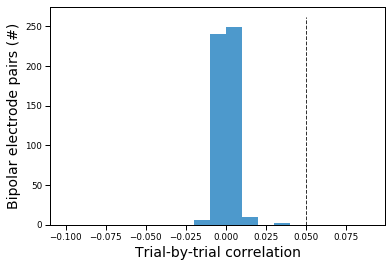

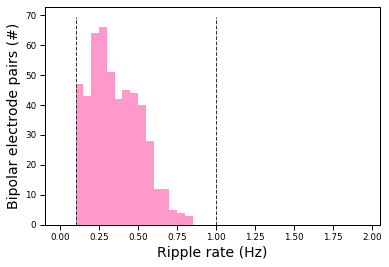

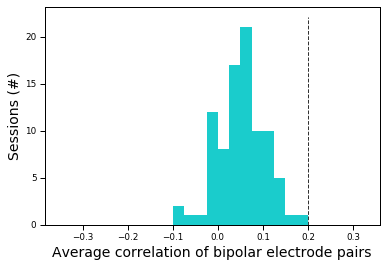

In [41]:
save_figs = 0
# np.array(trial_by_trial_correlation)
# np.array(elec_ripple_rate_array)
# np.array(elec_by_elec_correlation)
set_pubfig()

# trial-by-trial correlation
plt.hist(trial_by_trial_correlation,np.arange(-0.1,0.1,0.01),color = (0.3,0.6,0.8)); 
xlabel('Trial-by-trial correlation'); ylabel('Bipolar electrode pairs (#)'); 
plot([0.05,0.05],[gca().get_ylim()[0],gca().get_ylim()[1]],linewidth=1,linestyle='--',color=(0.2,0.2,0.2),label='_nolegend_')
if save_figs == 1:
    plt.savefig('../figures/control_params/trial-by-trial_correlation.pdf',transparent=True); show()
else:
    show()

# ripple rates
plt.hist(elec_ripple_rate_array,np.arange(0,2,0.05),color = (1,0.6,0.8)); 
xlabel('Ripple rate (Hz)'); ylabel('Bipolar electrode pairs (#)'); 
ylims = [gca().get_ylim()[0],gca().get_ylim()[1]]
plot([0.1,0.1],ylims,linewidth=1,linestyle='--',color=(0.2,0.2,0.2),label='_nolegend_')
plot([1,1],ylims,linewidth=1,linestyle='--',color=(0.2,0.2,0.2),label='_nolegend_')
if save_figs == 1:
    plt.savefig('../figures/control_params/ripple_rates_by_electrode.pdf',transparent=True); show()
else:
    show()
    
plt.hist(elec_by_elec_correlation,np.arange(-0.35,0.35,0.025),color = (0.1,0.8,0.8)); 
xlabel('Average correlation of bipolar electrode pairs'); ylabel('Sessions (#)'); 
plot([0.2,0.2],[gca().get_ylim()[0],gca().get_ylim()[1]],linewidth=1,linestyle='--',color=(0.2,0.2,0.2),label='_nolegend_')
if save_figs == 1:
    plt.savefig('../figures/control_params/sessions_electrode_correlations.pdf',transparent=True)
show();

#     max_ripple_rate = 3 #1.5 # Hz.
#     max_trial_by_trial_correlation = 1 #0.05 # if ripples correlated more than this remove them
#     max_electrode_by_electrode_correlation = 1 #0.2 #???
#     if filter_type == 'hamming':
#         min_ripple_rate = 0 # 0.1 # Hz.
#     else:
#         min_ripple_rate = 0.05 # for methods with lower rates decrease the minimum cutoff

## Get start_array and select subfield if HPC for free recalls

In [74]:
## DO YOU WANT TO SELECT A SUBFIELD or OUTPUT POSITION?? ##  

select_subfield = True   # note: if you already ran this once, have to load again from data
                          # also this is only for HPC. So set to FALSE for ENT and PHC
    
# select for subfield if HPC
if select_subfield == True:
    location_selected = 'ca1' #'dg' # 'ca3' # 'dg' 'ca1' # sub # ['ca1','dg']
        # left # right # left hippocampus # right hippocampus # hippocampus
        # to see number of each: sum(np.array([names.find('sub') for names in HPC_names])>=0)
else:
    location_selected = ''
    

### Use a task condition to select recalls?? ###
### ...will select first one that's not 0    ###
select_ordinal_position = 0              # select only recalls at given output position. 0 means it's off ##DEPRECATED
select_list_position = 0 #[1,2,3] #[12]  # select only recalls at given position from encoding list. 
                                         # 0 means it's off. Must be list
select_less_than_rectime = 0             # select only recalls < this number % 5000
select_greater_than_rectime = 0          # select only recalls ≥ this number % 5000
select_lists_with_recalls = 0 # list(np.arange(3,13)) # [1] so this would select ≥4 recalls. Must be list hence the list(arange...)
                                         # select only recalls that come from lists with number in this list
select_intrusions_next = 0               # select recalls that lead to intrusions
    
if filter_type.find('hamming') != -1:
    desired_sample_rate = 500.
else:
    desired_sample_rate = 1000.
sr = desired_sample_rate # fixed at this value since this is the minimum across data and can always downsample
sr_factor = 1000/desired_sample_rate

print('Total electrodes loaded: '+str(len(trial_nums)))
print('from '+str(len(np.unique(sub_sess_names)))+' sessions from '+str(len(np.unique(sub_names)))+' subjects with trial nums:')
print(trial_nums[0:20])
print('Trial sum = '+str(np.sum(trial_nums)))
print(HPC_names[0:20])
print('Number of sub_sess names: '+str(len(sub_sess_names)))


start_array,end_array = getStartEndArrays(ripple_array) # get start array
 
# if selected an output position
if select_ordinal_position > 0:
    if np.min(ordinal_position_array) == 0: # only update this once (so don't have to reload data from files)
        ordinal_position_array = np.array(ordinal_position_array)+1 # now 1-indexed
    selected_recalls = ordinal_position_array==select_ordinal_position
elif type(select_list_position) == list:
    selected_recalls = [sp in select_list_position for sp in serialpos_array]
elif select_intrusions_next == 1:
    selected_recalls = np.array(recall_before_intrusion_array)==True
elif select_less_than_rectime > 0:
    selected_recalls = np.array(rectime_array)<select_less_than_rectime
elif select_greater_than_rectime > 0:
    selected_recalls = np.array(rectime_array)>=select_greater_than_rectime
elif type(select_lists_with_recalls) == list:
    selected_recalls = [recall in select_lists_with_recalls for recall in list_recall_num_array]
else:
    selected_recalls = np.ones(len(start_array),dtype=bool)
    
# get locations if selected

if select_subfield == True:
    # create the full vector of location name predictors
    location_names = []
    for s in range(len(HPC_names)):
        new_trials = int(trial_nums[s])
        location_names.extend(np.tile(HPC_names[s],new_trials))  
        
    # now can get mask of trials in this location
    
    #first, if there are two locations to combine, sort that out (DG and CA1 in particular)
    location_mask = np.zeros(len(location_names))
    for s in range(len(location_names)):
        if type(location_selected)==list:
            if location_names[s].find(location_selected[0])>=0 or location_names[s].find(location_selected[1])>=0:
                location_mask[s] = True
        elif type(location_selected)==str:
            if location_names[s].find(location_selected)>=0:
                location_mask[s] = True
else:
    location_mask = np.ones(len(start_array))

# gotta translate this to new frame as well from idxs in load step if selected subfield
if select_subfield == True: 
    location_mask = location_mask[temp_recall_idxs] 

# combine location and sorted recalls to get new ripple array:
updated_recalls = (location_mask+selected_recalls)==2
    
# translate these predictors to vector and select recalls
start_array = start_array[updated_recalls]
end_array = end_array[updated_recalls] # used for duration calculations
subject_name_array = np.array(subject_name_array)[updated_recalls]
session_name_array = np.array(session_name_array)[updated_recalls]
electrode_array = np.array(electrode_array)[updated_recalls]
channel_coords_array = np.array(channel_coords_array)[updated_recalls]
channel_nums_array = np.array(channel_nums_array)[updated_recalls]
if selected_period in ['surrounding_recall','math','math_retrieval']:
    list_recall_num_array = list_recall_num_array[updated_recalls] # for subject-level analysis
    rectime_array = np.array(rectime_array)[updated_recalls]
if selected_period == 'surrounding_recall':
    list_num_key = list_num_key[updated_recalls]
#     session_events = session_events[updated_recalls]
    
    
print('Got start_array with '+str(start_array.shape[0])+' trials!')

sub_elec = [subject_name_array[i]+electrode_array[i] for i in range(len(electrode_array))]
        
# # plot whole retrieval period with FR events superimposed on SWRs
# if selected_period == 'whole_bretrieval':
#     start_array2 = start_array # for whole retrieval period
#     print('Base SWRs/30 s retrieval: '+str(sum(start_array2)/start_array2.shape[0]/(30000/1000)))
#     ## can go straight to "SWRs by time in retrieval period" from here
# else:
#     print('SWRs rate in 4 s around FR: '+str(sum(start_array)/start_array.shape[0]/(4000/1000)))

# # subplots(1,1,figsize=(6,9))
# # plot([0,0],[0,fr_array.shape[0]],linewidth=1,linestyle='-',color=(0,0,0))
# # plot(np.ones(2)*(retrieval_whole_time),[0,fr_array.shape[0]],linewidth=1,linestyle='-',color=(0,0,0))
# # scatter(np.where(start_array2)[1]*sr_factor+psth_start,np.where(start_array2)[0],s=0.5)
# # scatter(np.where(fr_array)[1],np.where(fr_array)[0],s=0.5,color=[1,0,0]); 
# # plt.xlabel('Retrieval period time (ms)')
# # plt.ylabel('Retrieval period')
# # if save_plot == 1:
# #     plt.savefig('../plots/'+'SWR_FR_'+region_name+'-'+str(session_ct)+'_sessions_in-'+str(sub_num)+'subjects_'+filter_type+'.pdf',transparent=True)
# # plt.show();    

Total electrodes loaded: 1353
from 283 sessions from 142 subjects with trial nums:
[10. 10. 10. 10. 12. 12. 12. 12. 12. 12. 12. 72. 72. 21. 21. 21. 21. 21.
 21. 21.]
Trial sum = 51194.0
['left ca1', 'left dg', 'left dg', 'left ca1', 'left sub', 'left ca1', 'left ca1', 'left sub', 'left ca1', 'left dg', 'left ca1', 'left ca3', 'left ca1', 'left ca1', 'left sub', 'left sub', 'left ca1', 'right ca1', 'right ca1', 'right ca1']
Number of sub_sess names: 1353
Got start_array with 12391 trials!


## Subject-level memory performance

In [ ]:
# do subjects show a bigger ripple bump when they remember more words/list?

## NOTE: to run this make sure:
## 1) recall_select_type = 6. HAVE to remove first recalls of each list or will bias result since
##    first recall doesn't have bump anyway and worse performing patients will have more first recalls.
##    selecting for ≥2 recalls takes all trials that should have bumps and compares those
## 2) selected_recalls from last cell gives all trials (it'll crash otherwise due to indexing error)
## 3) for high v. low memory analysis, need to comment out bin_model2, 

# goal is ot measure z-scores of each individual subject and also correlate those to temporal clustering

min_trials = 20 # define up here since use for ME model arrays being appended too

import warnings
%autoreload

sub_Ts1 = []; sub_Ts2 = []; 
sub_Bs1 = []; sub_Bs2 = []; 
test1 = []; test2 = []
trial_accum = []; sub_z_score = []
rate_accum = []; rate_accum2 = []; rate_accum_half = []
trial_ct = 0
temp_sub_names = []
sub_avg_recall_num = []; sub_avg_recall_time = []

ME_bin2 = []; ME_bin0 = []; ME_first_half = []
ME_sessions = []; ME_subjects = []
ME_recall_num = []; ME_recall_time = []

for sub in np.unique(subject_name_array):
    sub_idxs = [sub in s for s in subject_name_array]
    if sum(sub_idxs) > 1:
        sub_start_array = start_array[sub_idxs]
        sub_subject_name_array = np.array(subject_name_array)[sub_idxs]
        sub_session_name_array = np.array(session_name_array)[sub_idxs]        
       
        # now get z-score separately for each sub with ME model

        # let's measure significance at two key 500 ms bins (and compare to similar bin 500 ms earlier/later)
        stats_bin = 500 # time bin width in ms to test stats on
        psth_start = -2000

        first_start = -1600 # going to make sequence of 3 bins and test 1st v. 3rd
        first_end = -100
        second_start = 200 # same idea
        second_end = 1700

        start_array.shape
        binned_first_stats_array = sub_start_array[:,int((first_start-psth_start)/sr_factor):
                                                   int((first_end-psth_start)/sr_factor)]
        binned_second_stats_array = sub_start_array[:,int((second_start-psth_start)/sr_factor):
                                                    int((second_end-psth_start)/sr_factor)]
        binned_first_stats_array = binBinaryArray(binned_first_stats_array,stats_bin,sr_factor)
        binned_second_stats_array = binBinaryArray(binned_second_stats_array,stats_bin,sr_factor)
        
        if len(binned_first_stats_array[:,2]) >= min_trials:
            
            # how many recalls/list for each recall?
            sub_avg_recall_num.append(np.mean(list_recall_num_array[sub_idxs]))        
            temp_sub_names.append(sub)

            # test first half of recall plots for first recalls only
            if recall_type_switch == 4:
                # first get the average recall times for each trial
                sub_avg_recall_time.append(np.mean(rectime_array[sub_idxs]))

                binned_half_array = sub_start_array[:,int((-2000-psth_start)/sr_factor):
                                                    int((0-psth_start)/sr_factor)]
                binned_half_array = binBinaryArray(binned_half_array,stats_bin,sr_factor)
                rate_accum_half.append(np.mean(binned_half_array))

            rate_accum.append(np.mean(binned_first_stats_array[:,2]))
            # grab the ripple rate for bin 1 second before too
            rate_accum2.append(np.mean(binned_first_stats_array[:,0])) 
            trial_accum.append(len(binned_first_stats_array[:,2]))
            trial_ct+=len(binned_first_stats_array[:,2])

            if np.mod(len(temp_sub_names),10)==0:
                print('done binning start_arrays (printing every 10th)'); len(binned_first_stats_array)
                print(str(np.mean(binned_first_stats_array[:,2]))+' for '+str(len(binned_first_stats_array[:,2]))+ ' trials')
                print(trial_ct)

            # create data arrays for mixed effects model of bump v. memory after plots in next cell
            ME_bin2.extend(binned_first_stats_array[:,2])
            ME_bin0.extend(binned_first_stats_array[:,0])
            ME_recall_num.extend(list_recall_num_array[sub_idxs])
            ME_sessions.extend(sub_session_name_array)
            ME_subjects.extend(sub_subject_name_array)
            if recall_type_switch == 4:
                ME_first_half.extend(np.mean(binned_half_array,1))
                ME_recall_time.extend(rectime_array[sub_idxs])

            # get z-score of key bin v. all 8 bins
            full_sub_bin = binBinaryArray(sub_start_array,500,sr_factor)
            sub_binned_mean = np.mean(full_sub_bin,0)
            sub_z_score.append( (rate_accum[-1]-(np.mean(sub_binned_mean)))/np.std(sub_binned_mean) )

            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")

                bin_model1 = MEstatsAcrossBins(binned_first_stats_array[:,[0,2]],sub_subject_name_array,sub_session_name_array)
                sub_Ts1.append(bin_model1.tvalues[1])
                sub_Bs1.append(bin_model1.params[1])
                test1.append(np.mean(binned_first_stats_array[:,0]))

#                 bin_model2 = MEstatsAcrossBins(binned_second_stats_array[:,[0,2]],sub_subject_name_array,sub_session_name_array)                
#                 sub_Ts2.append(bin_model2.tvalues[1])                
#                 sub_Bs2.append(bin_model2.params[1])                
#                 test2.append(np.mean(binned_first_stats_array[:,2]))
        
corrected_for_nans = 0 # for below
a=1;

# subject-level plots

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


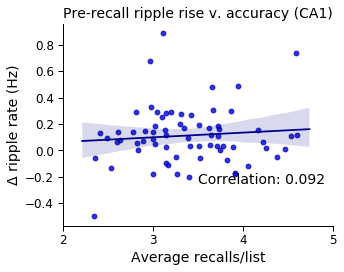

Number of low recall patients: 34
Number of high recall patients: 35
T-test between these: p = 0.8155866955243427
T-test between t-stats for each group instead: p = 0.35914479742178673
t-statistic: 0.9233373417490349


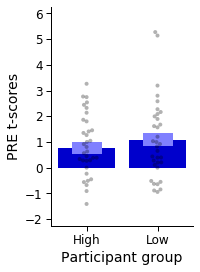

Number of participants in plot: 69


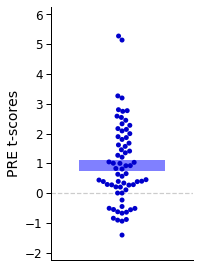

One-sample t-test of t-scores: 1.3969959645746705e-06
t-statistic: 5.29183601250894


/home1/john/johnModules/general.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  second_test = num == 'nan' # some string types don't work with above line


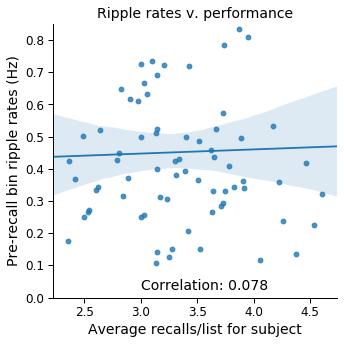

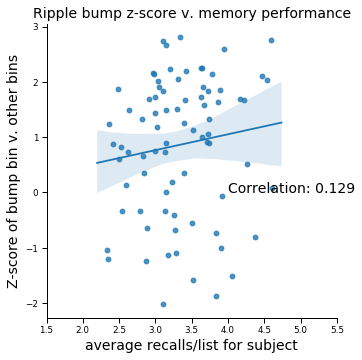

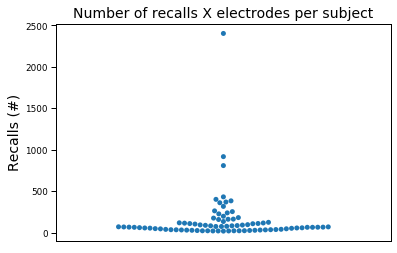

P-values for ME model with indicator between key bin v. 1 second earlier bin (1s and 0s, respectively)
               Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    ripple_rates
No. Observations:     12146      Method:                REML        
No. Groups:           79         Scale:                 1.8162      
Min. group size:      20         Likelihood:            -20889.0880 
Max. group size:      2403       Converged:             Yes         
Mean group size:      153.7                                         
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  0.203    0.046  4.432 0.000  0.113  0.293
num_recalls               -0.025    0.012 -2.124 0.034 -0.049 -0.002
subject Var                0.011    0.010                           
subject x num_re

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [69]:
save_figs = 1

import seaborn as sb
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind
    
def defaultPlotting(): 
    sb.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white")

if min_trials > 0 and corrected_for_nans == 0:
    
    np.mean(sub_Ts1)
    np.std(sub_Ts1)/np.sqrt(50)
    
    good_subs = np.array(trial_accum)>=min_trials
    rate_accum = np.array(rate_accum)[good_subs]  
    rate_accum2 = np.array(rate_accum2)[good_subs] # bin 1 sec earlier
    sub_z_score = np.array(sub_z_score)[good_subs]
    sub_Ts1 = np.array(sub_Ts1)[good_subs]    
    trial_accum = np.array(trial_accum)[good_subs]    
    temp_sub_names = np.array(temp_sub_names)[good_subs]    
    
#     np.mean(sub_Ts2)
#     np.std(sub_Ts2)/np.sqrt(50)
#     sub_Ts2 = np.array(sub_Ts2)[good_subs]

    sub_avg_recall_num = np.array(sub_avg_recall_num)[good_subs]
    
    corrected_for_nans = 1

# # Test 1 v. recalls/list # using t-scores here doesn't make sense since will be correlated with # recalls
# plot_df = pd.DataFrame({'avg_recall_num':sub_avg_recall_num,'t-scores':sub_Ts1})
# sb.lmplot(x='avg_recall_num',y='t-scores',data=plot_df)
# subs_with_no_nans = ~np.isnan(np.array(sub_Ts1))
# plot_corr = np.corrcoef(np.array(sub_avg_recall_num)[subs_with_no_nans],np.array(sub_Ts1)[subs_with_no_nans])[0][1]
# annotate('Correlation: '+str(np.round(plot_corr,3)),(4,0))
# ylabel('t-scores from mixed effects model of -600:-100 v. -1600:-1100')
# xlabel('average recalls/list')
# title('Ripple bump v. memory performance')
# show()
# scatter(x=sub_temporal_score,y=sub_Ts1)
# scatter(sub_temporal_score,sub_Ts2); show()




### $$$# subject-level figures we decided on ##$$###$

if location_selected == 'dg':
    min_rate = 0.1
    plot_color = [(0.8,0,0)]
    lmplot_color = (0.8,0,0,0)
    errorbar_color = (1,0.5,0.5)
    line_color = 'darkred'
elif region_name == 'ENT':
    min_rate = 0.0 # for ENT and PHC I don't do further stats so just set to 0 to show all the datapoints in the swarm
    plot_color = [(0.5,0.5,0)]
    lmplot_color = (0,0,0,0)
    errorbar_color = (0.8,0.8,0)
    line_color = 'black'
elif region_name == 'PHC':
    min_rate = 0.0
    plot_color = [(0,0.5,0.5)]
    lmplot_color = (0,0,0,0)
    errorbar_color = (0,0.8,0.8)
    line_color = 'black' 
elif location_selected == 'ca1' or location_selected == '':
    min_rate = 0.1 # for CA1 and DG I require a FR minimum for the two bins being compared since I do further stats on them
    plot_color = [(0,0,0.8)]
    lmplot_color = (0,0,0.8,0)
    errorbar_color = (0.5,0.5,1)
    line_color = 'darkblue'
    
    
## Ripple rate delta between key bin and 1 sec before bin v. temporal clutsering

good_subs = (rate_accum > min_rate) & (rate_accum2 > min_rate)
temp_sub_avg_recall_num = sub_avg_recall_num[good_subs]
rate_accum_delta = rate_accum[good_subs] - rate_accum2[good_subs]
good_sub_Ts1 = sub_Ts1[good_subs]

set_pubfig()
plot_df4 = pd.DataFrame({'avg_recall_num':temp_sub_avg_recall_num,'ripple_rates':rate_accum_delta,
                        'sub_Ts1':good_sub_Ts1})
sb.lmplot(x='avg_recall_num',y='ripple_rates',data=plot_df4,
         scatter_kws = {'color': lmplot_color},line_kws = {'color': line_color},
         size=4,aspect=1.25)

# gca().set(ylim=(0,0.85),xlim=(1.5,5.5))
gca().tick_params(labelsize=12)
# gca().set(xlim=(2,5))
plot_corr = np.corrcoef(temp_sub_avg_recall_num,rate_accum_delta)[0][1]
annotate('Correlation: '+str(np.round(plot_corr,3)),(3.5,-0.25))
ylabel(u'Δ ripple rate (Hz)')
xlabel('Average recalls/list')
if type(location_selected)==list:
    location_selected = location_selected[0]+location_selected[1]
title('Pre-recall ripple rise v. accuracy ('+location_selected.upper()+')')
xticks(np.arange(2,5.01,1))
gcf().tight_layout()

if save_figs == 1:
    fname = '/home1/john/SWR/figures/subject-level_plots/deltaRRvMemory_'+exp+'_'+region_name+'_'+\
        location_selected+'_'+str(recall_type_switch)+'_'+filter_type+'_'+sub_selection+'.pdf'
    savefig(fname,format='pdf',transparent=True)
save_fig = 0
show()


## high v. low recall patients

split_into = 2 # high v. low
delta_ripple_or_Ts = 1 # 0 for delta_ripples; 1 for sub_Ts

set_pubfig()
plot_df = copy(plot_df4) # plot_df4 is delta(rate) # plot_df5 is PRE bin
quartile_labels = range(split_into)
quartiles = pd.qcut(plot_df.avg_recall_num,split_into,labels=quartile_labels)
quartile_idxs = np.array(quartiles.values)
mean_ripples = []; ste_ripples = []
mean_mem = []; ste_mem = []
for val in np.unique(quartile_idxs):
    selected_quartile = quartile_idxs==val
    if delta_ripple_or_Ts == 0:
        mean_ripples.append(np.mean(plot_df.ripple_rates[selected_quartile]))
        ste_ripples.append(np.std(plot_df.ripple_rates[selected_quartile])/np.sqrt(len(plot_df.ripple_rates[selected_quartile])))
    else:
        mean_ripples.append(np.mean(plot_df.sub_Ts1[selected_quartile]))
        ste_ripples.append(np.std(plot_df.sub_Ts1[selected_quartile])/np.sqrt(len(plot_df.sub_Ts1[selected_quartile])))        
plot_df['idxs'] = quartile_idxs # for swarmplot

figSub,axSub = plt.subplots(1,1, figsize=(3,4))
# axSub.bar(range(split_into),mean_ripples,yerr=ste_ripples,color=plot_color)
bar(range(split_into),mean_ripples,yerr=ste_ripples,color=plot_color,error_kw=dict(lw=30, capsize=0, capthick=0, ecolor=errorbar_color))

# changes from Mike
gca().spines['right'].set_visible(False)
gca().spines['top'].set_visible(False)

add_swarm = 1
if add_swarm == 1:
    extra = '_swarm'
    if delta_ripple_or_Ts == 0:
        sb.swarmplot(x='idxs',y='ripple_rates',data=plot_df, ax=axSub, color=(0,0,0), alpha=0.3, size=4)
        axSub.set(ylim=(-0.5,0.5))
        ytick_range = np.arange(-0.5,0.501,0.25)
        ylabel(u'Δ ripple rate (Hz)')
    else:
        sb.swarmplot(x='idxs',y='sub_Ts1',data=plot_df, ax=axSub, color=(0,0,0), alpha=0.3, size=4)
        axSub.set(ylim=(-2.25,6.25))
        ytick_range = np.arange(-2,6.01,1)        
        ylabel(u'PRE t-scores')
else:
    ylim(0,0.175)
    ytick_range = np.arange(0,0.151,0.05)
    extra = ''
    
yticks(ytick_range,fontsize=12)
xticks([1,0],['Low','High'],fontsize=12) # somehow these are reversed but the high patients have high ripples (see the means below)]
xlabel('Participant group')



print('Number of low recall patients: '+str(sum(np.array(quartiles.values))))
print('Number of high recall patients: '+str(sum(np.array(quartiles.values)==0)))
print('T-test between these: p = '+
    str(ttest_ind(plot_df.ripple_rates[np.array(quartiles.values)==1], plot_df.ripple_rates[np.array(quartiles.values)==0])[1]))
print('T-test between t-stats for each group instead: p = '+
    str(ttest_ind(plot_df.sub_Ts1[np.array(quartiles.values)==1], plot_df.sub_Ts1[np.array(quartiles.values)==0])[1]))
print('t-statistic: '+str(ttest_ind(plot_df.sub_Ts1[np.array(quartiles.values)==1], plot_df.sub_Ts1[np.array(quartiles.values)==0])[0]))
np.mean(plot_df.ripple_rates[np.array(quartiles.values)==1]) # high ripple rate patients
np.mean(plot_df.ripple_rates[np.array(quartiles.values)==0])
np.mean(plot_df.avg_recall_num[np.array(quartiles.values)==1]) # high memory patients
np.mean(plot_df.avg_recall_num[np.array(quartiles.values)==0])

tight_layout()
if save_figs == 1:
    fname = '/home1/john/SWR/figures/subject-level_plots/low_v_high_memory_'+exp+'_'+region_name+'_'+\
        location_selected+'_'+str(recall_type_switch)+'_'+filter_type+'_'+sub_selection+extra+'.pdf'
    savefig(fname,format='pdf',transparent=True)
save_fig = 0
show()


# t-score histogram (PRE)

# (doing this at end since I ensure PRE bin and bin 1 sec earlier have > 0.1 hz RRs) 

set_pubfig()
temp_df = pd.DataFrame({'sub_Ts':good_sub_Ts1})
if region_name == 'HPC':
    fig, ax = subplots(figsize=(3,4))
else:
    fig, ax = subplots(figsize=(3,3))

# first plot the error bars
st_err = np.std(good_sub_Ts1)/np.sqrt(len(good_sub_Ts1))
bar_bottom = np.mean(good_sub_Ts1)-st_err
bar_height = 2*st_err
bar(x=0,height=bar_height,width=0.6,bottom=bar_bottom,color=errorbar_color)

# changes from Mike
yticks(fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# now the swarm
p1 = sb.swarmplot(ax=ax,y='sub_Ts', data=temp_df, palette=plot_color) 
# ax1 = p1.axes
ax.axhline(0, ls='--',color=(0.8,0.8,0.8))
ax.set(xticks=[])
ax.tick_params(labelsize=12)
if region_name == 'HPC':
    if selected_period == 'surrounding_recall':
        ax.set(ylim=(-2.25,6.25))
    else:
        ax.set(ylim=(-4,4))
else:
    ax.set(ylim=(-2.6,4.25))
ylabel('PRE t-scores')
tight_layout()
print('Number of participants in plot: '+str(len(good_sub_Ts1)))

if save_figs == 1:
    if type(location_selected)==list:
        location_selected = 'ca1dg'
    fname = '/home1/john/SWR/figures/subject-level_plots/t-score_histo_'+exp+'_'+region_name+'_'+\
        location_selected+'_'+str(recall_type_switch)+'_'+filter_type+'_'+sub_selection+'.pdf'
    savefig(fname,format='pdf',transparent=True)
save_fig = 0
show()
# print sign test across subjects too
test_sub_Ts1 = good_sub_Ts1[~isNaN(good_sub_Ts1)]
t_stat,onesample_p = stats.ttest_1samp(test_sub_Ts1,0)
print('One-sample t-test of t-scores: '+str(onesample_p))
print('t-statistic: '+str(t_stat))


##$$$ ###



# ## For math period let's also do post-recall 
# # (doing this in post-recall bin)

# good_sub_Ts2 = sub_Ts2[good_subs] # should really use good_subs based on sub_Ts2 but just using based on pre-recall bins for now

# set_pubfig()
# temp_df = pd.DataFrame({'sub_Ts':good_sub_Ts2})
# if region_name == 'HPC':
#     fig, ax = subplots(figsize=(3,4))
# else:
#     fig, ax = subplots(figsize=(3,3))

# # first plot the error bars
# st_err = np.std(good_sub_Ts2)/np.sqrt(len(good_sub_Ts2))
# bar_bottom = np.mean(good_sub_Ts2)-st_err
# bar_height = 2*st_err
# bar(x=0,height=bar_height,width=0.6,bottom=bar_bottom,color=errorbar_color)

# # changes from Mike
# yticks(fontsize=12)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# # now the swarm
# p1 = sb.swarmplot(ax=ax,y='sub_Ts', data=temp_df, palette=plot_color) 
# # ax1 = p1.axes
# ax.axhline(0, ls='--',color=(0.8,0.8,0.8))
# ax.set(xticks=[])
# ax.tick_params(labelsize=12)
# if region_name == 'HPC':
#     if selected_period == 'surrounding_recall':
#         ax.set(ylim=(-2.25,6.25))
#     else:
#         ax.set(ylim=(-4,4))
# else:
#     ax.set(ylim=(-2.6,4.25))
# ylabel('POST t-scores')

# tight_layout()

# if save_figs == 1:
#     if type(location_selected)==list:
#         location_selected = 'ca1dg'
#     fname = '/home1/john/SWR/figures/subject-level_plots/t-score_histo_POST_'+exp+'_'+region_name+'_'+\
#         location_selected+'_'+str(recall_type_switch)+'_'+filter_type+'_'+sub_selection+'.pdf'
#     savefig(fname,format='pdf',transparent=True)
# save_fig = 0
# show()
# # print sign test across subjects too
# test_sub_Ts2 = good_sub_Ts2[~isNaN(good_sub_Ts2)]
# _,onesample_p = stats.ttest_1samp(test_sub_Ts2,0)
# print('One-sample t-test of t-scores: '+str(onesample_p))


## Pre-recall ripple rates v. temporal clutsering

set_pubfig()
plot_df5 = pd.DataFrame({'avg_recall_num':sub_avg_recall_num,'ripple_rates':rate_accum})
# take only rates > usually defined 0.1 Hz minimum
plot_df5 = plot_df5[plot_df5.ripple_rates>0.1]

fig1 = sb.lmplot(x='avg_recall_num',y='ripple_rates',data=plot_df5) #,
#                  line_kws = {'color': 'black'},scatter_kws = {'color': 'black'})
gca().set(ylim=(0,0.85))
gca().tick_params(labelsize=12)
# gca().set_xticks(gca().get_xticks())
# gca().set_xticklabels(gca().get_xticks(),rotation=0)
# gca().set_ylabel(size=14)
# gca().set(xticks=np.arange(2,5,0.5))

plot_corr = np.corrcoef(sub_avg_recall_num,rate_accum)[0][1]
annotate('Correlation: '+str(np.round(plot_corr,3)),(3,0.025))
ylabel('Pre-recall bin ripple rates (Hz)')
xlabel('Average recalls/list for subject')
title('Ripple rates v. performance')
gcf().tight_layout()
show()


# Z-scores v. temporal clustering
plot_df = pd.DataFrame({'avg_recall_num':sub_avg_recall_num,'sub_z_score':sub_z_score})
sb.lmplot(x='avg_recall_num',y='sub_z_score',data=plot_df)
plot_corr = np.corrcoef(sub_avg_recall_num,sub_z_score)[0][1]
annotate('Correlation: '+str(np.round(plot_corr,3)),(4,0))
ylabel('Z-score of bump bin v. other bins')
xlabel('average recalls/list for subject')
title('Ripple bump z-score v. memory performance')
gca().set(xlim=(1.5,5.5))
show()    

# trial histogram
set_pubfig()
sb.swarmplot(y=trial_accum) 
gca().set(xticks=[])
ylabel('Recalls (#)')
title('Number of recalls X electrodes per subject')
show()


## let's do a mixed model on this data too since correlation isn't ideal due to varying sample sizes across patients ##

rr_df = pd.DataFrame(data={'session':ME_sessions,'subject':ME_subjects,
                           'ripple_rates':np.array(ME_bin2)-np.array(ME_bin0),'num_recalls':ME_recall_num
                          })
vc = {'session':'0+session'} # to nest sessions in subjects
# intercept included when using smf
rr_model = smf.mixedlm("ripple_rates ~ num_recalls", rr_df, groups="subject",
                       vc_formula=vc, re_formula="1+num_recalls") 
rr_fit = rr_model.fit(reml=True, method='nm',maxiter=2000)

print('P-values for ME model with indicator between key bin v. 1 second earlier bin (1s and 0s, respectively)')
print(rr_fit.summary()) #pvalues)
print('Key num_recalls X bin interaction: '+str(np.round(rr_fit.pvalues[1],4)))

a=1;

## Big Raster!!

In [ ]:

## for the raster and PSTH binarize the data by using the start indices of the ripple

sr_factor = 2 # always 2 since downsampled everything to 500 Hz

save_raster = 0

elec_dividers_on = 1 # toggles gray lines between electrodes
session_dividers_on = 1 # toggles cyan lines between sessions

width = 5
height = 40

dot_color = (0.1,0.1,0.1)
between_subject_color = (0.6,0,0.6) # purple
between_session_color = (0,0.6,0.6) # cyan

%autoreload
if selected_period == 'surrounding_recall':
    psth_start = -2000
    psth_end = 2000
elif selected_period == 'encoding':
    psth_start = -700
    psth_end = 2300

# plot raster
subplots(1,1,figsize=(width,height))   #y=100 for data cleaning # (4,6) for Fig. 4b # (4,10) for Fig. 2a
scatter(np.where(start_array)[1]*sr_factor+psth_start,np.where(start_array)[0],s=4,color=dot_color) # SWR time v. trial
xticks(np.round(np.arange(psth_start,psth_end+1,500),2),np.round(np.arange(psth_start/1000,psth_end/1000+1,0.5),2))
xlabel('Time from recall (s)')
ylabel('Trial')
ax = plt.gca()

ax.set_xlim(psth_start-100,psth_end+100)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]], linewidth=1,linestyle='-',color=(0,0,0))

last_sub = sub_names[0]
last_sess = sub_sess_names[0]
channels_per_session = []
trial_accum = 0
for s in range(1,len(trial_nums)):
    if (sub_names[s] != last_sub) | (s==1):
        if s != 1:
            # plot dark gray line between subjects
            plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=1.5,linestyle='-',color=between_subject_color)
            last_sub = sub_names[s]
            text(psth_end+100,0.5+np.sum(trial_nums[:s]),sub_names[s])
        else: 
            if session_dividers_on==1:
                # if 1st sub though gotta print that first gray line 
                plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=0.5,linestyle='-',color=between_session_color)
                text(psth_end+100,0,sub_names[s]) # and print 1st sub name at y=0
    else: # plot lines between electrodes
        if elec_dividers_on == 1:
            plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=0.5,linestyle='-',color=(.7,.7,.7))
    # plot lines between sessions
    if session_dividers_on==1:
        if sub_sess_names[s] != last_sess:
            plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=0.75,linestyle='-',color=between_session_color)
            last_sess = sub_sess_names[s]
            
    channels_per_session.append(np.unique(channel_nums_array[int(trial_accum):int(trial_accum+trial_nums[s])]))
    trial_accum = trial_accum+trial_nums[s]
    
plot([ax.get_xlim()[0],ax.get_xlim()[1]],-.5*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))        
plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums))*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))
ax.autoscale(enable=True, axis='y', tight=True)
plt.tight_layout()
# print('Total FR events: '+str(total_recalls)) # these were in whole retrieval period so not kept in usual ripple alignment
# print('Kept FR events: '+str(kept_recalls))
print(start_array.shape);
if save_raster == 1:
    if elec_dividers_on == 1:
        plt.savefig('../figures/rasters/'+exp+'_'+'raster_'+region_name+'_'+location_selected+
                    '-'+str(recall_type_switch)+'-'+filter_type+'.pdf',transparent=True)       
    else:
        plt.savefig('../figures/rasters/'+exp+'_'+'raster_'+region_name+'_'+location_selected+
                    '-'+str(recall_type_switch)+'no_elecs-'+filter_type+'.pdf',transparent=True)
a=1;

## PSTH with mixed effect CIs

In [ ]:
%autoreload
# make a PSTH based on start times of SWRs
bin_size = 100 # in ms
smoothing_triangle = 5 # triangular smoothing window width
samples = 100
pad = int(np.floor(smoothing_triangle/2)) # factor is how many points from middle does triangle go?
psth_start = -2000
psth_end = 2000

PSTH,bin_centers = fullPSTH(start_array,bin_size,smoothing_triangle,sr,psth_start)
# bootstraps error bars by sampling from trials in raster with replacement samples number of
# times and then taking the standard deviation across those samples
# boot_samples = bootstrap(start_array, bootnum=samples, samples=None, # bootstrap error bars using resampling
#                bootfunc=lambda x: bootPSTH(x,binsize,smoothing_triangle,sr,psth_start))
# boot_SD = np.std(boot_samples,0)

# get binned start array (trials X bins)
binned_start_array = binBinaryArray(start_array,bin_size,sr_factor)
if pad > 0:
    binned_start_array = binned_start_array[:,pad:-pad] # remove edge bins
print('done making binned start_array with shape:')
binned_start_array.shape

# # get trial X 1 categorical names for subjects and sessions # do this in start_array cell now
# if select_ordinal_position == 0: # if 0 already did this in last cell
#     subject_name_array,session_name_array = getSubSessPredictors(sub_names,sub_sess_names,trial_nums)

# note that output is the net ± distance from mean
SE_plot = getMixedEffectSEs(binned_start_array,subject_name_array,session_name_array)
print('SEs created!')

# should all be same length! (sanity check)
print('Are these three the same length?? They should be!')
binned_start_array.shape
len(subject_name_array)
len(session_name_array)

done making binned start_array with shape:


(17567, 36)

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_lin

SEs created!
Are these three the same length?? They should be!


(17567, 36)

17567

17567

# Stats on key recall-aligned bins

In [ ]:
save_plot_data = 1

plot_sig_bars = 0

# let's measure significance at two key 500 ms bins (and compare to similar bin 500 ms earlier/later)
stats_bin = 500 # time bin width in ms to test stats on

first_start = -1600 # going to make sequence of 3 bins and test 1st v. 3rd
first_end = -100
second_start = 200 # same idea
second_end = 1700

start_array.shape
binned_first_stats_array = start_array[:,int((first_start-psth_start)/sr_factor):int((first_end-psth_start)/sr_factor)]
binned_second_stats_array = start_array[:,int((second_start-psth_start)/sr_factor):int((second_end-psth_start)/sr_factor)]
binned_first_stats_array = binBinaryArray(binned_first_stats_array,stats_bin,sr_factor)
binned_second_stats_array = binBinaryArray(binned_second_stats_array,stats_bin,sr_factor)
print('done binning start_arrays'); binned_start_array.shape

bin_model1 = MEstatsAcrossBins(binned_first_stats_array[:,[0,2]],subject_name_array,session_name_array)
bin_model2 = MEstatsAcrossBins(binned_second_stats_array[:,[0,2]],subject_name_array,session_name_array)
# bin_model1.summary()
# bin_model2.summary()


## plot PSTH and save data for plot (see SWRplots)


subplots(1,1,figsize=(6,4))
xr = bin_centers #np.arange(psth_start,psth_end,binsize)

# plot smoothed mean +/- SE
if pad > 0:
    plot(xr[pad:-pad],PSTH[pad:-pad])
    fill_between(xr[pad:-pad], PSTH[pad:-pad]-SE_plot[0,:], PSTH[pad:-pad]+SE_plot[0,:], alpha = 0.3)
else:
    plot(xr,PSTH)
    fill_between(xr, PSTH-SE_plot[0,:], PSTH+SE_plot[0,:], alpha = 0.3)

xticks(np.arange(psth_start,psth_end+1,500),np.arange(psth_start/1000,psth_end/1000+1,500/1000))
if selected_period == 'surrounding_recall':
    xlabel('Time from recall (s)')
elif selected_period == 'math_retrieval':    
    xlabel('Time from response (s)')
elif selected_period == 'math':
    xlabel('Time from problem onset (s)')
ylabel('Ripple rate (events/s)')
title('Mean of ripples for '+exp)
tight_layout()
ax = plt.gca()
if filter_type == 'hamming':
    ylim = 0.7 # keep it here since occasionally CIs get kinda high
else:
    ylim = 0.45
ax.set_ylim(0,ylim)
ax.set_xlim(psth_start-100,psth_end+100)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0));
x_width = [ax.get_xlim()[0],ax.get_xlim()[1]]

# plot bands of significance
if plot_sig_bars == 1:
    if bin_model1.pvalues[1] < 0.05:
        plot([first_end-stats_bin,first_end],[0.2,0.2],color=(1,0.5,0))
    if bin_model2.pvalues[1] < 0.05:
        plot([second_start,second_start+stats_bin],[0.2,0.2],color=(1,0.5,0))
num_trials = start_array.shape[0]


# get directories for if you save (don't put this in save_plot_data below since want p-values printed at bottom close to figures)
soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
path_name = '/home1/john/SWR/figures/'+subfolder

fn = os.path.join(path_name,
    'SWR_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+\
                  '_'+filter_type+'_'+sub_selection+'-ANLIPLOT.p') # -GT_5000.p' # -LT_5000.p' #'-intrusions.p'
print(fn)
print('Test 1 p-value: '+str(bin_model1.pvalues[1]))
print('Test 2 p-value: '+str(bin_model2.pvalues[1]))
print(str(num_trials)+' recalls')

if save_plot_data == 1:
    # get strings for path name for save and loading cluster data

    if os.path.isdir(path_name) == False:
        os.mkdir(path_name)
    if type(location_selected)==list:
        location_selected = 'ca1dg'
    with open(fn,'wb') as f:
        pickle.dump({'bin_centers':bin_centers,'PSTH':PSTH,'SE_plot':SE_plot,'num_trials':num_trials,
                    'bin_model1':bin_model1,'bin_model2':bin_model2,
                    'binned_first_stats_array':binned_first_stats_array,'binned_second_stats_array':binned_second_stats_array,
                    'subject_name_array':subject_name_array,'session_name_array':session_name_array,
                    'electrode_array':electrode_array,'channel_coords_array':channel_coords_array}, f)
a=1;

# David suggested correlating Jim's cortical reinstatement measure with ripples

In [9]:
# first need to load his CSV
pred_mat = pd.read_csv('/home1/john/data/cat_pred_ripple_df.csv')
pred_mat
# reduced session_name_array to just session numbers:
session_only_array = []
for s in session_name_array:
    session_only_array.append(int(s[7:]))

Unnamed: 0 subject  list  session cat_type category_pred  \
0                0  R1013E     1        0     list         Fruit   
1                1  R1013E     1        0     list  KitchenTools   
2                2  R1013E     1        0    other    Appliances   
3                3  R1013E     1        0    other     Beverages   
4                4  R1013E     1        0    other         Birds   
...            ...     ...   ...      ...      ...           ...   
458670      458670  R1342M    25        0    other         Trees   
458671      458671  R1342M    25        0    other    Vegetables   
458672      458672  R1342M    25        0    other      Vehicles   
458673      458673  R1342M    25        0    other           Zoo   
458674      458674  R1342M    25        0   recall      Building   

        log_cat_prob  cat_prob    corr_z      corr      item  index  
0          -3.210450  0.040357  0.004819  0.004811     moped     38  
1          -3.196121  0.040942  0.019173  0.019141     moped     38  
2          -3.245365  0.038984 -0.030185 -0.030104     moped     38  
3          -3.230538  0.039553 -0.015290 -0.015276     moped     38  
4          -3.231994  0.039498 -0.016749 -0.016733     moped     38  
...              ...       ...       ...       ...       ...    ...  
458670     -3.220400  0.039950  0.000450  0.000449  bathroom   1133  
458671     -3.208818  0.040422  0.012044  0.012031  bathroom   1133  
458672     -3.233321  0.039444 -0.012487 -0.012471  bathroom   1133  
458673     -3.218423  0.040028  0.002425  0.002426  bathroom   1133  
458674     -3.213522  0.040232  0.007336  0.007327  bathroom   1133  

[458675 rows x 12 columns]

In [10]:
# get array of z-scored reinstatement values for each trial I have PRE ripple data

save_plot_data = 1

np.shape(binned_first_stats_array)

pred_array_by_recall = []
ripple_array_by_recall = [] # it appears David's DF doesn't have every trial I do, so append to save the recall array
missing_trials = pd.DataFrame()

for i_recall in range(len(binned_first_stats_array)):
    
    trial_item_name = session_events.iloc[i_recall].item_name.lower()
    temp = ( pred_mat[
                                 (pred_mat.subject == subject_name_array[i_recall]) & 
                                 (pred_mat.session == session_only_array[i_recall]) &
                                 (pred_mat.list == list_num_key[i_recall]) & 
                                 (pred_mat.item == trial_item_name) & 
                                 (pred_mat.cat_type == 'recall')
                                        ].corr_z)
    if len(temp)==1:
        pred_array_by_recall.extend(temp)
        ripple_array_by_recall = superVstack(ripple_array_by_recall,binned_first_stats_array[i_recall])
    elif len(temp)==0:
        missing_trials = missing_trials.append({'subject':subject_name_array[i_recall],
                                                'session':str(session_only_array[i_recall]),
                                                'list':str(list_num_key[i_recall]),
                                                'item':trial_item_name}, ignore_index=True)

if save_plot_data == 1:
    if type(location_selected)==list:
        location_selected = 'ca1dg'
    fn = os.path.join('/home1/john/SWR/compiled/category_prediction_analysis',
        'SWR_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+\
        '_'+filter_type+'_'+sub_selection+'.p') 
    print(fn)

    with open(fn,'wb') as f:
        pickle.dump({'pred_array_by_recall':pred_array_by_recall,'pred_mat':pred_mat,
                     'ripple_array_by_recall':ripple_array_by_recall,'missing_trials':missing_trials}, f)

(51194, 3)

/home1/john/SWR/compiled/category_prediction_analysis/SWR_catFR1_HPC__0_soz_in_hamming_whole.p


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


24054 recalls
Ripples in each bin: [20472  3160   370    49     3]


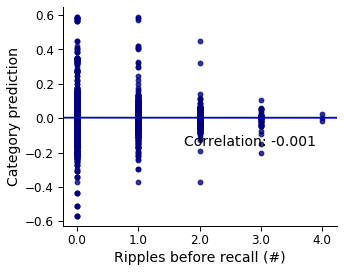

In [12]:
import seaborn as sb

key_bin = 0 # 0 # 2 for PRE bin. 0 for bin 1 second earlier

set_pubfig()
plot_df4 = pd.DataFrame({'ripple_array_by_recall':ripple_array_by_recall[:,key_bin],'pred_array_by_recall':pred_array_by_recall})

line_color = (0,0,0.8)
lmplot_color = (0,0,0.5) 
sb.lmplot(x='ripple_array_by_recall',y='pred_array_by_recall',data=plot_df4,
         scatter_kws = {'color': lmplot_color},line_kws = {'color': line_color},
         size=4,aspect=1.25)

# gca().set(ylim=(0,0.85),xlim=(1.5,5.5))
gca().tick_params(labelsize=12)
# gca().set(xlim=(2,5))
plot_corr = np.corrcoef(ripple_array_by_recall[:,key_bin],pred_array_by_recall)[0][1]
annotate('Correlation: '+str(np.round(plot_corr,3)),(3.5,-0.16))
ylabel(u'Category prediction')
xlabel('Ripples before recall (#)')
xticks(np.arange(0,8.1,2),np.arange(0,4.1))
gcf().tight_layout()

ripple_hist = np.histogram(ripple_array_by_recall[:,key_bin],bins=5)[0]
print(str(len(pred_array_by_recall))+' recalls')
print('Ripples in each bin: '+str(ripple_hist))
a=1;

## What about SWR ripple_durations?! Expect longer = better memory
## (load surrounding_recall and get start_array/subject_name_array first)

Total ripples: 7006


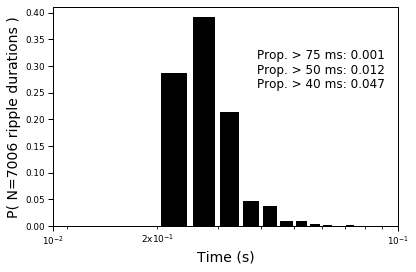

[0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.06
 0.065 0.07  0.075 0.08  0.085 0.09  0.095 0.1  ]


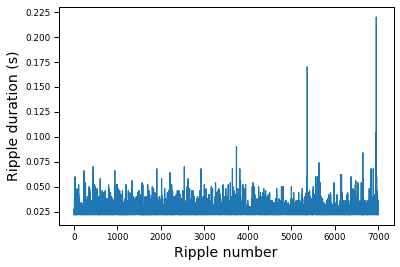

In [163]:
# get ripple_durations and plot distribution

save_plot = 1

set_pubfig()
ripple_durations = []
ripple_midpoints = []
subject_name_array_by_ripple = []
session_name_array_by_ripple = []
for trial in range(start_array.shape[0]):
    starts = np.array(np.where(start_array[trial]))
    ends = np.array(np.where(end_array[trial]))
    ripple_durations = np.append(ripple_durations,ends-starts)
    ripple_midpoints = np.append(ripple_midpoints,starts+(ends-starts)/2)
    # tile by number of ripples
    ripples_this_trial = len(starts[0])
    subject_name_array_by_ripple.extend(np.tile(subject_name_array[trial],ripples_this_trial))
    session_name_array_by_ripple.extend(np.tile(session_name_array[trial],ripples_this_trial))
subject_name_array_by_ripple = np.array(subject_name_array_by_ripple)
session_name_array_by_ripple = np.array(session_name_array_by_ripple)
    
ripple_durations = ripple_durations*sr_factor/1000 # convert to s
ripple_durations = ripple_durations[ripple_durations>0.02]
print('Total ripples: '+str(len(ripple_durations)))

start_value = 0.0025
end_value = 0.1
bin_size = 0.1/20
# for linear plot
# plotHistoBar(ripple_durations,start_value,end_value,0.005,tick_range_divisor=5,normalize=True,log_scale=False)

# for log plot
bins = np.arange(start_value,end_value+bin_size+bin_size/1000,bin_size) # added bin+0.001 to show last bin and last tick
hist = np.histogram(ripple_durations,bins)
yvalues = hist[0]/sum(hist[0]) # normalize
xr = (bins[1:]+bins[:-1])/2
ax = plt.bar(xr+bin_size/2,yvalues,width=0.8*bin_size,color='k')
xscale('log')
xlim(0.01,0.1)
xticks([0.01,0.1])
xscale('log', subsx=range(12)) # sets number of xticks. Dunno why we need 12 to get 10

xlabel('Time (s)')
ylabel('P( N='+str(len(ripple_durations))+' ripple durations )')
max_hist = np.max(yvalues)
text_x = 0.039
text(text_x,0.8*max_hist,'Prop. > 75 ms: '+str(np.round(sum(ripple_durations>=0.075)/len(ripple_durations),3)),fontsize=12)
text(text_x,0.73*max_hist,'Prop. > 50 ms: '+str(np.round(sum(ripple_durations>=0.05)/len(ripple_durations),3)),fontsize=12)
text(text_x,0.66*max_hist,'Prop. > 40 ms: '+str(np.round(sum(ripple_durations>=0.04)/len(ripple_durations),3)),fontsize=12)
text(0.018,-0.031,'2x$10^{-1}$',fontsize=9)

tight_layout()

if save_plot == 1:
    plt.savefig('../figures/durations/'+exp+'_'+'Durations_'+region_name+'-'+location_selected+'_'+str(recall_type_switch)+\
                '_'+filter_type+'.pdf',transparent=True) 

show()
plot(ripple_durations)
xlabel('Ripple number')
ylabel('Ripple duration (s)')
print(xr);


In [14]:
start_array.shape

(7704, 2000)

In [182]:
# what about ripple_durations of ripples in the PSTH? Are they longer just before recall?
# could be clever and use time of peak power but makes just as much sense to use midpoint
import statsmodels.formula.api as smf

bin_size = 0.1
smoothing_triangle = 5

# get midpoint list from for loop above
corrected_ripple_midpoints = (ripple_midpoints*sr_factor+-2000)/1000 # convert to s and adjust to offset
bins = np.arange(-2,2+bin_size+bin_size+0.001,bin_size)
xr = (bins[1:]+bins[:-1])/2

# Could also plot durations at each time bin (note >40 ms analysis removed as of 2020-07-17)
mean_durations_by_bin = []
se_durations_by_bin = []
number_ripples_in_bin = []
mean_values = []
bin_CIs = []
for bin in bins[:-3]:
    # get indices for times in each bin so can grab durations
    ripples_in_bin_mask = [(corrected_ripple_midpoints>=bin) & (corrected_ripple_midpoints<bin+bin_size)]
    durations_in_bin = ripple_durations[ripples_in_bin_mask]
    number_ripples_in_bin.append(len(durations_in_bin))
    mean_durations_by_bin.append(np.mean(durations_in_bin))
    se_durations_by_bin.append(np.std(durations_in_bin)/np.sqrt(len(durations_in_bin)))
    
    # let's properly get CIs for each bin
    bin_session = session_name_array_by_ripple[ripples_in_bin_mask] # already have ripples for this bin, get sub and sess identifiers
    bin_subject = subject_name_array_by_ripple[ripples_in_bin_mask]
    CI_df = pd.DataFrame(data={'session':bin_session,'subject':bin_subject,'durations':durations_in_bin})
    vc = {'session':'0+session'}
    get_bin_CI_model = smf.mixedlm("durations ~ 1", CI_df, groups="subject", vc_formula=vc)
    bin_model = get_bin_CI_model.fit(reml=False, method='nm')
    mean_values.append(bin_model.params.Intercept)
    bin_CIs = superVstack(bin_CIs,bin_model.conf_int().iloc[0].values)
# get CI distances at each bin by subtracting from means
CI_plot = np.array(bin_CIs.T)
CI_plot[0,:] = mean_values - CI_plot[0,:] # - difference to subtract from PSTH
CI_plot[1,:] = CI_plot[1,:] - mean_values # + difference to add to PSTH
    
# triangle smooth
smoothed_mean_duration = triangleSmooth(mean_durations_by_bin,smoothing_triangle)

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.

In [183]:
bins[4]
min(corrected_ripple_midpoints)
max(corrected_ripple_midpoints)

-1.5999999999999996

-1.99

1.987

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.

0.029519760479041916
0.029035973653099144


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Intercept      0.028767
bin[T.4]       0.000362
session Var    0.039455
dtype: float64
Test 0 p-value: 0.12078799319718105
0.028557037037037044
0.028866449511400653


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Intercept      0.028249
bin[T.32]      0.000259
session Var    0.036861
dtype: float64
Test 1 p-value: 0.3021040072286676


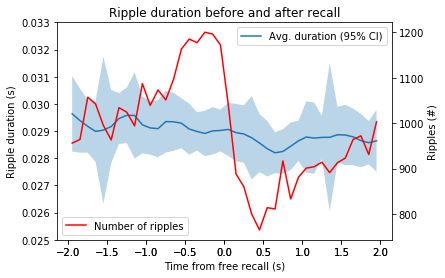

In [185]:
# stats on key bins
stats_bin = 5 # width of test (in bins)
PSTH_start = -2000

# going to make sequence of 3 bins and test 1st v. 3rd 
first_start = 4  # -1600 so will be -1600:-1100 v. -600:-100 with stats_bin=5
second_start = 22 # same idea starting at 200


for test in range(2):
    durations = []
    session_name = []
    subject_name = []
    bin_label = []    
    if test == 0:
        bin_starts = [first_start,first_start+10] # first bin at -1600:-1100 and second a second later
    else:
        bin_starts = [second_start,second_start+10] # same idea
    
    # now, to set up ME pairwise stats, append each time_bin to bottom and duplicate
    for time_bin in bin_starts: 
        ripples_in_bin_mask = [(corrected_ripple_midpoints>=bins[time_bin]) & (corrected_ripple_midpoints<(bins[time_bin+stats_bin]))]
        print(np.mean(ripple_durations[ripples_in_bin_mask]))
        durations.extend(ripple_durations[ripples_in_bin_mask])
        session_name.extend(session_name_array_by_ripple[ripples_in_bin_mask])
        subject_name.extend(subject_name_array_by_ripple[ripples_in_bin_mask])
        bin_label.extend(np.tile(str(time_bin),sum(ripples_in_bin_mask)))
    
    bin_df = pd.DataFrame(data={'session':session_name,'subject':subject_name,
                               'bin':bin_label,'durations':durations})
    vc = {'session':'0+session'}
    sig_bin_model = smf.mixedlm("durations ~ bin", bin_df, groups="subject", vc_formula=vc)
    bin_model = sig_bin_model.fit(reml=False, method='nm')
    print(bin_model.params)
    print('Test '+str(test)+' p-value: '+str(bin_model.pvalues[1]))

# plot
fig1 = figure()
ax1 = fig1.add_subplot(111)
line1 = plot(xr[:-2],smoothed_mean_duration)
fill_between(xr[:-2], smoothed_mean_duration-CI_plot[0,:], smoothed_mean_duration+CI_plot[0,:], alpha = 0.3)
ax1.set_ylim(0.025,0.033)
ylabel('Ripple duration (s)')
xlabel('Time from free recall (s)')
title('Ripple duration before and after recall')
# second axis
ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
line2 = ax2.plot(xr[:-2],number_ripples_in_bin, 'r-')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ylabel('Ripples (#)')
ax1.legend(line1,{"Avg. duration (95% CI)"})
ax2.legend(line2,{"Number of ripples"},loc='lower left');

In [174]:
bin_model.params

Intercept      0.028249
bin[T.32]      0.000259
session Var    0.036861
dtype: float64

## SWRs by time in retrieval period

In [21]:
# going to have to grab chunks of ripplearray for each FR for early/mid/late 10 s of retrieval
# make sure to add 2000 since start_array2 is 30 s with 2 s buffers on either side in order to grab 2 s before/after FR

retrieval_periods = ['early','late'] # 'early' only if want to see full 30 s period (should replicate the full PSTH)
IRI = 2000
psth_start = -IRI 
psth_end = IRI

retrieval_whole_time = int(30000*(4-len(retrieval_periods)))
third_of_retrieval_ms = retrieval_whole_time/len(retrieval_periods)
early_array = []; middle_array = []; late_array = []
test = []
for trial in range(start_array2.shape[0]):
    for i,retrieval_period in enumerate(retrieval_periods):
        # for each trial get the FRs in each of the 3 slices of the retrieval period
        time_slice_tercile = range(int(third_of_retrieval_ms*(i)),int(third_of_retrieval_ms*(i+1)))
        time_slice_recalls = np.where(fr_array[trial,time_slice_tercile])[0] # gets the times within this third (so for tercile from [0,10000])
        for time_slice_recall in time_slice_recalls:
            # this time is in ms from start of each retrieval slice...convert to samples since start_array2 in samples
            raster_surrounding_recall = range( int(np.ceil((psth_start+time_slice_recall-psth_start)/sr_factor)),
                                               int(np.ceil((psth_end+time_slice_recall-psth_start)/sr_factor)) )
#             test.append(min(raster_surrounding_recall))
            # for every trial, take every +/- 2000 ms around every recall and append it onto the respective retrieval_period 
            if retrieval_period=='early':
                early_array = superVstack(early_array,start_array2[trial,raster_surrounding_recall])
            elif retrieval_period=='middle':
                middle_array = superVstack(middle_array,start_array2[trial,raster_surrounding_recall])
            elif retrieval_period=='late':
                late_array = superVstack(late_array,start_array2[trial,raster_surrounding_recall])
print('Done retrieving arrays')

NameError: name 'start_array2' is not defined

In [86]:
sum(fr_array)
retrieval_periods = ['early','late']

24755.0

In [89]:
## try this another way, where we take halfway point of all recalls and split into two

# find recall time that divides the recall times in half
all_recall_times = []
for row in fr_array:
    all_recall_times.extend(np.where(row)[0])
sorted_recall_times = np.sort(all_recall_times)
halfway_recall_time = sorted_recall_times[int(len(sorted_recall_times)/2)]+1
print('Halfway recall time is: '+str(halfway_recall_time))
early_time_range = range(0,halfway_recall_time)
late_time_range = range(halfway_recall_time,fr_array.shape[1])

early_array = []; late_array = []
for trial in range(start_array2.shape[0]):
    early_row_recalls = np.where(fr_array[trial,early_time_range])[0] 
    late_row_recalls = np.where(fr_array[trial,late_time_range])[0]   
    #import ipdb; ipdb.set_trace()
    for recall in early_row_recalls:
        # this time is in ms from start of each retrieval slice...convert to samples since start_array2 in samples
        raster_surrounding_recall = range( int(np.ceil((psth_start+recall-psth_start)/sr_factor)),
                                           int(np.ceil((psth_end+recall-psth_start)/sr_factor)) )
        # for every trial, take every +/- 2000 ms around every recall and append it onto the respective retrieval_period 
        early_array = superVstack(early_array,start_array2[trial,raster_surrounding_recall])
    for recall in late_row_recalls:
        raster_surrounding_recall = range( int(np.ceil((psth_start+recall-psth_start)/sr_factor)),
                                           int(np.ceil((psth_end+recall-psth_start)/sr_factor)) )
        late_array = superVstack(late_array,start_array2[trial,raster_surrounding_recall])

Halfway recall time is: 7021


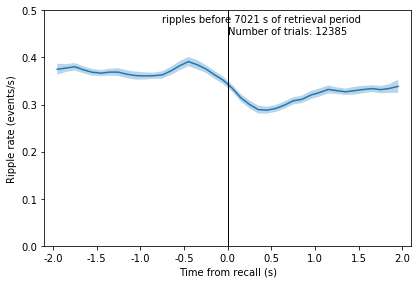

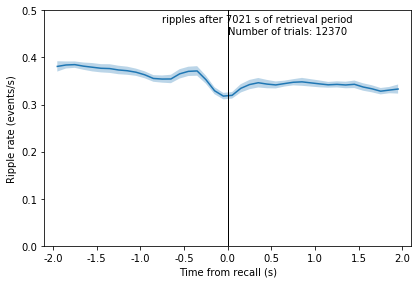

In [91]:
# what about where in retrieval period? I think best way to look at this
# will be to divide retrieval period into early, middle, and late and 
# make SWR PSTHs for each of these periods

for retrieval_period in retrieval_periods:
    if retrieval_period=='early':
        temp_start_array = early_array
#     elif retrieval_period=='middle':
#         temp_start_array = middle_array
    elif retrieval_period=='late':
        temp_start_array = late_array
    # make a PSTH based on start times of SWRs
    binsize = 100 # in ms
    smoothing_triangle = 5 # triangular smoothing window width
    samples = 25
    pad = int(np.floor(smoothing_triangle/2)) # factor is how many points from middle does triangle go?

    PSTH,bin_centers = fullPSTH(temp_start_array,binsize,smoothing_triangle,sr,psth_start)
    # bootstraps error bars by sampling from trials in raster with replacement samples number of
    # times and then taking the standard deviation across those samples
    boot_samples = bootstrap(temp_start_array, bootnum=samples, samples=None, # bootstrap error bars using resampling
                   bootfunc=lambda x: bootPSTH(x,binsize,smoothing_triangle,sr,psth_start))
    boot_SD = np.std(boot_samples,0)

    subplots(1,1,figsize=(6,4))
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)
    #plot(xr,norm_count[0]) # actual data
    plot(xr,PSTH)
    fill_between(xr, PSTH+boot_SD, PSTH-boot_SD, alpha = 0.3)
    xticks(np.arange(psth_start,psth_end+1,500),np.arange(psth_start/1000,psth_end/1000+1,500/1000))
    xlabel('Time from recall (s)')
    ylabel('Ripple rate (events/s)')
    tight_layout()
    ax = plt.gca()
    ylim = 0.5
    ax.set_ylim(0,ylim)
    ax.set_xlim(psth_start-100,psth_end+100)
    plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0));
    if retrieval_period == 'early':
        text(-750,0.475,'ripples before '+str(halfway_recall_time)+' s of retrieval period') #+retrieval_period+' 10 s of 30 s retrieval period')
        text(0,0.45,'Number of trials: '+str(early_array.shape[0]))
    else:
        text(-750,0.475,'ripples after '+str(halfway_recall_time)+' s of retrieval period')
        text(0,0.45,'Number of trials: '+str(late_array.shape[0]))
    plt.show()
a=1;

## Do we see more SWRs during successful encoding? (come here after loading 'encoding')

In [346]:
# get start_array and masks to identify SME

desired_sample_rate = 500.
sr = desired_sample_rate # fixed at this value since this is the minimum across data and can always downsample
sr_factor = 1000/desired_sample_rate

start_array_enc,end_array_enc = getStartEndArrays(ripple_array); print('Got encoding start_array!')

# get vectors of encoding list identifier data for forgotten and recalled words
master_key = []
serial_positions = []
for i,enc_words in enumerate(encoded_word_key_array):
    serial_positions.extend(serialpos_array[i])
    master_key.extend(enc_words)
master_key = np.array(master_key); serial_positions = np.array(serial_positions)
start_array_enc_forgot = start_array_enc[master_key==0]
start_array_enc_recalled = start_array_enc[master_key==1]
# same for sub and sess
subject_name_array,session_name_array = getSubSessPredictors(sub_names,sub_sess_names,trial_nums)
sub_forgot = np.array(subject_name_array)[master_key==0]
sess_forgot = np.array(session_name_array)[master_key==0]
sub_recalled = np.array(subject_name_array)[master_key==1]
sess_recalled = np.array(session_name_array)[master_key==1]

Got encoding start_array!


done making binned start_array with shape:
(5992, 26)


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


CIs created!
done making binned start_array with shape:
(74915, 26)
CIs created!
Test 0 p-value: 0.003327452069429007
Test 1 p-value: 0.19989236445447245


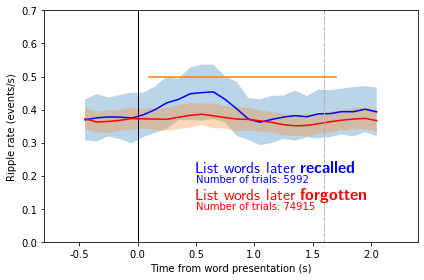

In [347]:
%autoreload
# get PSTH for recalled and then forgotten words. 
# Then bin it for the CIs and plot each
# then do ME stats on seleted bins and add significance bars if p<0.05

encoding_time = 2300 # actual preentation is 1.6 s + 0.75-1.0 s so keep +700 ms so can plot +500 ms
pre_encoding_time = -700

bin_size = 100 # in ms
smoothing_triangle = 5 # triangular smoothing window width
samples = 100
pad = int(np.floor(smoothing_triangle/2)) # factor is how many points from middle does triangle go?

# for recalled and then forgotten words
for category in range(2):
    if category == 0:
        temp_start_array = start_array_enc_recalled
        subject_name_array = sub_recalled
        session_name_array = sess_recalled
        
        # for plot
        subplots(1,1,figsize=(6,4))
        label = 'List words later \\textbf{recalled}'
        plot_color = (0,0,1)
        text(500,0.21,label,usetex=True,size=16,color=plot_color)
        text(500,0.18,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color)

    else:       
        temp_start_array = start_array_enc_forgot
        subject_name_array = sub_forgot
        session_name_array = sess_forgot
        
        # for plot
        label = 'List words later \\textbf{forgotten}'        
        plot_color = (1,0,0)
        text(500,0.13,label,usetex=True,size=16,color=plot_color) 
        text(500,0.10,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color)
        
    # make a PSTH based on start times of SWRs

    PSTH,bin_centers = fullPSTH(temp_start_array,bin_size,smoothing_triangle,sr,pre_encoding_time)
    # bootstraps error bars by sampling from trials in raster with replacement samples number of
    # times and then taking the standard deviation across those samples
#     boot_samples = bootstrap(temp_start_array, bootnum=samples, samples=None, # bootstrap error bars using resampling
#                    bootfunc=lambda x: bootPSTH(x,binsize,smoothing_triangle,sr,pre_encoding_time))
#     boot_SD = np.std(boot_samples,0)

    # get binned start array (trials X bins)
    binned_start_array = binBinaryArray(temp_start_array,bin_size,sr_factor)
    binned_start_array = binned_start_array[:,pad:-pad] # remove edge bins
    print('done making binned start_array with shape:')
    print(binned_start_array.shape)

    # note that output is the net ± distance from mean
    CI_plot = getMixedEffectCIs(binned_start_array,subject_name_array,session_name_array)
    print('CIs created!')
    
    # plot
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)
    xr = xr[pad:-pad]; PSTH = PSTH[pad:-pad]; #boot_SD = boot_SD[pad:-pad]
    plot(xr,PSTH,color=plot_color)
    fill_between(xr, PSTH-CI_plot[0,:], PSTH+CI_plot[0,:], alpha = 0.3)
    xticks(np.arange(pre_encoding_time+pad*100,encoding_time-pad*100+1,500),
           np.arange((pre_encoding_time+pad*100)/1000,(encoding_time-pad*100)/1000+1,500/1000))
    xlabel('Time from word presentation (s)')
    ylabel('Ripple rate (events/s)')
    tight_layout()
    ax = plt.gca()
    ylim = 0.7
    ax.set_ylim(0,ylim)
    ax.set_xlim(pre_encoding_time-100,encoding_time+100)
    plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0))
    plot([1600,1600],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='--',color=(0.7,0.7,0.7))

# now that we have the plot with CIs, do stats on key bins. Note here just looking at single bins but comparing across categories
for test in range(2):
    if test == 0:
        first_start = 100 
        first_end = 1700
    else:
        first_start = 1700 # same idea but for post-encoding period (ILI)
        first_end = 2300 
        
    bin_test_range = range(int( ((first_start-pre_encoding_time)/sr_factor) ),
                           int( ((first_end-pre_encoding_time)/sr_factor) ))
    binned_recalled_array = start_array_enc_recalled[:,bin_test_range]
    binned_forgot_array = start_array_enc_forgot[:,bin_test_range]
    
    stats_bin = int(first_end-first_start)
    binned_recalled_array = binBinaryArray(binned_recalled_array,stats_bin,sr_factor) # should be creating vectors for both
    binned_forgot_array = binBinaryArray(binned_forgot_array,stats_bin,sr_factor)
    
    bin_model = MEstatsAcrossCategories(binned_recalled_array,binned_forgot_array,
                                        sub_forgot,sess_forgot,sub_recalled,sess_recalled)
    
        # plot bands of significance
    if bin_model.pvalues[1] < 0.05:
        plot([first_end-stats_bin,first_end],[0.5,0.5],color=(1,0.5,0))
    print('Test '+str(test)+' p-value: '+str(bin_model.pvalues[1]))
a = 1;

## encoding ripples by serial position

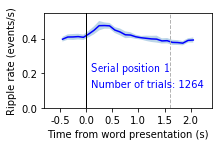

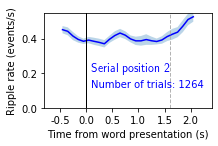

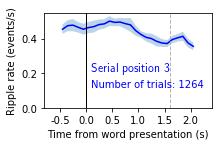

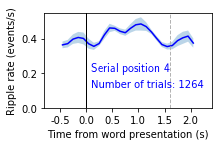

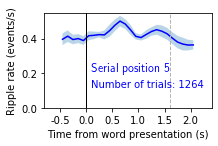

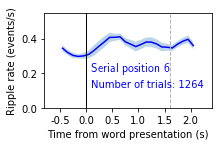

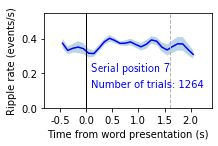

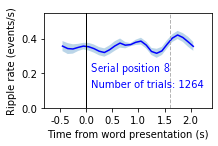

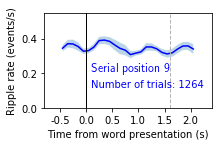

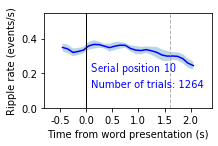

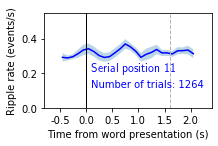

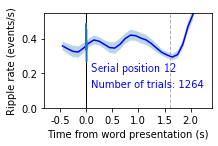

In [173]:
## plot recalled events by serial position

bin_range_to_compare = range(8,18) # this is 100:1100 ms 
# bin_range_to_compare = range(24,29) # this is 1700:2200 ms

ct = 0
serial_position_rem_rates = []
serial_q
position_rem_stds = []
serial_position_forgot_rates = []
serial_posiq
tion_forgot_stds = []
num_recalled = []; num_forgot = []
for list_num in range(12):
    
    temp_start_array_rem = start_array_enc[(master_key==1) & (serial_positions==(list_num+1))]
    temp_start_array_forgot = start_array_enc[(master_key==0) & (serial_positions==(list_num+1))]
    
    subplots(1,1,figsize=(3,1.75))
    label = 'Serial position '+str(list_num+1)
    plot_color = (0,0,1)
    text(100,0.21,label,usetex=True,size=12,color=plot_color)
    text(100,0.12,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color)
    ct+=temp_start_array.shape[0]    
    # make a PSTH based on start times of SWRs

    PSTH,bin_centers = fullPSTH(temp_start_array_rem,binsize,smoothing_triangle,sr,pre_encoding_time)
    PSTH_forgot,bin_centers = fullPSTH(temp_start_array_forgot,binsize,smoothing_triangle,sr,pre_encoding_time)
    
    # bootstraps error bars by sampling from trials in raster with replacement samples number of
    # times and then taking the standard deviation across those samples
    boot_samples = bootstrap(temp_start_array_rem, bootnum=samples, samples=None, # bootstrap error bars using resampling
                   bootfunc=lambda x: bootPSTH(x,binsize,smoothing_triangle,sr,pre_encoding_time))
    boot_SD = np.std(boot_samples,0)
    
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)
    
    # plot
    plot(xr[pad:-pad],PSTH[pad:-pad],color=plot_color)
    fill_between(xr[pad:-pad], (PSTH+boot_SD)[pad:-pad], (PSTH-boot_SD)[pad:-pad], alpha = 0.3)
    xticks(np.arange(pre_encoding_time+pad*100,encoding_time-pad*100+1,500),
           np.arange((pre_encoding_time+pad*100)/1000,(encoding_time-pad*100)/1000+1,500/1000))
    xlabel('Time from word presentation (s)')
    ylabel('Ripple rate (events/s)')
    ax = plt.gca()
    ylim = 0.55
    ax.set_ylim(0,ylim)
    ax.set_xlim(pre_encoding_time-100,encoding_time+100)
    plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0));
    plot([1600,1600],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='--',color=(0.7,0.7,0.7));
#     plot([ax.get_xlim()[0],ax.get_xlim()[1]],[0.4,0.4],linewidth=1,linestyle='--',color=(0.5,0.5,0.5));

    # save data for full serial position plot below
    serial_position_rem_rates.append(np.mean(PSTH[bin_range_to_compare]))
    serial_position_rem_stds.append(np.std(PSTH[bin_range_to_compare]))
    serial_position_forgot_rates.append(np.mean(PSTH_forgot[bin_range_to_compare]))
    serial_position_forgot_stds.append(np.std(PSTH_forgot[bin_range_to_compare]))
    num_recalled.append(temp_start_array_rem.shape[0])
    num_forgot.append(temp_start_array_forgot.shape[0])
plot(serial_position_rem_rates)    
a=1;

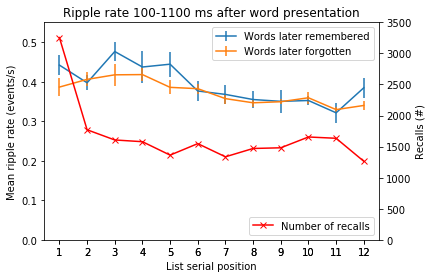

In [190]:
# create the general figure
fig1 = figure()
 
# and the first axes using subplot populated with data 
ax1 = fig1.add_subplot(111)

xr=np.arange(1,13)
line1 = errorbar(xr,serial_position_rem_rates,serial_position_rem_stds) 
line2 = errorbar(xr,serial_position_forgot_rates,serial_position_forgot_stds)
xticks(xr,xr)
ax1.set_ylim(0,ylim)
xlabel('List serial position')
ylabel('Mean ripple rate (events/s)')
if bin_range_to_compare == range(8,18):
    title('Ripple rate 100-1100 ms after word presentation')
elif bin_range_to_compare == range(24,29): 
    title('Ripple rate 1700-2200 ms after word presentation')
    
# now, the second axes that shares the x-axis with the ax1
ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
line3 = ax2.plot(xr,num_recalled, 'xr-')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylim(0,3500)
ylabel("Recalls (#)")

ax1.legend((line1,line2),("Words later remembered","Words later forgotten"))
ax2.legend(line3,{"Number of recalls"},loc='lower right')
 
# for the legend, remember that we used two different axes so, we need 
# to build the legend manually
# legend((line1, line2), ("1", "2"))
show();

## let's look at some of these SWR traces! 

/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1345D/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1345D/tal/R1345D_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/timeseries.py:364: UserWarning: The filtered method is not very flexible. Consider using filters in ptsa.data.filters instead.
  warnings.warn("The filtered method is not very flexible. "


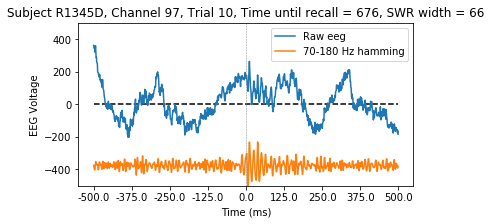

In [51]:
# Need to load start_array for given sub_df with your session first 
# MAKE SURE YOU SET TO 0 to get every trial or it won't align! Also make sure using all HPC and not a subfield via location_selected

# start_array is recall_events X time with binary 1 for start of each detected SWR

%autoreload
from ptsa.data.filters import ButterworthFilter
from scipy.signal import firwin,filtfilt

which_session = 0 # select from the df
which_channel = 97 # 83
first_trial = 10
trials_to_print = 1 # note: will skip trials with no ripples

# to get right events
recall_type_switch = 0
IRI = 2000
recall_minimum = 2000

desired_sample_rate = 500. # even if SR is >500 for eeg the desired rate for the ripple arrays was set to 500
desired_sr_factor = int(1000/desired_sample_rate) # sr_factor is defined below via eeg sr_factor
trans_width = 5.
psth_start = -2000
psth_end = 2000

# bb,aa = butter(2,[70/250,180/250],btype='band') # Butterworth test filter

temp_sub_df = sub_df[0:which_session+1] 
array_trial_offset = int(np.sum(trial_nums[:which_session]))
temp_sub_df

pre_rip = -500 # plots this many ms before and after the ripple
post_rip = 500

ymin = -500 #np.min(stim_eeg[trial,:])
ymax = 500 #np.max(stim_eeg[trial,:])
display_mult = 2 # increase 80-120 Hz by this factor to see it better on graph
y_offset = -ymax/2 # move 80-120 filtered band down for visualization purposes

yr = np.arange(ymin,ymax)
num_ripples = np.sum(start_array)

trial_ct = 0; print_ct = 0
for row in temp_sub_df.itertuples():
    # get bipolar pairs
    sub = row.subject; mont = int(row.montage); loc = int(row.localization)
    exp = row.experiment; session = int(row.session)
    reader = CMLReadDFRow(row)
    evs = reader.load('task_events')
    # get localizations (region info)
    pairs = reader.load('pairs')
    try:
        localizations = reader.load('localization')
    except:
        localizations = []
    
    ### get evs_free_recall like above
    evs_free_recall = evs[(evs.type=='REC_WORD') & (evs.recalled==True)] # recalled word AND correct (from this list...no instrusions).        
    word_evs = evs[evs['type']=='WORD'] # get words 

    # select which recalls??         
    [recall_selection_name,selected_recalls_idxs] = selectRecallType(recall_type_switch,evs_free_recall,IRI,recall_minimum)     

    _,nonrepeat_indicator = removeRepeatedRecalls(evs_free_recall,word_evs) # remove free recalls that happened more than once

    # let's make sure remaining recalls are not repeated, have eeg, and are not from non-practice lists
    good_recalls = selected_recalls_idxs & (nonrepeat_indicator>0) & np.array(evs_free_recall.eegoffset>-1) & np.array(evs_free_recall.list > -1)
    evs_free_recall = evs_free_recall[good_recalls]
    ###
    
    tal_struct, bipolar_pairs, mpchans = get_bp_tal_struct(sub, montage=mont, localization=loc)
    elec_regions,atlas_type,pair_number,has_stein_das = get_elec_regions(localizations,pairs)      
    
    eeg = reader.load_eeg(events=evs_free_recall, rel_start=psth_start, rel_stop=psth_end, clean=True, scheme=pairs)
    eeg_sr = eeg.samplerate
    
    ntaps = (2/3)*np.log10(1/(10*(1e-3*1e-4)))*(eeg_sr/trans_width)
    FIR_filter = firwin(int(ntaps+1), [70.,180.], fs=eeg_sr, window='hamming',pass_zero='bandpass')
    
    sr_factor = 1000/eeg_sr
    xr = np.arange(0,(post_rip-pre_rip)/sr_factor)
    eeg_ptsa = eeg.to_ptsa()
    eeg_ptsa = eeg_ptsa.baseline_corrected((psth_start,psth_end))
    eeg_vaz = eeg_ptsa.filtered([80.,120.], filt_type='bandpass', order=2) # Butterworth 2nd order a la Vaz/Zaghloul
    eeg_norman = filtfilt(FIR_filter,1.,eeg_ptsa) 
#     eeg_butter_70180 = filtfilt(bb,aa,eeg_ptsa) # test Butterworth with 70-180 Hz...like combining two methods
#     eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[58.,62.], filt_type='stop', order=4).filter()
    
    for channel in range(len(elec_regions)):
        if channel == which_channel:
#         if elec_regions[channel] in HPC_labels:
            for trial in range(len(evs_free_recall)): # maximum trials is # elecs * recall_events
                if trial_ct >= (first_trial) and print_ct<trials_to_print:
                    if np.sum(start_array[trial_ct+array_trial_offset])>0: # if there is a ripple in this trial
                        rip_times = (np.array(np.where(start_array[trial_ct]))*desired_sr_factor)[0] # convert to ms since was set to 500 Hz
                        rip_durations = ((desired_sr_factor*np.array(np.where(end_array[trial_ct])))-rip_times)[0]
                        for rip in range(len(rip_times)): # get each ripple 
                            rip_time = rip_times[rip]
                            rip_length = rip_durations[rip]
                            #print(str(rip_time+psth_start))
                            # note: any time dealing with eeg, need to account for sampling rate (see all the sr_factors)
                            if rip_time>abs(pre_rip) and rip_time<(eeg_ptsa.shape[2]*sr_factor-abs(post_rip)): # if enough time before/after ripple to plot

                                stim_eeg = eeg_ptsa[trial_ct,channel,int((rip_time+pre_rip)/sr_factor):int((rip_time+post_rip)/sr_factor)]
#                                 filt_eeg_vaz = eeg_vaz[trial_ct,channel,int((rip_time+pre_rip)/sr_factor): # eeg_butter_70180
#                                                                 int((rip_time+post_rip)/sr_factor)]
                                filt_eeg_norman = eeg_norman[trial_ct,channel,int((rip_time+pre_rip)/sr_factor):
                                                             int((rip_time+post_rip)/sr_factor)]
                                plt.figure(figsize=(6, 3)) 
                                ax = plt.subplot(111)
                                plt.plot(xr,stim_eeg)
#                                 plt.plot(xr,display_mult*filt_eeg_vaz+y_offset)
#                                 import ipdb; ipdb.set_trace()
                                plt.plot(xr,display_mult*filt_eeg_norman+y_offset*3/2)
                                plt.ylabel('EEG Voltage'); plt.xlabel('Time (ms)')
                                plt.plot(abs(pre_rip/sr_factor)*np.ones(len(yr)),yr,marker='',linewidth=0.5,linestyle='--',color=[0.5,0.5,0.5])
                                plt.legend(['Raw eeg','70-180 Hz hamming']) # '80-120 Hz butterworth'
                                plt.title('Subject '+sub+', Channel '+str(channel)+', Trial '+str(trial_ct)+', Time until recall = '
                                          +str(rip_time+psth_start)+', SWR width = '+str(rip_length))
                                plt.xticks(np.arange(0,post_rip-pre_rip+1,post_rip/4),np.arange(pre_rip,post_rip+1,post_rip/4))
                                ax.set_ylim([ymin,ymax])
                                plt.hlines(0,xr[0],xr[-1], linestyle='--', color='k')
                                print_ct+=1
                trial_ct+=1 # keep track of which trial we're on out of total ELEC X RECALL trials
a=1;

(19, 107, 4000)

<Figure size 864x360 with 0 Axes>

Text(0, 0.5, 'EEG Voltage')

Text(0.5, 0, 'Time (ms)')

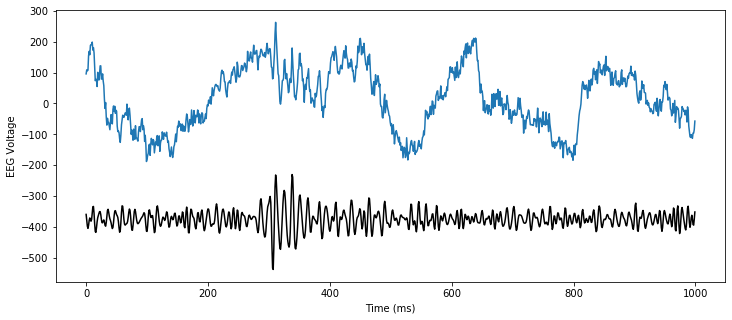

In [52]:
# plotting sandbox Fig. 4

# for Fig. 4g and 1b:
# R1345D, session 0, ch 97, trial 10, recall_type = 0, False for location_selected 
# R1345D, session 0, ch 98, trial 9, single with something looking like it beforehand

offset = 200 # offset from Time = 0
eeg_ptsa.shape

stim_eeg = eeg_ptsa[first_trial,which_channel,int((rip_time+pre_rip+offset)/sr_factor):int((rip_time+post_rip+offset)/sr_factor)]
filt_eeg_norman = eeg_norman[first_trial,which_channel,int((rip_time+pre_rip+offset)/sr_factor):
                             int((rip_time+post_rip+offset)/sr_factor)]
plt.figure(figsize=(12, 5)) 
ax = plt.subplot(111)
plt.plot(xr,stim_eeg)
plt.plot(xr,display_mult*filt_eeg_norman+y_offset*3/2,'k')
plt.ylabel('EEG Voltage'); plt.xlabel('Time (ms)')

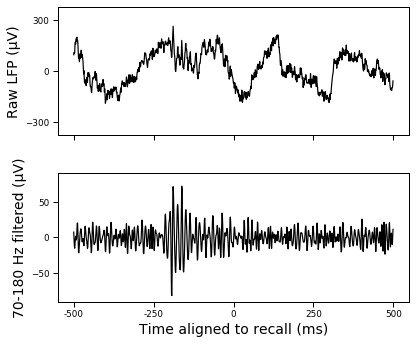

In [63]:
# plotting sandbox Fig. 1b

set_pubfig()

offset = 200 # offset from Time = 0
eeg_ptsa.shape

stim_eeg = eeg_ptsa[first_trial,which_channel,int((rip_time+pre_rip+offset)/sr_factor):int((rip_time+post_rip+offset)/sr_factor)]
filt_eeg_norman = eeg_norman[first_trial,which_channel,int((rip_time+pre_rip+offset)/sr_factor):
                             int((rip_time+post_rip+offset)/sr_factor)]
plt.figure(figsize=(6, 5)) 
ax = plt.subplot(211)
plt.plot(xr,stim_eeg,'k')
plt.ylabel('Raw LFP (μV)')
xticks(np.arange(0,post_rip-pre_rip+1,250),[])
yticks(np.arange(-300,301,300))
ax.set_ylim(-375,375)

ax = plt.subplot(212)
# plt.plot(xr,display_mult*filt_eeg_norman+y_offset*3/2,'k')
plt.plot(xr,filt_eeg_norman,'k')
plt.ylabel('70-180 Hz filtered (μV)'); plt.xlabel('Time aligned to recall (ms)')
xticks(np.arange(0,post_rip-pre_rip+1,250),np.arange(pre_rip,post_rip+1,250))
ax.set_ylim(-90,90)
tight_layout()

plt.savefig('../figures/spectrograms/Fig1b_example_filtering_R1345D.pdf',transparent=True);

## What about visualizing IED events?

array([0, 0, 4, ..., 2, 2, 0], dtype=uint64)

(2379, 2000)

500

(80, 2300)

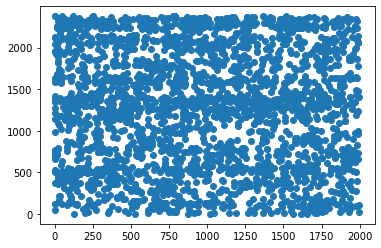

In [126]:
scatter(np.where(start_array)[1],np.where(start_array)[0])
np.sum(start_array,1)
start_array.shape
sr
iedlogic.shape

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1112M/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1112M/tal/R1112M_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1112M/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1112M/eeg.noreref/R1112M_FR1_0_01Dec15_1545.params.txt
/data/eeg/R1112M/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePath

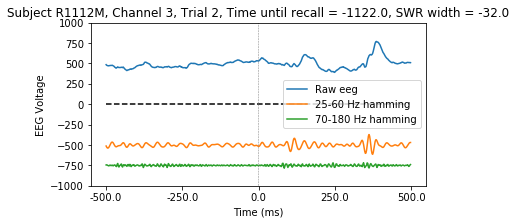

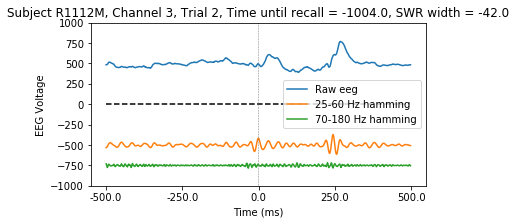

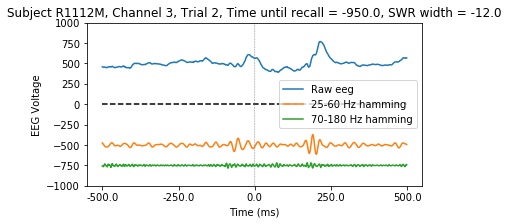

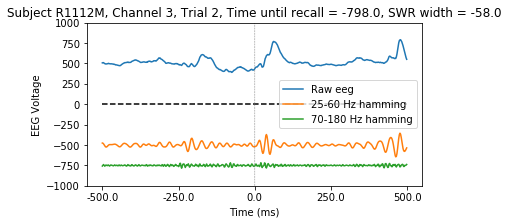

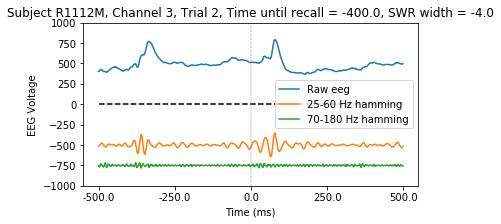

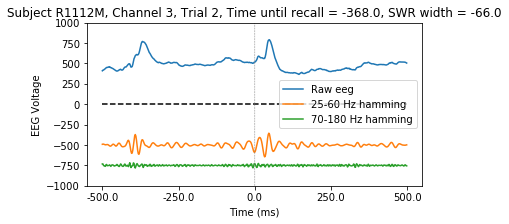

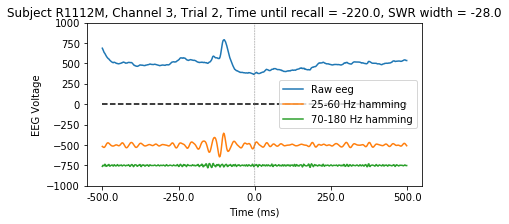

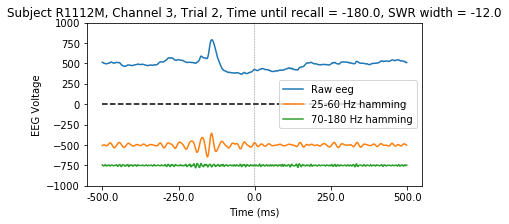

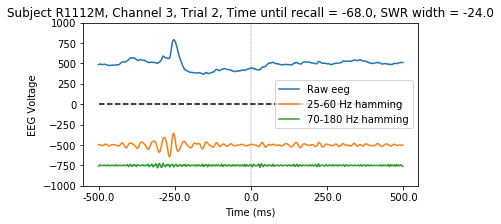

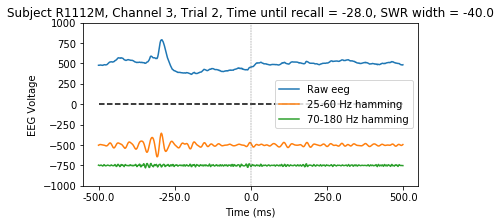

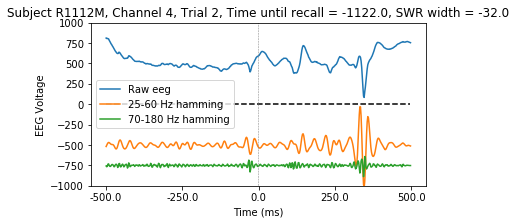

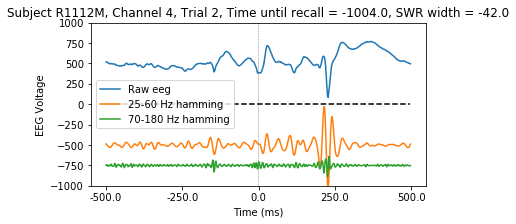

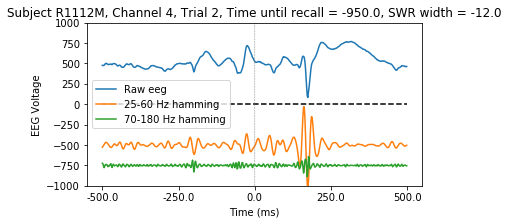

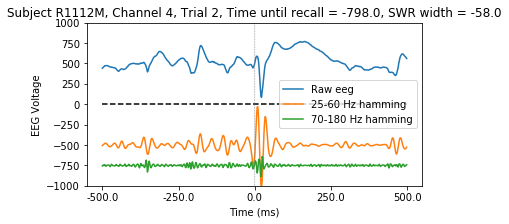

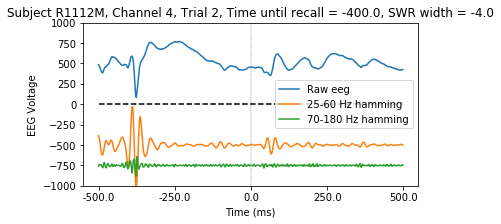

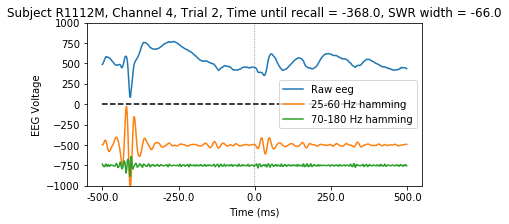

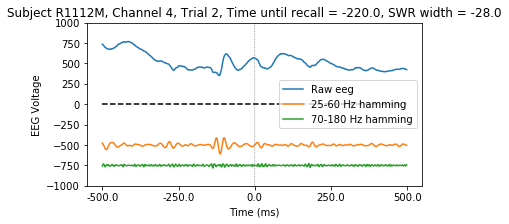

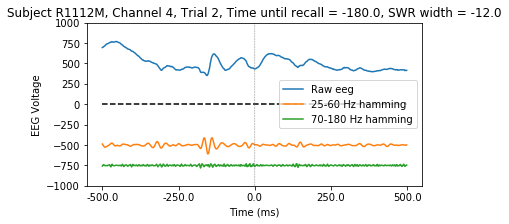

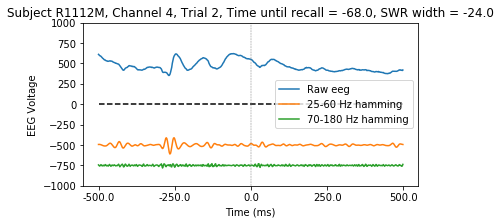

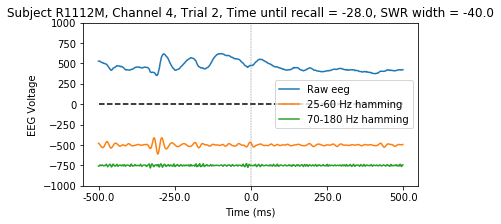

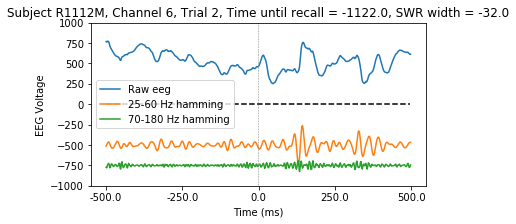

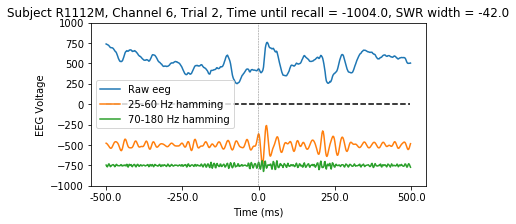

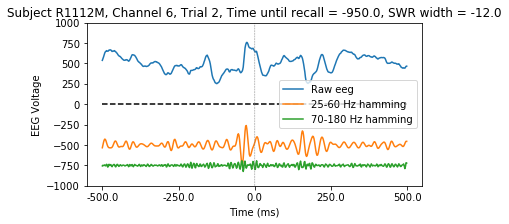

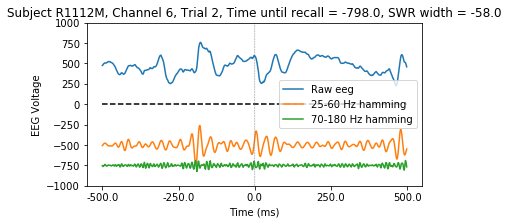

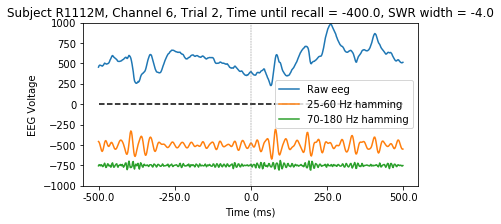

In [66]:
# create a start_array for IED array

desired_sample_rate = 500.
# iedlogic = downsampleBinary(iedlogic,sr/desired_sample_rate)
start_array,end_array = getStartEndArrays(iedlogic)

sr = desired_sample_rate # fixed at this value since this is the minimum across data and can always downsample
desired_sr_factor = 1000/desired_sample_rate

%autoreload
from ptsa.data.filters import ButterworthFilter
from scipy.signal import firwin,filtfilt

which_session = 0 # select from the df
first_trial = 0
trials_to_print = 25 # note: will skip trials with no ripples

display_mult_ied = 3 # display IED multiplier
display_mult_rip = 5

pre_rip = -500 # plots this many ms before and after the ripple
post_rip = 500
trans_width = 5.
temp_sub_df = sub_df[0:which_session+1] 
array_trial_offset = int(np.sum(trial_nums[:which_session]))
temp_sub_df

ymin = -1000 #np.min(stim_eeg[trial,:])
ymax = 1000 #np.max(stim_eeg[trial,:])
y_offset = -ymax/2 # move 80-120 filtered band down for visualization purposes

yr = np.arange(ymin,ymax)
num_ripples = np.sum(start_array)

trial_ct = 0; print_ct = 0
for row in temp_sub_df.itertuples():
    # get bipolar pairs
    sub = row.subject; mont = int(row.montage); loc = int(row.localization)
    exp = row.experiment; session = int(row.session)
    reader = CMLReadDFRow(row)
    evs = reader.load('task_events')
    pairs = reader.load('pairs')
    evs_free_recall = evs[evs.type=='REC_WORD']
    # remove events with Inter-Recall Intervals too small. Use start time since that's what will show in PSTH
    evs_free_recall = evs_free_recall[np.append(True,np.diff(evs_free_recall.mstime)>IRI)] #abs(start))]
    tal_struct, bipolar_pairs, mpchans = get_bp_tal_struct(sub, montage=mont, localization=loc)
    elec_regions,_ = get_elec_regions(tal_struct)      
    
    eeg = reader.load_eeg(events=evs_free_recall, rel_start=psth_start, rel_stop=psth_end, clean=True, scheme=pairs)
    eeg_sr = eeg.samplerate
    
    ntaps = (2/3)*np.log10(1/(10*(1e-3*1e-4)))*(eeg_sr/trans_width)
    FIR_filter = firwin(int(ntaps+1), [70.,180.], fs=eeg_sr, window='hamming',pass_zero='bandpass')
    bandpass_25_60 = firwin(int(ntaps+1), [25.,60.], fs=eeg_sr, window='hamming',pass_zero='bandpass')
    
#     sr_factor = 1000/eeg_sr
    xr = np.arange(0,(post_rip-pre_rip)/desired_sr_factor)
    eeg_ptsa = eeg.to_ptsa()
    eeg_ptsa = eeg_ptsa.baseline_corrected((psth_start,psth_end))
#     eeg_vaz = eeg_ptsa.filtered([80.,120.], filt_type='bandpass', order=2) # Butterworth 2nd order a la Vaz/Zaghloul
    ied_norman = filtfilt(bandpass_25_60,1.,eeg_ptsa)
#     ied_vaz = ButterworthFilter(timeseries=eeg_ptsa, freq_range=200., filt_type='highpass',order=2).filter()
    eeg_norman = filtfilt(FIR_filter,1.,eeg_ptsa) 
#     eeg_butter_70180 = filtfilt(bb,aa,eeg_ptsa) # test Butterworth with 70-180 Hz...like combining two methods
#     eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[58.,62.], filt_type='stop', order=4).filter()
    
    for channel in range(len(elec_regions)):
        if elec_regions[channel] in HPC_labels:
            for trial in range(np.shape(start_array)[0]): # maximum trials is # elecs * recall_events
                rip_times = np.where(start_array[trial])[0]*desired_sr_factor # times in ms
                rip_ends = np.where(end_array[trial])[0]*desired_sr_factor
                if sum(rip_times)>0:
                    for i,rip_time in enumerate(rip_times):
                        if print_ct<trials_to_print:
    #                     if np.sum(start_array[trial_ct+array_trial_offset])>0: # if there is a ripple in this trial
                            rip_length = rip_time-rip_ends[i]
    #                         for rip in range(len(rip_times)): # get each ripple 
                            #print(str(rip_time+psth_start))
                            # note: any time dealing with eeg, need to account for sampling rate (see all the sr_factors)
                            if rip_time>abs(pre_rip) and rip_time<(eeg_ptsa.shape[2]*desired_sr_factor-abs(post_rip)): # if enough time before/after ripple to plot
                                stim_eeg = eeg_ptsa[trial,channel,int((rip_time+pre_rip)/desired_sr_factor):int((rip_time+post_rip)/sr_factor)]
                                filt_ied_norman = ied_norman[trial,channel,int((rip_time+pre_rip)/desired_sr_factor): # eeg_butter_70180
                                                                int((rip_time+post_rip)/desired_sr_factor)]
                                filt_eeg_norman = eeg_norman[trial,channel,int((rip_time+pre_rip)/desired_sr_factor):
                                                             int((rip_time+post_rip)/desired_sr_factor)]
                                plt.figure(figsize=(6, 3)) 
                                ax = plt.subplot(111)
                                plt.plot(xr,stim_eeg-y_offset)
                                plt.plot(xr,display_mult_ied*filt_ied_norman+y_offset)
                                plt.plot(xr,display_mult_rip*filt_eeg_norman+y_offset*3/2)
                                plt.ylabel('EEG Voltage'); plt.xlabel('Time (ms)')
                                plt.plot(abs(pre_rip/desired_sr_factor)*np.ones(len(yr)),yr,marker='',linewidth=0.5,linestyle='--',color=[0.5,0.5,0.5])
                                plt.legend(['Raw eeg','25-60 Hz hamming','70-180 Hz hamming']) 
#                                 plt.legend(['Raw eeg','>200 Hz highpass','70-180 Hz hamming']) 
                                plt.title('Subject '+sub+', Channel '+str(channel)+', Trial '+str(trial)+', Time until recall = '
                                          +str(rip_time+psth_start)+', SWR width = '+str(rip_length))
                                plt.xticks(np.arange(0,post_rip-pre_rip+1,post_rip/4),np.arange(pre_rip,post_rip+1,post_rip/2))
                                ax.set_ylim([ymin,ymax])
                                plt.hlines(0,xr[0],xr[-1], linestyle='--', color='k')
                                print_ct+=1
#                 trial_ct+=1 # keep track of which trial we're on out of total ELEC X RECALL trials
a=1;

In [89]:
## Norman method of getting Bootstrap error bars and cluster-based significance over time

# # create a resampling surrogate to probe chance and do cluster stats
# # the surrogate is samples number of PSTHs where the num of ripples kept constant
# # in each trial but the times were randomly shifted in those trials
# nbins = int(np.ceil(start_array.shape[1]/binsize))
# shuffledRate = np.zeros((nbins,samples))
# realRate = PSTH
# samples = 100
# num_trials = start_array.shape[0]
# time_length = start_array.shape[1]
# shuffledRate = []
# for i in range(samples):
#     # get list of trials with replacement and the number of ripples within them
#     rip_ct = np.sum(start_array,1)
#     permdata = np.zeros(np.shape(start_array))
#     for trial in range(num_trials):
#         if rip_ct[trial]>0:
#             rand_times = randint(0,time_length,int(rip_ct[trial])) # randomize rip times w/in each trial
#             permdata[trial,rand_times] = 1 # so each trial always has same # of SWRs
#     permPSTH,_ = fullPSTH(permdata,binsize,smoothing_triangle,sr,psth_start)        
#     shuffledRate = superVstack(shuffledRate,permPSTH) # sample X bins
# shuffledRate = shuffledRate[:,pad:-pad] # remove padded sides
# mean_shuffled_rate = np.mean(shuffledRate)
# shuffled_std = np.std(shuffledRate)

# # find significant clusters
# cluster_thresh = 1.96
# # get lower and upper 1.96 SD thresholds
# thresh = [mean_shuffled_rate-(cluster_thresh*shuffled_std),mean_shuffled_rate+(cluster_thresh*shuffled_std)]
# max_clusts = []
# for i in range(samples):
#     temp = (shuffledRate[i]<thresh[0]) | (shuffledRate[i]>thresh[1]) 
#     starts,ends = getLogicalChunks(temp)
#     if len(starts)>0:
#         temp_clust = (np.array(ends)-np.array(starts))+1 # length of each cluster
#         max_clusts.append(np.max(temp_clust)) # longest cluster
#     else: max_clusts.append(0)
# # actual data
# real_thresh_crosses = (realRate<thresh[0]) | (realRate>thresh[1])
# starts,ends = getLogicalChunks(real_thresh_crosses)
# real_clust = (np.array(ends)-np.array(starts))+1;
# bin_centers

# is_sig_cluster = np.zeros(len(temp)) # get locations of significant clusters
# clusterPval = []
# sig_clust_ranges = []
# if sum(real_thresh_crosses)>0:
#     real_crossing_starts,_ = getLogicalChunks(real_thresh_crosses) # number of actual crosses is starts
#     for k in range(len(real_crossing_starts)): 
#         clusterPval.append( (np.sum(max_clusts>real_clust[k])+1) / (samples+1))
#         if clusterPval[k]<0.05:
#             is_sig_cluster[starts[k]:ends[k]+1]=1
#     max_cluster_actual_data = np.max(real_clust)
#     # convert significant clsuters to bins
#     clust_start,clust_end = getLogicalChunks(is_sig_cluster)
#     for cl in range(len(clust_start)):
#         sig_bins = bin_centers[clust_start[cl]:clust_end[cl]+1] # get sig. bins and create xvalues for a line
#         sig_clust_ranges.append([np.min(sig_bins)-binsize/2,np.max(sig_bins)+binsize/2])

## example fft plots

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/timeseries.py:364: UserWarning: The filtered method is not very flexible. Consider using filters in ptsa.data.filters instead.
  warnings.warn("The filtered method is not very flexible. "


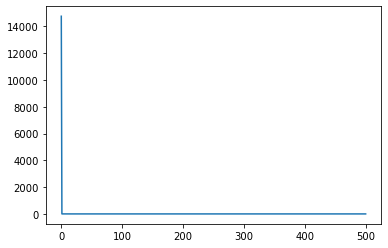

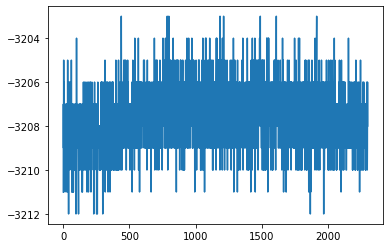

NameError: name 'z' is not defined

In [17]:
# from https://intellipaat.com/community/32125/plotting-a-fast-fourier-transform-in-python
from scipy import fft 

N = 1000 # Number of samplepoints 
T = 1.0 / N # sample spacing 
x = np.linspace(0.0, N*T, N) 

# y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
temp = eeg_ptsa[0][0]
y = temp
filt80120 = temp.filtered([80,120],order=4,filt_type='bandpass')

yf = fft(y) 
xf = np.linspace(0.0, N/2, N/2) 
fig,ax = plt.subplots() 
ax.plot(xf, 2.0/N * np.abs(yf[:N//2])) 
plt.show()

plt.plot(y)
plt.show()
plt.plot(z)
plt.show()

fft_filt80120 = fft(filt80120)
NN = len(filt80120)
xff = np.linspace(0,NN/8,NN/2) # I think this is 4000 ms/500 SR to get 8
plt.plot(xff,8/NN*np.abs(fft_filt80120[:NN//2]))

## Example implementations of various filters being used (70/180 Hz hamming and 40 Hz kaiser)

In [18]:
from scipy.signal import kaiserord,firwin
from scipy import fft

FIR_bandpass = firwin(int(ntaps+1), [70.,180.], fs=desired_sample_rate, window='hamming',pass_zero='bandpass')
FIR_bandstop = firwin(int(ntaps+1), [70.,180.], fs=desired_sample_rate, window='hamming')

NN = eeg_ptsa.shape[2]
xr = np.linspace(0,NN/(4000/sr),NN/2) # 4000 ms of data/500 Hz sampling

## WHAT IS WRONG WITH EEG_RIP?? Nothing! Just hilbert+rectification ruins the bandpass in the FFT

# plot FFT of kaiser 40 hz lowpass
temp_rip = eeg_ptsa[0][0]-8650+1500
filt_temp_rip = filtfilt(kaiser_40lp_filter,1.,temp_rip)
plt.plot(filt_temp_rip); plt.show()
plt.plot(xr,normFFT(filt_temp_rip)); plt.show()

# plot FFT of rectified ripple eeg
temp_rip_band = eeg_rip_band.get_data()[0,0,:]
plt.plot(temp_rip_band); plt.show()
plt.plot(xr,normFFT(temp_rip_band)); plt.show()

# take single trial and filter using Norman FIR filter
temp_eeg = eeg_ptsa[0][0]+8650 # baseline subtracted trial of eeg
temp = filtfilt(FIR_bandpass,1.,temp_eeg)
plt.plot(temp); plt.show()
plt.plot(xr,normFFT(temp)); plt.show();
plt.plot(xr,normFFT(temp_eeg-filtfilt(FIR_bandstop,1.,temp_eeg))); plt.show()

NameError: name 'kaiser_40lp_filter' is not defined

## Looking at individual subject EEGs to understand what's wrong with them

Cumulative array size after channel: 43
(25, 2000)
Cumulative array size after channel: 44
(50, 2000)
Cumulative array size after channel: 45
(75, 2000)
Cumulative array size after channel: 53
(100, 2000)
Cumulative array size after channel: 54
(125, 2000)
Cumulative array size after channel: 121
(150, 2000)
Cumulative array size after channel: 122
(175, 2000)
Cumulative array size after channel: 43
(208, 2000)
Cumulative array size after channel: 44
(241, 2000)
Cumulative array size after channel: 45
(274, 2000)
Cumulative array size after channel: 53
(307, 2000)
Cumulative array size after channel: 54
(340, 2000)
Cumulative array size after channel: 121
(373, 2000)
Cumulative array size after channel: 122
(406, 2000)
good set of electrodes (not correlated with each other)
Cumulative array size after channel: 78
(431, 2000)
Cumulative array size after channel: 79
(456, 2000)
Cumulative array size after channel: 80
(481, 2000)
Cumulative array size after channel: 88
(506, 2000)
Cumulative array size after channel: 89
(531, 2000)
good set of electrodes (not correlated with each other)

## Single trial eeg viewer (load eeg_ptsa above via local run)

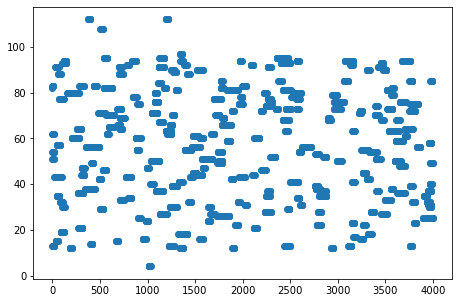

eeg_ptsa shape:
(113, 109, 2000)
Trial: 100, channel: 48


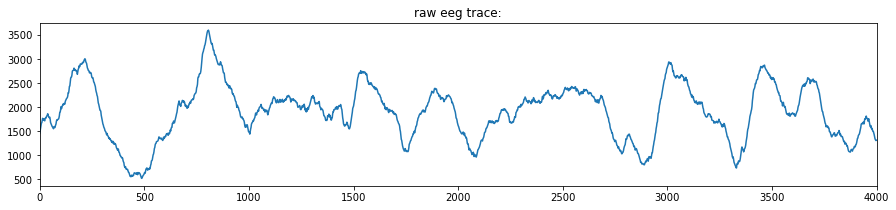

ValueError: The length of the input vector x must be greater than padlen, which is 2403.

In [771]:
from scipy.signal import kaiserord,firwin
from scipy import fft
from ptsa.data.filters import ButterworthFilter

# what ripple array looks like for given electrode/session
temp_array = ripple_array[0:113] #[405:486] #[880:900]
plt.figure(figsize=(plot_width/2, 5))
scatter(np.where(temp_array)[1],np.where(temp_array)[0])
xticks(np.arange(0,2001,250),np.arange(0,4001,500)); plt.show()

trial = 100
channel = 48 # 83

# setup params
bands = [70.,178.]
# FIR_bandpass = firwin(int(ntaps+1), bands, fs=sr, window='hamming',pass_zero='bandpass')
FIR_bandstop = firwin(int(ntaps+1), bands, fs=sr, window='hamming',pass_zero='bandstop')
FFT_xmax = 300
FFT_ymax = 20
xlimit = 4000
plot_width = 15

sr_factor = 1000/sr
temp_eeg_ptsa = eeg_ptsa[:,:,int(300/sr_factor):int(4300/sr_factor)] # remove buffers

print('eeg_ptsa shape:')
print(temp_eeg_ptsa.shape)
temp_rip = temp_eeg_ptsa[trial][channel] # get single trial
NN = temp_eeg_ptsa.shape[2]
xr = np.linspace(0,NN/(8000/1000),NN/2) # 4000 ms of data/500 Hz sampling

# plot raw eeg 
print('Trial: '+str(trial)+', '+'channel: '+str(channel))
xrange = np.arange(0,xlimit,sr_factor)
plt.figure(figsize=(plot_width, 3)); title('raw eeg trace:');
plt.plot(xrange,temp_rip); plt.xlim((0,xlimit)); plt.show()

# # filter out 120 Hz?
# eeg_120_removed = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[58.,62.], filt_type='stop', order=4).filter()
# eeg_180_removed = ButterworthFilter(timeseries=eeg_120_removed, freq_range=[178.,182.], filt_type='stop', order=4).filter()
# eeg_180_removed = eeg_180_removed[trial][channel]
# print('eeg 60 and 180 line removed')
# plt.plot(eeg_180_removed); plt.xlim((0,xlimit)); plt.show()
# print('FFT of eeg 60 and 180 removed')
# plt.plot(xr,normFFT(eeg_180_removed)); plt.xlim((0,FFT_xmax)); plt.ylim((0,FFT_ymax)); plt.show()

# take single trial and filter using Norman FIR filter
eeg_ptsa_trial = temp_eeg_ptsa[trial:trial+1] # grab desired trial 
filt_eeg_rip = eeg_ptsa_trial-filtfilt(FIR_bandstop,1.,eeg_ptsa_trial)
plt.figure(figsize=(plot_width, 3)); title('70-178 bandpass filtered:')
plt.plot(xrange,filt_eeg_rip[0][channel]); plt.xlim((0,xlimit)); plt.show()

# plot after taking hilbert
hilb_filt_eeg_rip = ptsa_to_mne(filt_eeg_rip,[0,4000])
_ = hilb_filt_eeg_rip.apply_hilbert(envelope=True)
plt.figure(figsize=(plot_width, 3)); title('Hilbert: ')
plt.plot(xrange,hilb_filt_eeg_rip.get_data()[0,channel,:]); 

# print('fft after bandpass (looks weird probably needs diff treatment)')
# N = int(len(temp_rip)/(1000/(bands[1]-bands[0])))
# fft_eeg = 1/N*np.abs(fft(temp_rip)[:N//2])
# x_fft = np.linspace(0,N/4,N/2)+70
# plt.plot(x_fft,fft_eeg); plt.xlim((0,FFT_xmax)); plt.ylim((0,20*FFT_ymax)); plt.show();

# plot FFT
plt.figure(figsize=(plot_width, 3)); title('FFT of this trial:');
plt.plot(xr,normFFT(temp_rip)); plt.xlim((0,FFT_xmax)); plt.ylim((0,FFT_ymax)); plt.show();


In [772]:
session
sub
eeg_ptsa_trial.shape
len(FIR_bandstop)

1

'R1364C'

(1, 109, 2000)

801

(103, 120, 4000)
Trial: 0


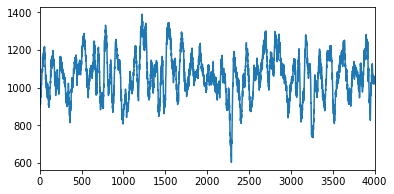

Trial: 1


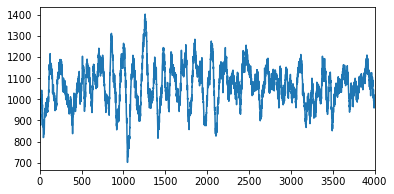

Trial: 2


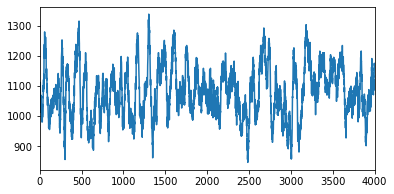

Trial: 3


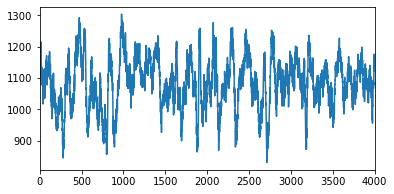

Trial: 4


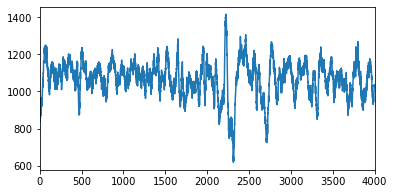

Trial: 5


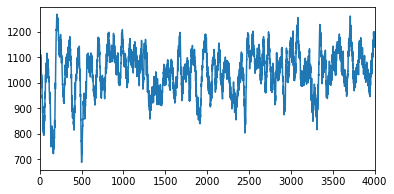

Trial: 6


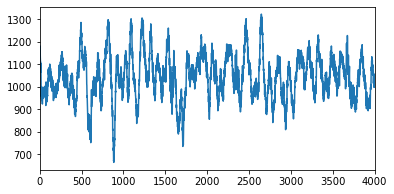

Trial: 7


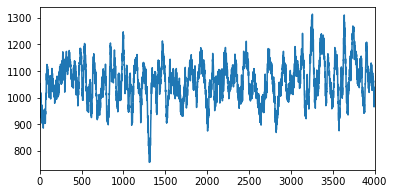

Trial: 8


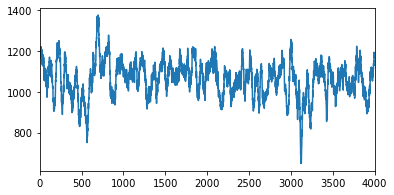

Trial: 9


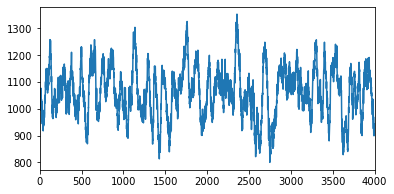

Trial: 10


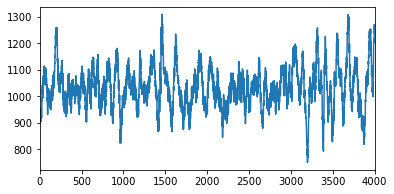

Trial: 11


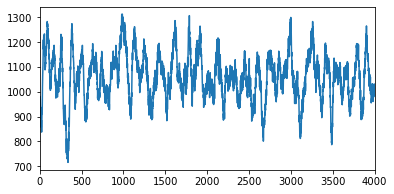

Trial: 12


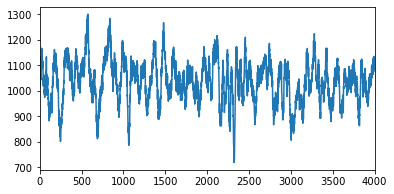

Trial: 13


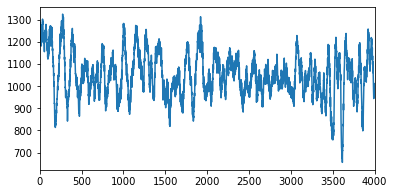

Trial: 14


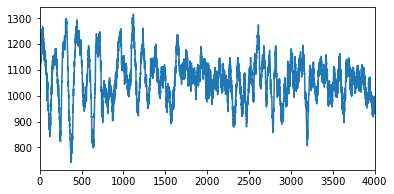

Trial: 15


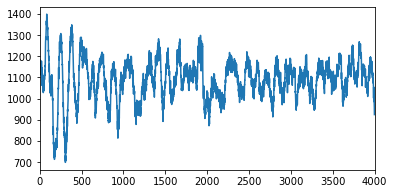

Trial: 16


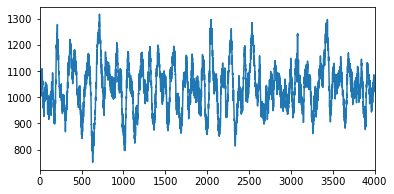

Trial: 17


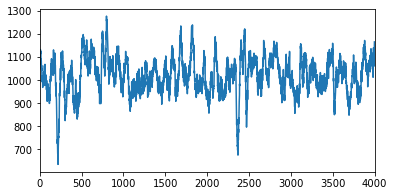

Trial: 18


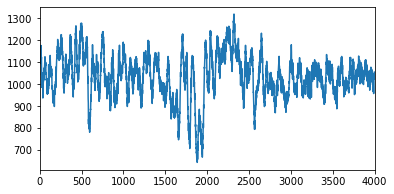

Trial: 19


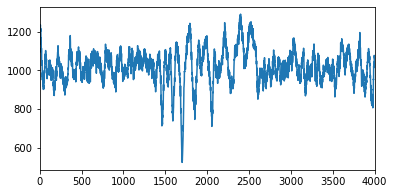

Trial: 20


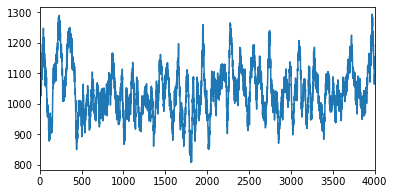

Trial: 21


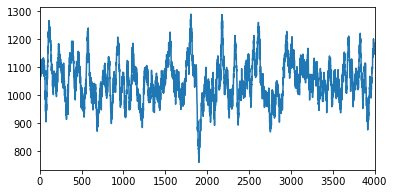

Trial: 22


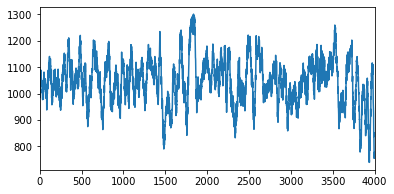

Trial: 23


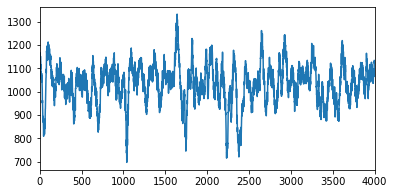

Trial: 24


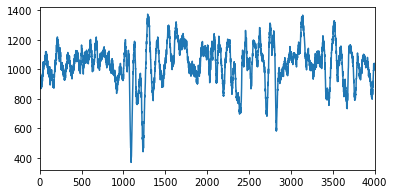

Trial: 25


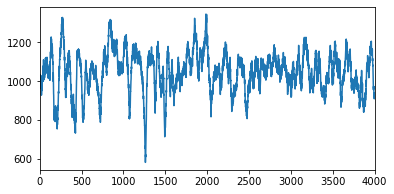

Trial: 26


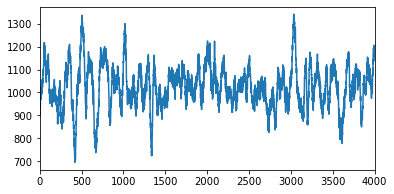

Trial: 27


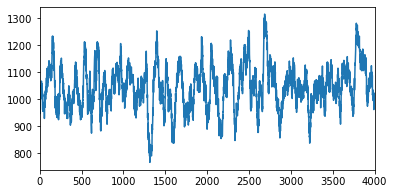

Trial: 28


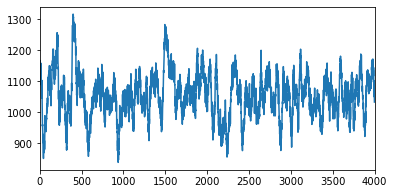

Trial: 29


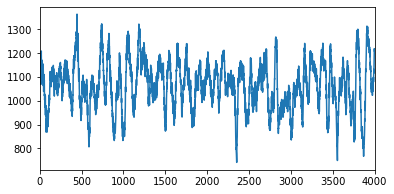

Trial: 30


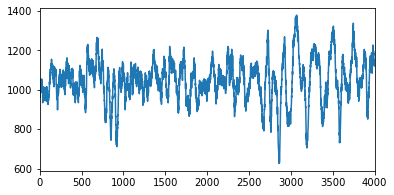

Trial: 31


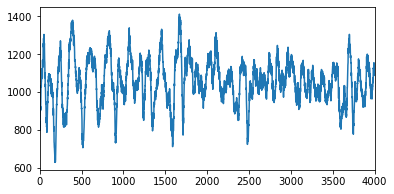

Trial: 32


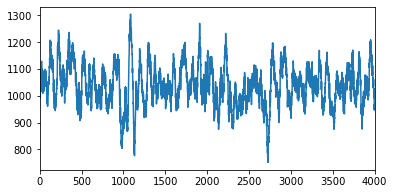

Trial: 33


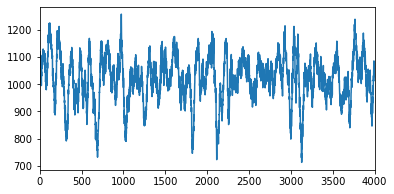

Trial: 34


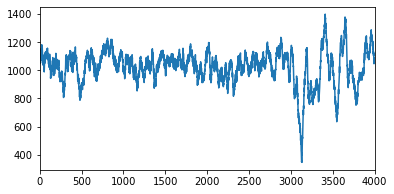

Trial: 35


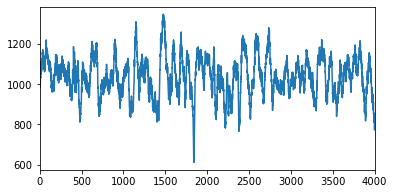

Trial: 36


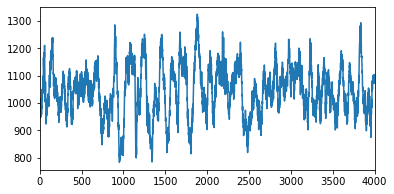

Trial: 37


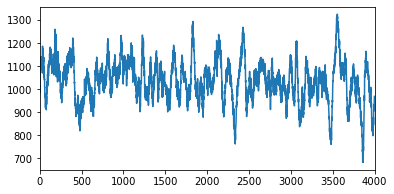

Trial: 38


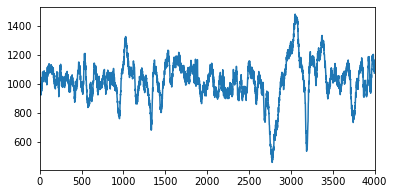

Trial: 39


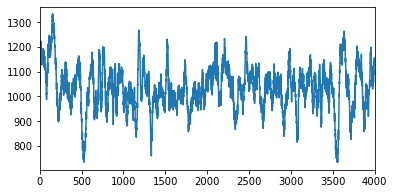

Trial: 40


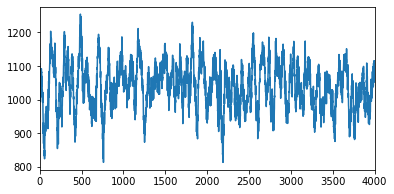

Trial: 41


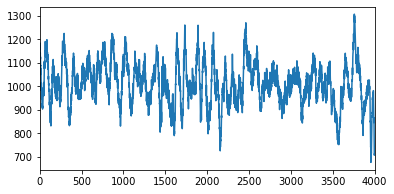

Trial: 42


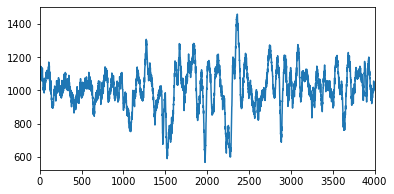

Trial: 43


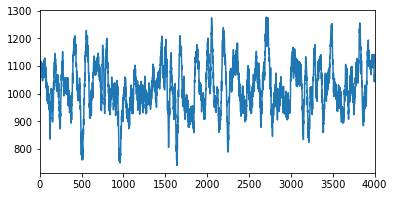

Trial: 44


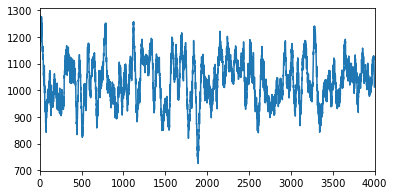

Trial: 45


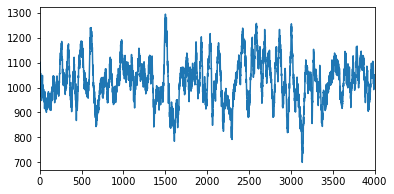

Trial: 46


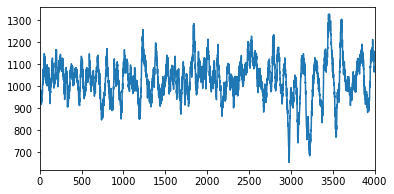

Trial: 47


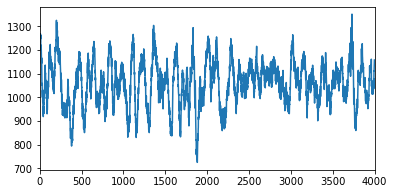

Trial: 48


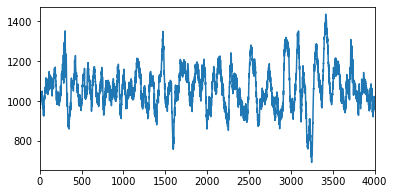

Trial: 49


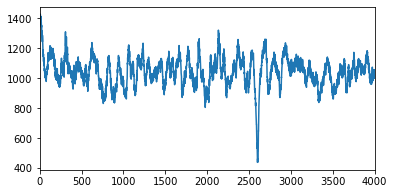

Trial: 50


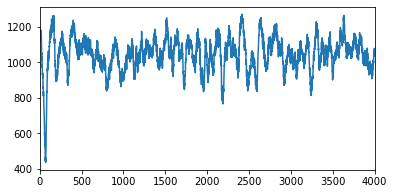

Trial: 51


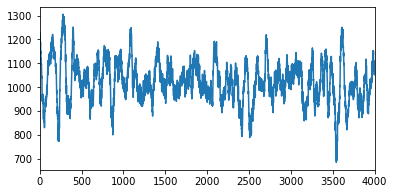

Trial: 52


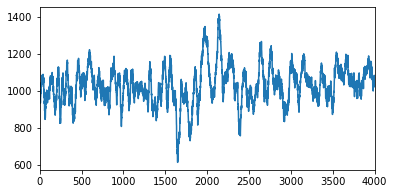

Trial: 53


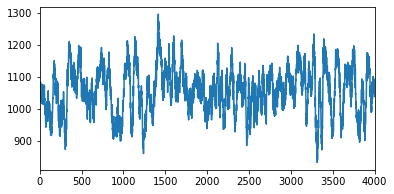

Trial: 54


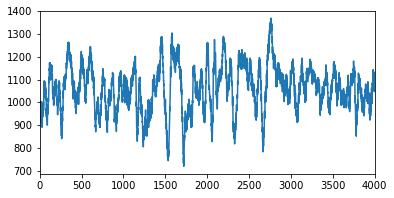

Trial: 55


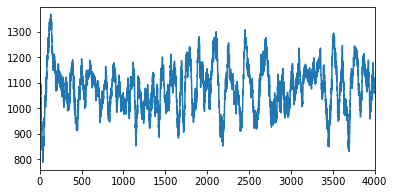

Trial: 56


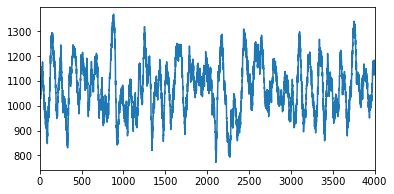

Trial: 57


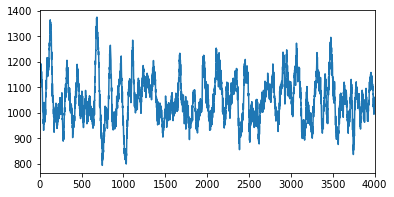

Trial: 58


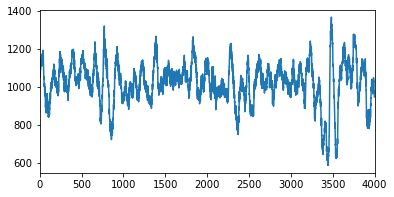

Trial: 59


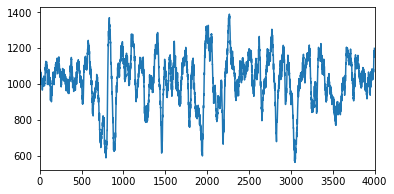

Trial: 60


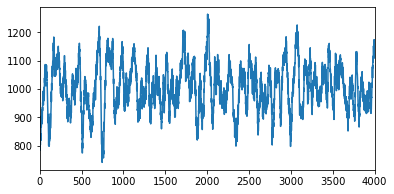

Trial: 61


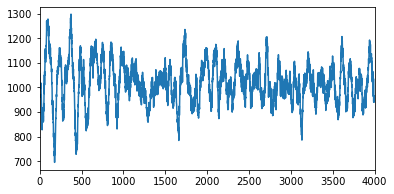

Trial: 62


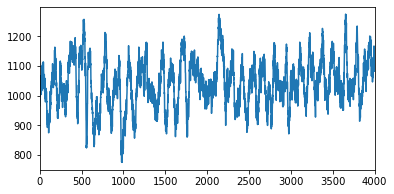

Trial: 63


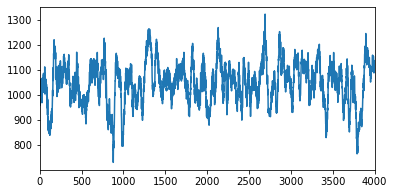

Trial: 64


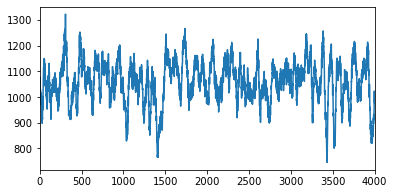

Trial: 65


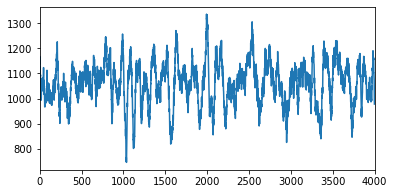

Trial: 66


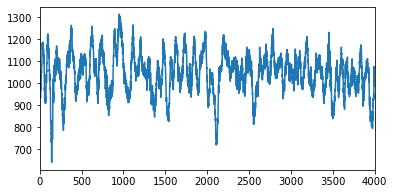

Trial: 67


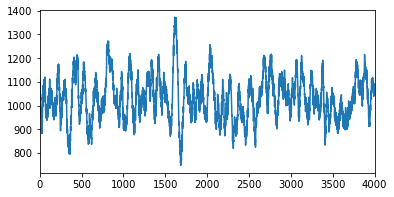

Trial: 68


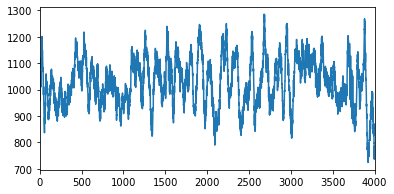

Trial: 69


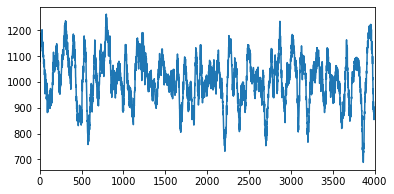

Trial: 70


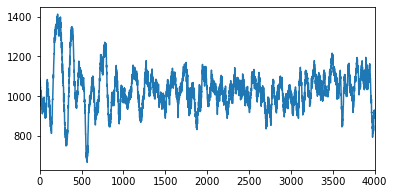

Trial: 71


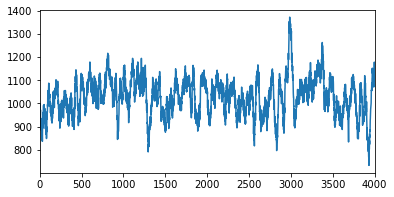

Trial: 72


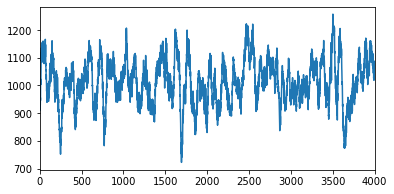

Trial: 73


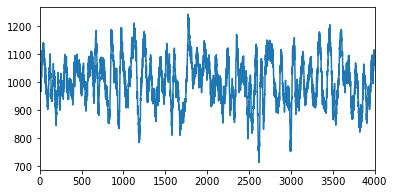

Trial: 74


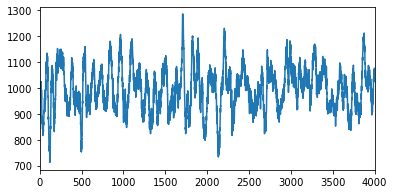

Trial: 75


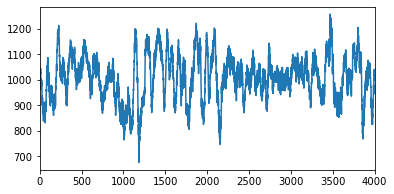

Trial: 76


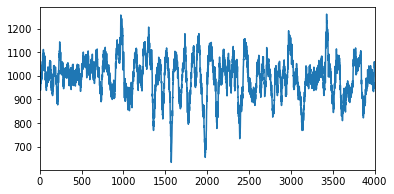

Trial: 77


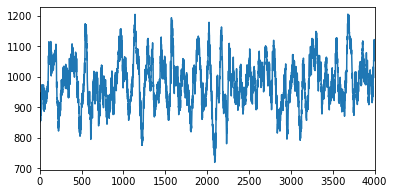

Trial: 78


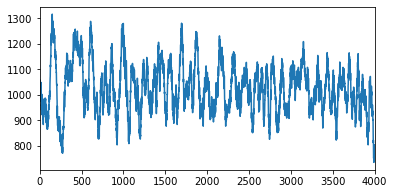

Trial: 79


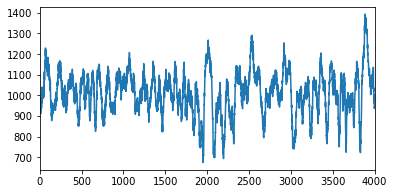

Trial: 80


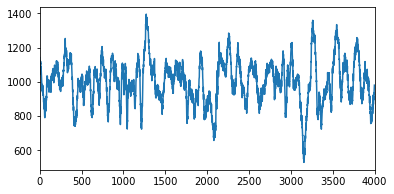

Trial: 81


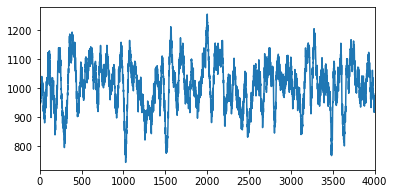

Trial: 82


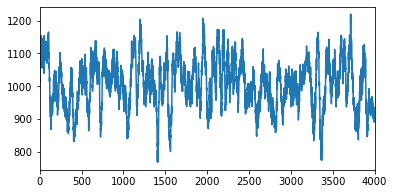

Trial: 83


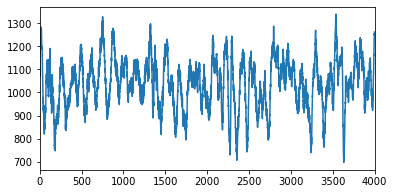

Trial: 84


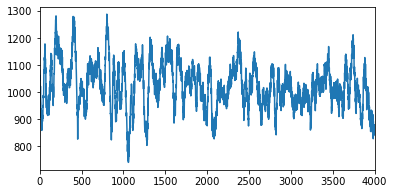

Trial: 85


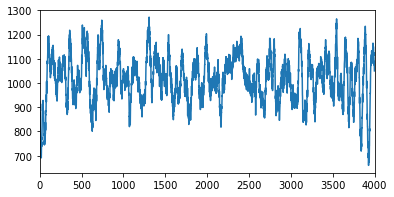

Trial: 86


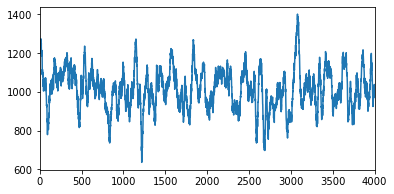

Trial: 87


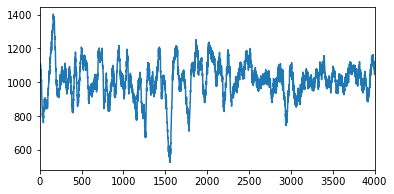

Trial: 88


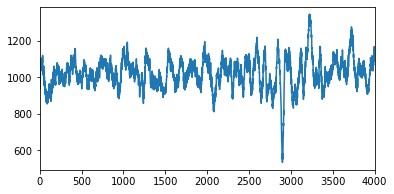

Trial: 89


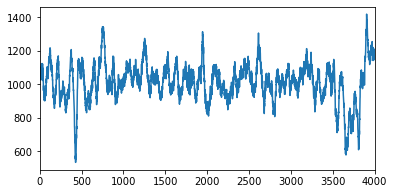

Trial: 90


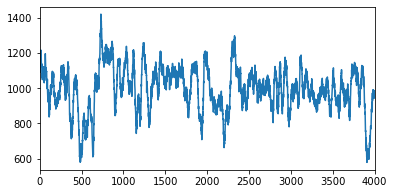

Trial: 91


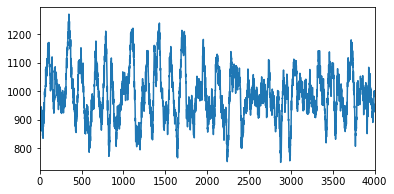

Trial: 92


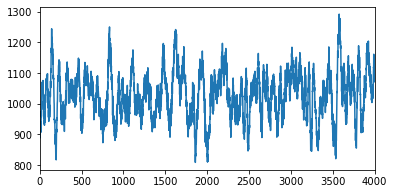

Trial: 93


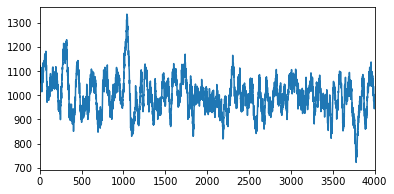

Trial: 94


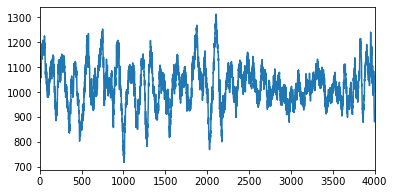

Trial: 95


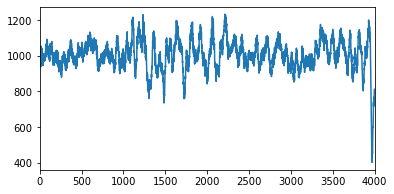

Trial: 96


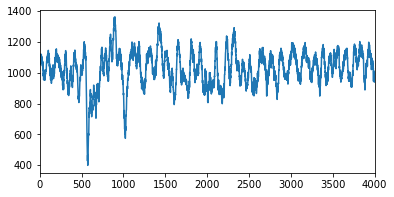

Trial: 97


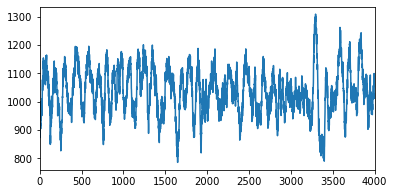

Trial: 98


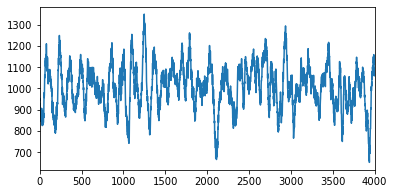

Trial: 99


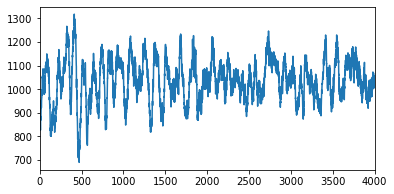

Trial: 100


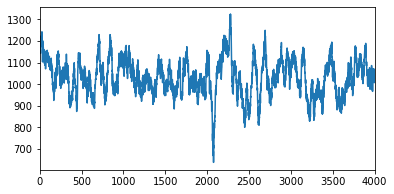

Trial: 101


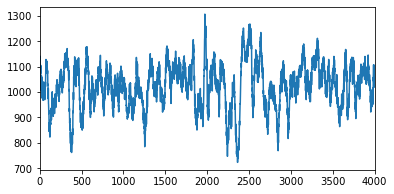

Trial: 102


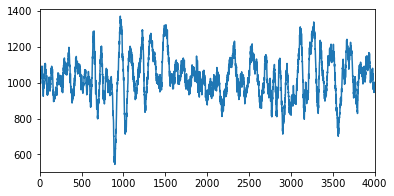

In [460]:
# plot all eeg trials for given channel
channel = 104 # 104 v 102 and 105
bands = [70.,178.]
FIR_bandpass = firwin(int(ntaps+1), bands, fs=desired_sample_rate, window='hamming',pass_zero='bandpass')

print(eeg_ptsa.shape)
for t in range(eeg_ptsa.shape[0]):
    temp_rip = eeg_ptsa[t][channel] # get single trial
    NN = eeg_ptsa.shape[2]
    xr = np.linspace(0,NN/(8000/1000),NN/2) # 4000 ms of data/500 Hz sampling
    print('Trial: '+str(t))
    plt.figure(figsize=(6, 3))
    plt.plot(temp_rip); plt.xlim((0,1000*(2000/sr))); plt.show()
a=1;

In [3]:
# which recalls have another recall in 2 s
import mne
from scipy.signal import firwin,filtfilt,kaiserord
import pingouin as pg
%autoreload

### PARAMS ###

save_values = 0

selected_period = 'surrounding_recall' 
# there are three periods this code is set up to look at: periods aligned to recall, the entire retrieval period, and the encoding period

selected_region = HPC_labels #HPC_labels # ENT_labels+HPC_labels 

remove_soz_ictal = False # False only removes bad electrodes and not soz/ictal
min_ripple_rate = 0.1 # Hz.
max_ripple_rate = 1.0 # Hz.
max_trial_by_trial_correlation = 0.05 # if ripples correlated more than this remove them
max_electrode_by_electrode_correlation = 0.2 #???

filter_type = 'hamming' # 'butter' # Vaz used Butterworth from 80-120 Hz; Norman used Hamming from 70-180 Hz

# recall params
IRI = 2000 # inter-ripple interval...remove ripples within this range (keep only first one and remove those after it)
retrieval_whole_time = 30000
# encoding params
encoding_time = 2300 # actual preentation is 1.6 s + 0.75-1.0 s so keep +700 ms so can plot +500 ms
pre_encoding_time = -700 # since minimum ISI is 0.75 s let's only plot the 500 ms before word on with a 200 ms buffer
# these aren't likely to be changed:
desired_sample_rate = 500. # in Hz. This seems like lowerst common denominator recording freq.

### END PARAMS ###

if 'entorhinal' in selected_region and 'left hippocampus' in selected_region:
    region_name = 'HPC_ENT'
elif 'entorhinal' in selected_region:
    region_name = 'ENT'
elif 'left hippocampus' in selected_region:
    region_name = 'HPC'
if selected_period == 'surrounding_recall':
    psth_start = -IRI # only makes sense to look at period <= IRI
    psth_end = IRI # how long to grab data after recall
elif selected_period == 'whole_retrieval':
    psth_start = -IRI # doesn't have to be IRI just 2000 ms is convenient
    psth_end = IRI+retrieval_whole_time
elif selected_period == 'encoding':
    psth_start = pre_encoding_time
    psth_end = encoding_time

ripple_array = []; fr_array = []; 
trial_nums = []; 
session_ct = 0; channel_ct = 0
HPC_names = []; sub_names = []; sub_sess_names = []
electrodes_per_session = []
total_lists = 0; total_recalls = 0; kept_recalls = 0
ent_elec_ct = []; sd_regions = []; not_sd_regions = []
ripple_ied_accum_ct = []
time_add_save = [];             
encoded_word_key_array = []; serialpos_array = [] # encoding info

trial_by_trial_correlation = []; elec_by_elec_correlation = []
elec_ripple_rate_array = []

for row in exp_df.itertuples(): #sub_df.itertuples():   
    sub = row.subject; session = row.session; exp = row.experiment
    mont = int(row.montage); loc = int(row.localization)
    reader = CMLReadDFRow(row)
    evs = reader.load('task_events')
    evs_free_recall = evs[(evs.type=='REC_WORD') & (evs.recalled==True)] # recalled word AND correct (in previous list)
    # remove events with Inter-Recall Intervals too small. Use psth_start for IRI since that's what will show in PSTH
    import ipdb; ipdb.set_trace()
    evs_free_recall = evs_free_recall[np.append(True,np.diff(evs_free_recall.mstime)>IRI)] 

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.4, the latest is 0.3.6.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


--Call--
> /home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/IPython/core/displayhook.py(252)__call__()
    251 
--> 252     def __call__(self, result=None):
    253         """Printing with history cache management.



ipdb>  q


BdbQuit: 

In [ ]:
plt.hist(serialpos_array)
title('FR1 recalls by serialpos')
xlabel('serial position')
ylabel('Recalls (#)'); show()
plt.hist(list_recall_num_array,np.arange(0,13,1))
title('FR1 recalls by recalls/list')
xlabel('Recalls/list')
ylabel('Recalls (#)'); show()
plt.hist(rectime_array,np.arange(0,30001,500))
title('FR1 recalls by rectime')
xlabel('Recall time during retrieval (s)')
ylabel('Recalls (#)'); show();

# get number of unique patients across all regions

In [44]:
CA1_FR1 = ['R1001P', 'R1002P', 'R1003P', 'R1006P', 'R1010J', 'R1020J',
       'R1022J', 'R1027J', 'R1032D', 'R1033D', 'R1034D', 'R1035M',
       'R1044J', 'R1048E', 'R1053M', 'R1054J', 'R1056M', 'R1059J',
       'R1061T', 'R1063C', 'R1065J', 'R1066P', 'R1068J', 'R1077T',
       'R1080E', 'R1083J', 'R1086M', 'R1089P', 'R1094T', 'R1096E',
       'R1101T', 'R1102P', 'R1105E', 'R1108J', 'R1112M', 'R1113T',
       'R1115T', 'R1120E', 'R1122E', 'R1123C', 'R1125T', 'R1128E',
       'R1131M', 'R1134T', 'R1136N', 'R1137E', 'R1138T', 'R1147P',
       'R1151E', 'R1153T', 'R1154D', 'R1158T', 'R1161E', 'R1162N',
       'R1163T', 'R1171M', 'R1172E', 'R1174T', 'R1176M', 'R1191J',
       'R1195E', 'R1200T', 'R1204T', 'R1207J', 'R1212P', 'R1215M',
       'R1217T', 'R1229M', 'R1230J', 'R1236J', 'R1243T', 'R1260D',
       'R1268T', 'R1275D', 'R1281E', 'R1283T', 'R1292E', 'R1293P',
       'R1297T', 'R1298E', 'R1299T', 'R1306E', 'R1308T', 'R1310J',
       'R1311T', 'R1313J', 'R1315T', 'R1316T', 'R1320D', 'R1323T',
       'R1325C', 'R1330D', 'R1332M', 'R1334T', 'R1336T', 'R1337E',
       'R1338T', 'R1339D', 'R1342M', 'R1345D', 'R1346T', 'R1350D',
       'R1354E', 'R1355T', 'R1358T', 'R1363T', 'R1367D', 'R1368T',
       'R1374T', 'R1380D', 'R1381T', 'R1382T', 'R1383J', 'R1385E',
       'R1386T', 'R1387E', 'R1393T', 'R1396T', 'R1397D', 'R1398J',
       'R1415T', 'R1416T', 'R1422T', 'R1425D', 'R1427T', 'R1436J',
       'R1446T', 'R1448T', 'R1449T', 'R1467M']
DG_FR1 = ['R1001P', 'R1006P', 'R1010J', 'R1020J', 'R1022J', 'R1033D',
       'R1034D', 'R1048E', 'R1053M', 'R1056M', 'R1061T', 'R1063C',
       'R1065J', 'R1068J', 'R1080E', 'R1083J', 'R1086M', 'R1089P',
       'R1094T', 'R1096E', 'R1101T', 'R1102P', 'R1108J', 'R1112M',
       'R1122E', 'R1123C', 'R1134T', 'R1136N', 'R1137E', 'R1138T',
       'R1150J', 'R1151E', 'R1154D', 'R1158T', 'R1161E', 'R1168T',
       'R1172E', 'R1174T', 'R1203T', 'R1212P', 'R1215M', 'R1217T',
       'R1221P', 'R1226D', 'R1229M', 'R1230J', 'R1236J', 'R1243T',
       'R1260D', 'R1281E', 'R1292E', 'R1293P', 'R1306E', 'R1310J',
       'R1311T', 'R1315T', 'R1323T', 'R1325C', 'R1332M', 'R1334T',
       'R1336T', 'R1338T', 'R1341T', 'R1347D', 'R1349T', 'R1350D',
       'R1354E', 'R1355T', 'R1367D', 'R1374T', 'R1381T', 'R1382T',
       'R1385E', 'R1387E', 'R1397D', 'R1416T', 'R1420T', 'R1422T',
       'R1427T', 'R1436J', 'R1446T', 'R1448T', 'R1467M']
ENT_FR1 = ['R1001P', 'R1018P', 'R1020J', 'R1026D', 'R1031M', 'R1034D',
       'R1036M', 'R1044J', 'R1048E', 'R1052E', 'R1053M', 'R1054J',
       'R1059J', 'R1063C', 'R1066P', 'R1067P', 'R1077T', 'R1083J',
       'R1089P', 'R1092J', 'R1112M', 'R1113T', 'R1118N', 'R1125T',
       'R1128E', 'R1134T', 'R1136N', 'R1138T', 'R1149N', 'R1162N',
       'R1172E', 'R1175N', 'R1185N', 'R1196N', 'R1215M', 'R1217T',
       'R1221P', 'R1241J', 'R1299T', 'R1302M', 'R1311T', 'R1323T',
       'R1325C', 'R1329T', 'R1334T', 'R1336T', 'R1341T', 'R1346T',
       'R1354E', 'R1355T', 'R1358T', 'R1361C', 'R1374T', 'R1376D',
       'R1380D', 'R1381T', 'R1385E', 'R1387E', 'R1391T', 'R1394E',
       'R1396T', 'R1397D', 'R1402E', 'R1422T', 'R1423E', 'R1425D',
       'R1427T', 'R1461T', 'R1463E', 'R1467M']
PHC_FR1 = ['R1002P', 'R1006P', 'R1010J', 'R1020J', 'R1026D', 'R1048E',
       'R1052E', 'R1059J', 'R1066P', 'R1068J', 'R1070T', 'R1077T',
       'R1083J', 'R1086M', 'R1089P', 'R1102P', 'R1108J', 'R1113T',
       'R1115T', 'R1122E', 'R1123C', 'R1125T', 'R1128E', 'R1138T',
       'R1149N', 'R1153T', 'R1172E', 'R1187P', 'R1203T', 'R1288P',
       'R1290M', 'R1299T', 'R1310J', 'R1313J', 'R1316T', 'R1317D',
       'R1325C', 'R1337E', 'R1346T', 'R1361C', 'R1364C', 'R1373T',
       'R1378T', 'R1379E', 'R1386T', 'R1390M', 'R1391T', 'R1394E',
       'R1396T', 'R1398J', 'R1402E', 'R1405E', 'R1412M', 'R1414E',
       'R1421M', 'R1422T', 'R1423E', 'R1436J', 'R1438M', 'R1454M',
       'R1457T', 'R1460M', 'R1467M']
CA1_catFR1 = ['R1004D', 'R1015J', 'R1024E', 'R1032D', 'R1035M', 'R1045E',
       'R1056M', 'R1061T', 'R1065J', 'R1066P', 'R1083J', 'R1086M',
       'R1089P', 'R1092J', 'R1094T', 'R1102P', 'R1105E', 'R1108J',
       'R1112M', 'R1131M', 'R1138T', 'R1144E', 'R1147P', 'R1157C',
       'R1158T', 'R1163T', 'R1171M', 'R1174T', 'R1176M', 'R1180C',
       'R1188C', 'R1192C', 'R1204T', 'R1207J', 'R1217T', 'R1226D',
       'R1227T', 'R1230J', 'R1236J', 'R1239E', 'R1240T', 'R1243T',
       'R1245E', 'R1275D', 'R1278E', 'R1293P', 'R1303E', 'R1310J',
       'R1313J', 'R1315T', 'R1320D', 'R1330D', 'R1332M', 'R1334T',
       'R1337E', 'R1338T', 'R1342M', 'R1343J', 'R1348J', 'R1354E',
       'R1366J', 'R1367D', 'R1368T', 'R1374T', 'R1380D', 'R1382T',
       'R1383J', 'R1385E', 'R1386T', 'R1387E', 'R1388T', 'R1393T',
       'R1396T', 'R1397D', 'R1415T', 'R1422T', 'R1427T', 'R1436J',
       'R1445E', 'R1448T', 'R1449T', 'R1450D', 'R1456D', 'R1465D',
       'R1467M', 'R1468J', 'R1472T', 'R1476J', 'R1484T', 'R1486J',
       'R1488T', 'R1497T', 'R1498D', 'R1501J', 'R1515T', 'R1518T',
       'R1527J', 'R1536J']
DG_catFR1 = ['R1004D', 'R1015J', 'R1045E', 'R1056M', 'R1061T', 'R1065J',
       'R1083J', 'R1086M', 'R1089P', 'R1092J', 'R1094T', 'R1102P',
       'R1108J', 'R1112M', 'R1138T', 'R1144E', 'R1158T', 'R1174T',
       'R1188C', 'R1190P', 'R1217T', 'R1221P', 'R1226D', 'R1227T',
       'R1230J', 'R1236J', 'R1239E', 'R1243T', 'R1245E', 'R1269E',
       'R1278E', 'R1303E', 'R1310J', 'R1315T', 'R1332M', 'R1334T',
       'R1338T', 'R1342M', 'R1347D', 'R1354E', 'R1367D', 'R1368T',
       'R1374T', 'R1382T', 'R1385E', 'R1387E', 'R1397D', 'R1420T',
       'R1422T', 'R1427T', 'R1436J', 'R1448T', 'R1450D', 'R1456D',
       'R1465D', 'R1468J', 'R1476J', 'R1482J', 'R1484T', 'R1486J',
       'R1498D', 'R1501J', 'R1515T', 'R1527J', 'R1536J']
all_subs = np.unique(CA1_FR1+DG_FR1+ENT_FR1+PHC_FR1+CA1_catFR1+DG_catFR1)
print('Number of total subs: '+str(len(all_subs)))

FR1_subs = np.unique(CA1_FR1+DG_FR1+ENT_FR1+PHC_FR1)
print('Number of total FR1 subs: '+str(len(FR1_subs)))

catFR1_subs = np.unique(CA1_catFR1+DG_catFR1)
print('Number of total catFR1 subs: '+str(len(catFR1_subs)))

both_FR_catFR1_subs = np.unique((set(FR1_subs) & set(catFR1_subs)))
print('Number of subs that did both tasks: '+str(len(both_FR_catFR1_subs[0])))

# what FR1 subs have pairs in all 4 regions?
FR1_list_of_lists = [CA1_FR1,DG_FR1,ENT_FR1,PHC_FR1]
set(FR1_list_of_lists[0]).intersection(*FR1_list_of_lists)

# subs with all 4 regions and solid trial count: R1048E, R1083J

Number of total subs: 219
Number of total FR1 subs: 180
Number of total catFR1 subs: 104
Number of subs that did both tasks: 65


{'R1020J',
 'R1048E',
 'R1083J',
 'R1089P',
 'R1138T',
 'R1172E',
 'R1325C',
 'R1422T',
 'R1467M'}

In [43]:
len(both_FR_catFR1_subs[0])

65